In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
import torch
from torch import nn
from torch.utils.data import DataLoader
import optuna

from library.Data_Preprocessing import Balance_Ratio, train_col
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history
from library.XGBoost import XGBoost_creator
from library.LightGBM import LightGBM_creator
from library.CatBoost import CatBoost_creator
from library.RandomForest import RandomForest_creator
from library.ExtraTrees import ExtraTrees_creator
from library.NeuralNetwork import RunhistSet, NeuralNetworkC, trainingC
from library.StackingCV_Scheme3 import optimize_base, stratified_data, runall_LR, runall_RidgeR, stackingCV_creator, \
    correlation_plot, vif, rank_importance, month_param

os.chdir('C:/Users/user/Desktop/Darui_R08621110')  
os.getcwd()

Using cpu device.


'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### Transform Data by Base Learners

In [3]:
# input training data to the base learners and output the outcome
def transform_train(train_data, mode, base_param, cv, add_origin = False):
    
    month_list = list(base_param.keys())
    model_list = list(base_param[month_list[0]].keys())
    set_list = list(base_param[month_list[0]][model_list[0]].keys())
    set_dict = {} 
    for i in tqdm(set_list):
        
        train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train_data[i], cv = cv)
        all_month = pd.DataFrame()
        for month in tqdm(month_list):    
            
            all_cv = pd.DataFrame()
            for j in range(cv):
                
                model_predict = pd.DataFrame()
                if mode == 'C':

                    if 'NeuralNetwork' in model_list:
                        temp_train = RunhistSet(train_x_dict[j], train_y_dict[j])
                        temp_valid = RunhistSet(valid_x_dict[j], valid_y_dict[j])
                        train_loader = DataLoader(temp_train, 
                                                  batch_size = base_param[month]['NeuralNetwork'][i]['batch_size'], 
                                                  shuffle = True)
                        valid_loader = DataLoader(temp_valid, batch_size = len(valid_x_dict[j]), shuffle = False)
                        nn_model = NeuralNetworkC(dim = train_x_dict[j].shape[1])
                        optimizer = torch.optim.Adam(nn_model.parameters(), 
                                                     lr = base_param[month]['NeuralNetwork'][i]['learning_rate'], 
                                                     weight_decay = base_param[month]['NeuralNetwork'][i]['weight_decay'])
                        criterion = nn.CrossEntropyLoss(
                            weight = torch.tensor([1-base_param[month]['NeuralNetwork'][i]['bad_weight'], 
                                                   base_param[month]['NeuralNetwork'][i]['bad_weight']])).to('cpu')
                        network, _, _ = trainingC(nn_model, train_loader, train_loader, optimizer, criterion, epoch = 100, 
                                                  early_stop = 10)
                        for x, y in valid_loader:
                            output = network(x)
                            predict_y = output.data[:, 1]
                        predict = pd.DataFrame({f'N_{month}': predict_y.numpy()})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                    
                    if 'XGBoost' in model_list:                     
                        clf = XGBClassifier(**base_param[month]['XGBoost'][i], n_jobs = -1)
                        clf.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = clf.predict_proba(valid_x_dict[j])
                        predict = pd.DataFrame({f'X_{month}': predict_y[:, 0]})
                        model_predict = pd.concat([model_predict, predict], axis = 1)

                    if 'LightGBM' in model_list:                        
                        clf = LGBMClassifier(**base_param[month]['LightGBM'][i])
                        clf.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = clf.predict_proba(valid_x_dict[j])
                        predict = pd.DataFrame({f'L_{month}': predict_y[:, 0]})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                    if 'CatBoost' in model_list:
                        clf = CatBoostClassifier(**base_param[month]['CatBoost'][i])
                        clf.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = clf.predict_proba(valid_x_dict[j])
                        predict = pd.DataFrame({f'C_{month}': predict_y[:, 0]})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                    if 'RandomForest' in model_list:
                        clf = RandomForestClassifier(**base_param[month]['RandomForest'][i])
                        clf.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = clf.predict_proba(valid_x_dict[j])
                        predict = pd.DataFrame({f'R_{month}': predict_y[:, 0]})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                    if 'ExtraTrees' in model_list:
                        clf = ExtraTreesClassifier(**base_param[month]['ExtraTrees'][i])
                        clf.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = clf.predict_proba(valid_x_dict[j])
                        predict = pd.DataFrame({f'E_{month}': predict_y[:, 0]})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                elif mode == 'R':
                    
                    if 'XGBoost' in model_list:
                        reg = XGBRegressor(**base_param[month]['XGBoost'][i], n_jobs = -1)
                        reg.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = reg.predict(valid_x_dict[j])
                        predict = pd.DataFrame({f'X_{month}': predict_y})
                        model_predict = pd.concat([model_predict, predict], axis = 1)

                    if 'LightGBM' in model_list:
                        reg = LGBMRegressor(**base_param[month]['LightGBM'][i])
                        reg.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = reg.predict(valid_x_dict[j])
                        predict = pd.DataFrame({f'L_{month}': predict_y})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                    if 'CatBoost' in model_list:
                        reg = CatBoostRegressor(**base_param[month]['CatBoost'][i])
                        reg.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = reg.predict(valid_x_dict[j])
                        predict = pd.DataFrame({f'C_{month}': predict_y})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                    if 'RandomForest' in model_list:
                        reg = RandomForestRegressor(**base_param[month]['RandomForest'][i])
                        reg.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = reg.predict(valid_x_dict[j])
                        predict = pd.DataFrame({f'R_{month}': predict_y})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                    
                    if 'ExtraTrees' in model_list:
                        reg = ExtraTreesRegressor(**base_param[month]['ExtraTrees'][i])
                        reg.fit(train_x_dict[j], train_y_dict[j])
                        predict_y = reg.predict(valid_x_dict[j])
                        predict = pd.DataFrame({f'E_{month}': predict_y})
                        model_predict = pd.concat([model_predict, predict], axis = 1)
                        
                test_label = valid_y_dict[j].reset_index(drop = True)
                origin_feature = valid_x_dict[j].reset_index(drop = True)
                if month == month_list[-1]:
                    if add_origin:
                        done_cv = pd.concat([model_predict, origin_feature, test_label], axis = 1)
                    else:
                        done_cv = pd.concat([model_predict, test_label], axis = 1)
                else:
                    done_cv = model_predict
                        
                all_cv = pd.concat([all_cv, done_cv], axis = 0)                
            all_month = pd.concat([all_month, all_cv], axis = 1)
        set_dict[i] = all_month
    
    return set_dict


# input testing data to the base learners and output the outcome
def transform_test(train_data, test_data, mode, base_param, add_origin = False):
    
    month_list = list(base_param.keys())
    model_list = list(base_param[month_list[0]].keys())
    set_list = list(base_param[month_list[0]][model_list[0]].keys())
    test_dict = {}
    for i in tqdm(set_list):
        
        month_test = pd.DataFrame()
        for month in tqdm(month_list):
            
            select_test = train_col(train_data[month][i], test_data)
            train_x, train_y, test_x, test_y = label_divide(train_data[month][i], select_test, train_only = False)
            model_predict = pd.DataFrame()
            if mode == 'C':

                if 'NeuralNetwork' in model_list:
                    temp_train = RunhistSet(train_x, train_y)
                    temp_test = RunhistSet(test_x, test_y)
                    train_loader = DataLoader(temp_train, 
                                              batch_size = base_param[month]['NeuralNetwork'][i]['batch_size'], 
                                              shuffle = True)
                    test_loader = DataLoader(temp_test, batch_size = len(test_x), shuffle = False)
                    nn_model = NeuralNetworkC(dim = train_x.shape[1])
                    optimizer = torch.optim.Adam(nn_model.parameters(), 
                                                 lr = base_param[month]['NeuralNetwork'][i]['learning_rate'], 
                                                 weight_decay = base_param[month]['NeuralNetwork'][i]['weight_decay'])
                    criterion = nn.CrossEntropyLoss(
                        weight = torch.tensor([1-base_param[month]['NeuralNetwork'][i]['bad_weight'], 
                                               base_param[month]['NeuralNetwork'][i]['bad_weight']])).to('cpu')
                    network, _, _ = trainingC(nn_model, train_loader, train_loader, optimizer, criterion, epoch = 100, 
                                              early_stop = 10)
                    for X, Y in test_loader:
                        X, Y = X.float(), Y.long()
                        output = network(X)
                        predict_y = output.data[:, 1]
                    predict = pd.DataFrame({f'N_{month}': predict_y.numpy()})
                    model_predict = pd.concat([model_predict, predict], axis = 1)
                
                if 'XGBoost' in model_list:
                    clf = XGBClassifier(**base_param[month]['XGBoost'][i], n_jobs = -1)
                    clf.fit(train_x, train_y)
                    predict_y = clf.predict_proba(test_x)
                    predict = pd.DataFrame({f'X_{month}': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:
                    clf = LGBMClassifier(**base_param[month]['LightGBM'][i])
                    clf.fit(train_x, train_y)
                    predict_y = clf.predict_proba(test_x)
                    predict = pd.DataFrame({f'L_{month}': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    clf = CatBoostClassifier(**base_param[month]['CatBoost'][i])
                    clf.fit(train_x, train_y)
                    predict_y = clf.predict_proba(test_x)
                    predict = pd.DataFrame({f'C_{month}': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    clf = RandomForestClassifier(**base_param[month]['RandomForest'][i])
                    clf.fit(train_x, train_y)
                    predict_y = clf.predict_proba(test_x)
                    predict = pd.DataFrame({f'R_{month}': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    clf = ExtraTreesClassifier(**base_param[month]['ExtraTrees'][i])
                    clf.fit(train_x, train_y)
                    predict_y = clf.predict_proba(test_x)
                    predict = pd.DataFrame({f'E_{month}': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            elif mode == 'R':

                if 'XGBoost' in model_list:
                    reg = XGBRegressor(**base_param[month]['XGBoost'][i], n_jobs = -1)
                    reg.fit(train_x, train_y)
                    predict_y = reg.predict(test_x)
                    predict = pd.DataFrame({f'X_{month}': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:
                    reg = LGBMRegressor(**base_param[month]['LightGBM'][i])
                    reg.fit(train_x, train_y)
                    predict_y = reg.predict(test_x)
                    predict = pd.DataFrame({f'L_{month}': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    reg = CatBoostRegressor(**base_param[month]['CatBoost'][i])
                    reg.fit(train_x, train_y)
                    predict_y = reg.predict(test_x)
                    predict = pd.DataFrame({f'C_{month}': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    reg = RandomForestRegressor(**base_param[month]['RandomForest'][i])
                    reg.fit(train_x, train_y)
                    predict_y = reg.predict(test_x)
                    predict = pd.DataFrame({f'R_{month}': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    reg = ExtraTreesRegressor(**base_param[month]['ExtraTrees'][i])
                    reg.fit(train_x, train_y)
                    predict_y = reg.predict(test_x)
                    predict = pd.DataFrame({f'E_{month}': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            month_test = pd.concat([month_test, model_predict], axis = 1)
        if add_origin:
            test_dict[i] = pd.concat([month_test, test_x, test_y], axis = 1)
        else:
            test_dict[i] = pd.concat([month_test, test_y], axis = 1)
        
    return test_dict

## 

### Load Data

In [4]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1360, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1376, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1369, 88)  balance ratio: 1.02
Dimension of dataset 7 : (1317, 88)  balance ratio: 1.1
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (2224, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2256, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimensio

## Base Learner

### Training & Testing Data Transformation

In [5]:
target_month = range(2, 5)
target_model = ['LightGBM', 'XGBoost', 'NeuralNetwork']
target_iter = {'CatBoost': 25, 'XGBoost': 25, 'LightGBM': 25, 'NeuralNetwork': 10, 'RandomForest': 20}

In [6]:
##### or load hyperparmeters of base learner from stackingCV scheme 3 #####
base_param_monthC = month_param(date = '20220315', 
                                month_list = list(target_month), 
                                model_list = target_model, 
                                iter_dict = target_iter, 
                                filename = 'runhist_array_m2m4_m5_3criteria', 
                                mode = 'C', 
                                TPE_multi = False)

In [ ]:
##### datasets are optimized by by optuna ##### 
base_param_monthC = optimize_base(train_data = data_dict, 
                                  mode = 'C', 
                                  TPE_multi = False, 
                                  base_list = target_model,
                                  iter_dict = target_iter,
                                  filename = 'runhist_array_m2m4_m5_3criteria')

  0%|          | 0/3 [00:00<?, ?it/s]


Starting for LightGBM:



  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-17 15:09:02,572] A new study created in memory with name: no-name-27c79289-98da-4ade-b8ac-0a6a7f3819ee


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9774011299435028 
Recall: 0.9829545454545454 
Aging Rate: 0.5028409090909091
Precision: 0.9775280898876404 
Recall: 0.9886363636363636 
Aging Rate: 0.5056818181818182
Precision: 0.9942528735632183 
Recall: 0.9829545454545454 
Aging Rate: 0.4943181818181818
[I 2022-03-17 15:09:02,670] Trial 0 finished with value: 0.9839307492334811 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 2.279243268060513, 'reg_lambda': 1.0169953592591923}. Best is trial 0 with value: 0.9839307492334811.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-17 15:09:02,862] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 3.4484978393895123, 'reg_lambda': 4.735406843319294}. Best is trial 0 with value: 0.9839307492334811.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-17 15:09:03,053] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.34030360683892236, 'reg_lambda': 0.8296733886377102}. Best is trial 0 with value: 0.9839307492334811.
Precision: 0.6022099447513812 
Recall: 0.6193181818181818 
Aging Rate: 0.5142045454545454
Precision: 0.5875706214689266 
Recall: 0.5909090909090909 
Aging Rate: 0.5028409090909091
Precision: 0.5792682926829268 
Recall: 0.5397727272727273 
Aging Rate: 0.4659090909090909
[I 2022-03-17 15:09:03,250] Trial 3 finished with value: 0.5862343048645332 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha':

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-17 15:09:06,026] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 6.7658863855683, 'reg_lambda': 1.9155300804175657}. Best is trial 7 with value: 0.9867567719998499.
Precision: 0.9760479041916168 
Recall: 0.9261363636363636 
Aging Rate: 0.4744318181818182
Precision: 0.9411764705882353 
Recall: 0.9090909090909091 
Aging Rate: 0.48295454545454547
Precision: 0.9425287356321839 
Recall: 0.9318181818181818 
Aging Rate: 0.4943181818181818
[I 2022-03-17 15:09:06,247] Trial 16 finished with value: 0.9374785554188646 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree'

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-17 15:09:06,454] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.02434280795893794, 'reg_lambda': 0.1302048619838276}. Best is trial 7 with value: 0.9867567719998499.
Precision: 0.9487179487179487 
Recall: 0.8409090909090909 
Aging Rate: 0.4431818181818182
Precision: 0.9345238095238095 
Recall: 0.8920454545454546 
Aging Rate: 0.4772727272727273
Precision: 0.9269662921348315 
Recall: 0.9375 
Aging Rate: 0.5056818181818182
[I 2022-03-17 15:09:06,672] Trial 18 finished with value: 0.9121867841883894 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0

[I 2022-03-17 15:09:08,160] A new study created in memory with name: no-name-0a325e86-e770-4c82-835c-dec9a6b823ba


Precision: 0.9827586206896551 
Recall: 0.9715909090909091 
Aging Rate: 0.4943181818181818
Precision: 0.9560439560439561 
Recall: 0.9886363636363636 
Aging Rate: 0.5170454545454546
Precision: 0.9823529411764705 
Recall: 0.9488636363636364 
Aging Rate: 0.48295454545454547
[I 2022-03-17 15:09:08,039] Trial 24 finished with value: 0.9715092717747157 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.053149365131962056, 'reg_lambda': 0.02798369897651764}. Best is trial 21 with value: 0.9924134507467842.
Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-17 15:09:08,233] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.040775332441646966, 'reg_lambda': 0.2192985630633279}. Best is trial 0 with value: 0.0.
Precision: 0.8571428571428571 
Recall: 0.8823529411764706 
Aging Rate: 0.5147058823529411
Precision: 0.8622754491017964 
Recall: 0.8470588235294118 
Aging Rate: 0.49117647058823527
Precision: 0.8606060606060606 
Recall: 0.8352941176470589 
Aging Rate: 0.4852941176470588
[I 2022-03-17 15:09:08,523] Trial 1 finished with value: 0.857308605983115 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytr

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-17 15:09:09,569] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.012553528952878434, 'reg_lambda': 0.01151061517804264}. Best is trial 2 with value: 0.9457154729923504.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-17 15:09:09,745] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.481415150089879, 'reg_lambda': 7.2013001533668355}. Best is trial 2 with value: 0.9457154729923504.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-17 15:09:09,911] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 6.719767553648595, 'reg_lambda': 0.6601546109701552}. Best is trial 2 with value: 0.9457154729923504.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-17 15:09:10,074] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.023750143403356107, 'reg_lambda': 0.17618058468562112}. Best is trial 2 with value: 0.9457154729923504.
Precision: 0.9461077844311377 
Recall: 0.9294117647058824 
Aging Rate: 0.49117647058823527
Precision: 0.9691358024691358 
Recall: 0.9235294117647059 
Aging Rate: 0.4764705882352941
Precision: 0.9702380952380952 
Recall: 0.9588235294117647 
Aging Rate: 0.49411764705882355
[I 2022-03-17 15:09:10,296] Trial 9 finished with value: 0.9493218779636307 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_by

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-17 15:09:10,541] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.14921306015293878, 'reg_lambda': 0.04108146421645851}. Best is trial 9 with value: 0.9493218779636307.
Precision: 0.9096385542168675 
Recall: 0.888235294117647 
Aging Rate: 0.48823529411764705
Precision: 0.8421052631578947 
Recall: 0.8470588235294118 
Aging Rate: 0.5029411764705882
Precision: 0.9058823529411765 
Recall: 0.9058823529411765 
Aging Rate: 0.5
[I 2022-03-17 15:09:10,775] Trial 11 finished with value: 0.883088885603117 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 

### Data Transformation

In [44]:
add_origin_features = False

print('Transform Training Data:')
train_firstC = transform_train(run_train,  
                               mode = 'C', 
                               base_param = base_param_monthC, 
                               cv = 5,
                               add_origin = add_origin_features)
print('\nTransform Testing Data:')
test_firstC = transform_test(data_dict,
                             run_test, 
                             mode = 'C', 
                             base_param = base_param_monthC,
                             add_origin = add_origin_features)

# not all features in the training dataset exist in the testing as well
if add_origin_features:   
    print('\nSelect Features in both Training & Testing Dataset:')
    for i in train_firstC.keys():
        train_firstC[i] = train_col(test_firstC[i], train_firstC[i])

train_firstC_x, train_firstC_y = train_set(train_firstC)
test_firstC_x, test_firstC_y = train_set(test_firstC) 
    
# ignore
train_firstC['set0'] = {}

Transform Training Data:


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6755490546413039
Epoch 2: Train Loss = 0.6109093584563544
Epoch 3: Train Loss = 0.542061416133206
Epoch 4: Train Loss = 0.5058986739162128
Epoch 5: Train Loss = 0.48105039194335564
Recall = 0.839038304808476, Aging Rate = 0.4812550937245314, Precision = 0.871718882303133
Validation: Test Loss = 0.46793013143170237
Recall = 0.843520782396088, Aging Rate = 0.47636511817440913, precision = 0.8853721129170231
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4614910813930468
Epoch 7: Train Loss = 0.44600551025888835
Epoch 8: Train Loss = 0.4325000931552104
Epoch 9: Train Loss = 0.4208718736966451
Epoch 10: Train Loss = 0.4101654280223007
Recall = 0.9233903830480847, Aging Rate = 0.49755501222493886, Precision = 0.9279279279279279
Validation: Test Loss = 0.4036469336146733
Recall = 0.9258353708231459, Aging Rate = 0.4910350448247759, precision = 0.9427385892116182
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.40128093717442165
Epoch 12: Train Loss = 0.39280


Epoch 91: Train Loss = 0.31923836158753993
Epoch 92: Train Loss = 0.3191968342251377
Epoch 93: Train Loss = 0.31908284250370544
Epoch 94: Train Loss = 0.31901190449964156
Epoch 95: Train Loss = 0.3190072849939388
Recall = 0.9930725346373268, Aging Rate = 0.4967400162999185, Precision = 0.9995898277276456
Validation: Test Loss = 0.3189079556022122
Recall = 0.9930725346373268, Aging Rate = 0.4967400162999185, precision = 0.9995898277276456
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.31896465577142646
Epoch 97: Train Loss = 0.3189653231782843
Epoch 98: Train Loss = 0.3188965021106608
Epoch 99: Train Loss = 0.3189525315697444
Epoch 100: Train Loss = 0.3189061983096085
Recall = 0.9930725346373268, Aging Rate = 0.4967400162999185, Precision = 0.9995898277276456
Validation: Test Loss = 0.31882859177480605
Recall = 0.9930725346373268, Aging Rate = 0.4967400162999185, precision = 0.9995898277276456



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6713596568325232
Epoch 2: Train Loss = 0.6051706328757331
Epoch 3: Train Loss = 0.5390275830453066
Epoch 4: Train Loss = 0.5034394916131814
Epoch 5: Train Loss = 0.4811348896154856
Recall = 0.8439282803585982, Aging Rate = 0.49001629991850043, Precision = 0.8611226611226611
Validation: Test Loss = 0.46745656227910043
Recall = 0.8402607986960066, Aging Rate = 0.4706601466992665, precision = 0.8926406926406927
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4607950593750945
Epoch 7: Train Loss = 0.4461701921845415
Epoch 8: Train Loss = 0.43348567805935334
Epoch 9: Train Loss = 0.4215415956387213
Epoch 10: Train Loss = 0.41103913945304543
Recall = 0.9201303993480032, Aging Rate = 0.49409127954360227, Precision = 0.9311340206185567
Validation: Test Loss = 0.40409137671714696
Recall = 0.9197229013854931, Aging Rate = 0.48797881010594946, precision = 0.9423799582463466
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.40066688264300404
Epoch 12: Train Loss = 0


Epoch 96: Train Loss = 0.3218387011939564
Epoch 97: Train Loss = 0.32181722205056346
Epoch 98: Train Loss = 0.32178076985121357
Epoch 99: Train Loss = 0.32176425200511305
Epoch 100: Train Loss = 0.32174099613809937
Recall = 0.986960065199674, Aging Rate = 0.493480032599837, Precision = 0
Validation: Test Loss = 0.32162330560112934
Recall = 0.986960065199674, Aging Rate = 0.493480032599837, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6687477059963038
Epoch 2: Train Loss = 0.6009388905226626
Epoch 3: Train Loss = 0.5376604653065709
Epoch 4: Train Loss = 0.503978734739547
Epoch 5: Train Loss = 0.4803557783984866
Recall = 0.8540562576437016, Aging Rate = 0.5026498165511618, Precision = 0.8495539334955393
Validation: Test Loss = 0.46565100158227984
Recall = 0.8630248675091724, Aging Rate = 0.4912352221769262, precision = 0.8784232365145228
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.45962068291522995
Epoch 7: Train Loss = 0.4436754479463665
Epoch 8: Train Loss = 0.4299053384778551
Epoch 9: Train Loss = 0.4181121864272194
Epoch 10: Train Loss = 0.4074478017350775
Recall = 0.9205055034651447, Aging Rate = 0.4896045658377497, Precision = 0.9400499583680266
Validation: Test Loss = 0.4013159848989587
Recall = 0.9364044027721158, Aging Rate = 0.4981655116184264, precision = 0.9398527004909983
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.39854392508949205
Epoch 12: Train Loss = 0.38949


Epoch 91: Train Loss = 0.32099386032775523
Epoch 92: Train Loss = 0.32094790060278156
Epoch 93: Train Loss = 0.3209496649415747
Epoch 94: Train Loss = 0.32091402555552007
Epoch 95: Train Loss = 0.3208862837120022
Recall = 0.9889930697105584, Aging Rate = 0.4947003668976763, Precision = 0.99958796868562
Validation: Test Loss = 0.3208089183774521
Recall = 0.9889930697105584, Aging Rate = 0.4947003668976763, precision = 0.99958796868562

Epoch 96: Train Loss = 0.3208890655455762
Epoch 97: Train Loss = 0.32096217643762676
Epoch 98: Train Loss = 0.3209433119077368
Epoch 99: Train Loss = 0.3209259533974476
Epoch 100: Train Loss = 0.3208383444227397
Recall = 0.9889930697105584, Aging Rate = 0.4947003668976763, Precision = 0.99958796868562
Validation: Test Loss = 0.3207511536038947
Recall = 0.9889930697105584, Aging Rate = 0.4947003668976763, precision = 0.99958796868562



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.670915875769089
Epoch 2: Train Loss = 0.6033887238451981
Epoch 3: Train Loss = 0.5380660833725622
Epoch 4: Train Loss = 0.502829322653664
Epoch 5: Train Loss = 0.47995907566172374
Recall = 0.8447432762836186, Aging Rate = 0.4861450692746536, Precision = 0.8688181056160938
Validation: Test Loss = 0.4658331541676976
Recall = 0.8769356153219234, Aging Rate = 0.5048899755501223, precision = 0.8684422921711057
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4594847764683236
Epoch 7: Train Loss = 0.44364278954806713
Epoch 8: Train Loss = 0.42895784903660766
Epoch 9: Train Loss = 0.41533649067326883
Epoch 10: Train Loss = 0.40345390341392645
Recall = 0.9307253463732681, Aging Rate = 0.49286878565607173, Precision = 0.944191814799504
Validation: Test Loss = 0.39630656404619596
Recall = 0.9409127954360228, Aging Rate = 0.4944987775061125, precision = 0.9513803049031726
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3936407232585727
Epoch 12: Train Loss = 0.385


Epoch 91: Train Loss = 0.31654234511053647
Epoch 92: Train Loss = 0.3165094645750066
Epoch 93: Train Loss = 0.31653562202721763
Epoch 94: Train Loss = 0.31646238028177326
Epoch 95: Train Loss = 0.3164354173896171
Recall = 0.9979625101874491, Aging Rate = 0.49898125509372454, Precision = 0
Validation: Test Loss = 0.31631812489703115
Recall = 0.9979625101874491, Aging Rate = 0.49898125509372454, precision = 1.0

Epoch 96: Train Loss = 0.3163939186636762
Epoch 97: Train Loss = 0.31637202838425144
Epoch 98: Train Loss = 0.3165071361319457
Epoch 99: Train Loss = 0.3164978237198734
Epoch 100: Train Loss = 0.3163265129027565
Recall = 0.9979625101874491, Aging Rate = 0.49898125509372454, Precision = 0
Validation: Test Loss = 0.3162076890517175
Recall = 0.9979625101874491, Aging Rate = 0.49898125509372454, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6713150856789404
Epoch 2: Train Loss = 0.6077015384624698
Epoch 3: Train Loss = 0.5398505471261045
Epoch 4: Train Loss = 0.5038205460412523
Epoch 5: Train Loss = 0.481331750853811
Recall = 0.8369343660823482, Aging Rate = 0.48919690175295555, Precision = 0.8554166666666667
Validation: Test Loss = 0.4665837736213348
Recall = 0.858540562576437, Aging Rate = 0.48817774154097027, precision = 0.8793319415448851
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4604176482496289
Epoch 7: Train Loss = 0.4463434611662426
Epoch 8: Train Loss = 0.43312298395028176
Epoch 9: Train Loss = 0.42227931316415
Epoch 10: Train Loss = 0.41276049820491356
Recall = 0.9123522217692621, Aging Rate = 0.49633102323685285, Precision = 0.9190965092402464
Validation: Test Loss = 0.4058607975245008
Recall = 0.9302894415002039, Aging Rate = 0.5034651447207501, precision = 0.9238866396761134
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4029657002910516
Epoch 12: Train Loss = 0.394566

Epoch 92: Train Loss = 0.3234764168177922
Epoch 93: Train Loss = 0.3234378496360351
Epoch 94: Train Loss = 0.32342507528908826
Epoch 95: Train Loss = 0.3234437456847306
Recall = 0.9841011006930289, Aging Rate = 0.49225438238891156, Precision = 0.9995859213250518
Validation: Test Loss = 0.3233100557346709
Recall = 0.9841011006930289, Aging Rate = 0.49225438238891156, precision = 0.9995859213250518

Epoch 96: Train Loss = 0.32339394935723764
Epoch 97: Train Loss = 0.32342499301378164
Epoch 98: Train Loss = 0.3234121304262039
Epoch 99: Train Loss = 0.32333154195773084
Epoch 100: Train Loss = 0.323464504332626
Recall = 0.9841011006930289, Aging Rate = 0.49225438238891156, Precision = 0.9995859213250518
Validation: Test Loss = 0.323292758469187
Recall = 0.9841011006930289, Aging Rate = 0.49225438238891156, precision = 0.9995859213250518



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6497623214123205
Epoch 2: Train Loss = 0.5438378680354712
Epoch 3: Train Loss = 0.48777726035149194
Epoch 4: Train Loss = 0.4559423652915519
Epoch 5: Train Loss = 0.43493121306198634
Recall = 0.8997555012224939, Aging Rate = 0.4973512632436838, Precision = 0.9045473166734944
Validation: Test Loss = 0.41777620839217666
Recall = 0.9352078239608802, Aging Rate = 0.508761206193969, precision = 0.9191029235082099
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4110121679140867
Epoch 7: Train Loss = 0.3959623350782324
Epoch 8: Train Loss = 0.3836140333391732
Epoch 9: Train Loss = 0.37184131033748946
Epoch 10: Train Loss = 0.3628216792678289
Recall = 0.9698451507742462, Aging Rate = 0.495721271393643, Precision = 0.9782161939991779
Validation: Test Loss = 0.3574685289447834
Recall = 0.9743276283618582, Aging Rate = 0.495721271393643, precision = 0.9827373612823674
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3562165312681532
Epoch 12: Train Loss = 0.350773

Epoch 97: Train Loss = 0.31677409904510295
Epoch 98: Train Loss = 0.31689406468699205
Epoch 99: Train Loss = 0.31680545701471496
Epoch 100: Train Loss = 0.3168210279387775
Recall = 0.9963325183374083, Aging Rate = 0.49816625916870416, Precision = 0
Validation: Test Loss = 0.3167193391358065
Recall = 0.9963325183374083, Aging Rate = 0.49816625916870416, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6544647964405256
Epoch 2: Train Loss = 0.5522061042311528
Epoch 3: Train Loss = 0.49791832381180856
Epoch 4: Train Loss = 0.46901013502379013
Epoch 5: Train Loss = 0.4474624115563838
Recall = 0.8773431132844336, Aging Rate = 0.4910350448247759, Precision = 0.8933609958506225
Validation: Test Loss = 0.4314330430320345
Recall = 0.8964955175224124, Aging Rate = 0.49286878565607173, precision = 0.909466721785862
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.42461599243202147
Epoch 7: Train Loss = 0.40811591310625456
Epoch 8: Train Loss = 0.39386350579541585
Epoch 9: Train Loss = 0.3820511955212264
Epoch 10: Train Loss = 0.37213265541227447
Recall = 0.9490627546862266, Aging Rate = 0.4863488182559087, Precision = 0.9757017176372015
Validation: Test Loss = 0.3661182069059495
Recall = 0.9596577017114915, Aging Rate = 0.4904237978810106, precision = 0.9783963439966764
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3643107300574156
Epoch 12: Train Loss = 0.3


Epoch 96: Train Loss = 0.31861489729465464
Epoch 97: Train Loss = 0.3185207403425094
Epoch 98: Train Loss = 0.3185343800420769
Epoch 99: Train Loss = 0.3185524338372082
Epoch 100: Train Loss = 0.3186065587165789
Recall = 0.9926650366748166, Aging Rate = 0.4963325183374083, Precision = 0
Validation: Test Loss = 0.31853090414888213
Recall = 0.9926650366748166, Aging Rate = 0.4963325183374083, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6529151223116975
Epoch 2: Train Loss = 0.5493366968811555
Epoch 3: Train Loss = 0.4961590599245895
Epoch 4: Train Loss = 0.46538678479836126
Epoch 5: Train Loss = 0.4481981185641135
Recall = 0.8801467590705259, Aging Rate = 0.49286587851610275, Precision = 0.8928866832092639
Validation: Test Loss = 0.43237588889638695
Recall = 0.889930697105585, Aging Rate = 0.484304932735426, precision = 0.9187710437710438
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.42472861828096437
Epoch 7: Train Loss = 0.4088130426610969
Epoch 8: Train Loss = 0.3950113055538849
Epoch 9: Train Loss = 0.3837258443023738
Epoch 10: Train Loss = 0.3735879785519836
Recall = 0.9555646147574399, Aging Rate = 0.4930697105584998, Precision = 0.9689954526663911
Validation: Test Loss = 0.36831493667811704
Recall = 0.9641255605381166, Aging Rate = 0.4953118630248675, precision = 0.9732510288065843
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36590408791681234
Epoch 12: Train Loss = 0.359

Epoch 92: Train Loss = 0.3184319028453928
Epoch 93: Train Loss = 0.31859428344140284
Epoch 94: Train Loss = 0.3183593263419074
Epoch 95: Train Loss = 0.31840749690593917
Recall = 0.9934773746432939, Aging Rate = 0.49694251936404404, Precision = 0.9995898277276456
Validation: Test Loss = 0.31823187083601223
Recall = 0.9934773746432939, Aging Rate = 0.49694251936404404, precision = 0.9995898277276456

Epoch 96: Train Loss = 0.3183628563923686
Epoch 97: Train Loss = 0.3183490384660154
Epoch 98: Train Loss = 0.31844963211698335
Epoch 99: Train Loss = 0.3183858037189323
Epoch 100: Train Loss = 0.3183801166023763
Recall = 0.9934773746432939, Aging Rate = 0.49694251936404404, Precision = 0.9995898277276456
Validation: Test Loss = 0.31855133362949695
Recall = 0.9934773746432939, Aging Rate = 0.49673868732164694, precision = 1.0
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6567283036656368
Epoch 2: Train Loss = 0.5527104724687392
Epoch 3: Train Loss = 0.4963538554157779
Epoch 4: Train Loss = 0.46597689314887303
Epoch 5: Train Loss = 0.44558728732223324
Recall = 0.8838630806845966, Aging Rate = 0.4936837815810921, Precision = 0.8951712752785803
Validation: Test Loss = 0.42901244973300817
Recall = 0.8977180114099429, Aging Rate = 0.4906275468622657, precision = 0.9148671096345515
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4219725246631526
Epoch 7: Train Loss = 0.40507020334354144
Epoch 8: Train Loss = 0.3912405424858364
Epoch 9: Train Loss = 0.38018053114268485
Epoch 10: Train Loss = 0.3722697954743299
Recall = 0.9584352078239609, Aging Rate = 0.49531377343113286, Precision = 0.9675030851501439
Validation: Test Loss = 0.36687581327355967
Recall = 0.9612876935615322, Aging Rate = 0.49531377343113286, precision = 0.9703825586178527
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36585212050168225
Epoch 12: Train Loss = 

Epoch 92: Train Loss = 0.3166183583990966
Epoch 93: Train Loss = 0.3164174702950581
Epoch 94: Train Loss = 0.31646716118636126
Epoch 95: Train Loss = 0.3167816612083152
Recall = 0.9971475142624286, Aging Rate = 0.49898125509372454, Precision = 0.9991833401388321
Validation: Test Loss = 0.31622037544130016
Recall = 0.9975550122249389, Aging Rate = 0.49898125509372454, precision = 0.9995916700694161

Training Finished at epoch 95.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6540555174235076
Epoch 2: Train Loss = 0.5500243740377259
Epoch 3: Train Loss = 0.49229692800454206
Epoch 4: Train Loss = 0.46417481151834294
Epoch 5: Train Loss = 0.44394831654007855
Recall = 0.8858540562576437, Aging Rate = 0.49755401549123524, Precision = 0.8902089307660794
Validation: Test Loss = 0.42979268787396085
Recall = 0.9233591520587037, Aging Rate = 0.5193640440277212, precision = 0.8889324960753532
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4218718283671143
Epoch 7: Train Loss = 0.4063083595686235
Epoch 8: Train Loss = 0.393615675067299
Epoch 9: Train Loss = 0.3819214221510749
Epoch 10: Train Loss = 0.3730120567147021
Recall = 0.953118630248675, Aging Rate = 0.49205055034651446, Precision = 0.9685169842584921
Validation: Test Loss = 0.36678260521066464
Recall = 0.9608642478597635, Aging Rate = 0.4918467183041174, precision = 0.9767923746373809
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3651412388547508
Epoch 12: Train Loss = 0.35

Epoch 92: Train Loss = 0.318229043102245
Epoch 93: Train Loss = 0.3182296609931997
Epoch 94: Train Loss = 0.3182452249735946
Epoch 95: Train Loss = 0.3183372329922049
Recall = 0.9938850387280881, Aging Rate = 0.4971463514064411, Precision = 0.999589995899959
Validation: Test Loss = 0.3182263102426463
Recall = 0.9938850387280881, Aging Rate = 0.4971463514064411, precision = 0.999589995899959

Epoch 96: Train Loss = 0.3183451006959712
Epoch 97: Train Loss = 0.31824738860033114
Epoch 98: Train Loss = 0.3183937068380145
Epoch 99: Train Loss = 0.31813461918807545
Epoch 100: Train Loss = 0.3182837901142632
Recall = 0.9938850387280881, Aging Rate = 0.4971463514064411, Precision = 0.999589995899959
Validation: Test Loss = 0.3182265026881361
Recall = 0.9938850387280881, Aging Rate = 0.4971463514064411, precision = 0.999589995899959



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6723115891582517
Epoch 2: Train Loss = 0.6101199557553877
Epoch 3: Train Loss = 0.5441418870154103
Epoch 4: Train Loss = 0.5080896386696054
Epoch 5: Train Loss = 0.48607158148395596
Recall = 0.8357783211083945, Aging Rate = 0.48533007334963324, Precision = 0.8610411418975651
Validation: Test Loss = 0.4737056511004183
Recall = 0.8374083129584352, Aging Rate = 0.4743276283618582, precision = 0.8827319587628866
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.46808948447379817
Epoch 7: Train Loss = 0.455553564412281
Epoch 8: Train Loss = 0.44414885991845754
Epoch 9: Train Loss = 0.43414822058067537
Epoch 10: Train Loss = 0.4236274869245733
Recall = 0.9099429502852485, Aging Rate = 0.493480032599837, Precision = 0.9219653179190751
Validation: Test Loss = 0.41762263972096647
Recall = 0.9254278728606357, Aging Rate = 0.49837000814995924, precision = 0.9284546197874081
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.415383123195356
Epoch 12: Train Loss = 0.407


Epoch 91: Train Loss = 0.334075535203542
Epoch 92: Train Loss = 0.33361505480830805
Epoch 93: Train Loss = 0.3334777997632093
Epoch 94: Train Loss = 0.333437484094741
Epoch 95: Train Loss = 0.3335711947280212
Recall = 0.9906275468622657, Aging Rate = 0.49612876935615324, Precision = 0.9983572895277207
Validation: Test Loss = 0.332492366445288
Recall = 0.9910350448247759, Aging Rate = 0.495721271393643, precision = 0.9995889847924373
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33336806270584596
Epoch 97: Train Loss = 0.33326711818369403
Epoch 98: Train Loss = 0.3334744447795181
Epoch 99: Train Loss = 0.3328769719493807
Epoch 100: Train Loss = 0.3330895979421937
Recall = 0.9910350448247759, Aging Rate = 0.4963325183374083, Precision = 0.9983579638752053
Validation: Test Loss = 0.33327080381042895
Recall = 0.9910350448247759, Aging Rate = 0.4967400162999185, precision = 0.9975389663658737



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6708146064089097
Epoch 2: Train Loss = 0.6065960263661864
Epoch 3: Train Loss = 0.5429154107895147
Epoch 4: Train Loss = 0.5091416336893549
Epoch 5: Train Loss = 0.4881682430425114
Recall = 0.8361858190709046, Aging Rate = 0.4875713121434393, Precision = 0.8575010447137484
Validation: Test Loss = 0.47547677518783205
Recall = 0.8378158109209454, Aging Rate = 0.47269763651181745, precision = 0.8862068965517241
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4690092416584929
Epoch 7: Train Loss = 0.4560775341740836
Epoch 8: Train Loss = 0.4432913878630504
Epoch 9: Train Loss = 0.43219022517196515
Epoch 10: Train Loss = 0.4221932545316443
Recall = 0.9193154034229829, Aging Rate = 0.49837000814995924, Precision = 0.9223221586263287
Validation: Test Loss = 0.4157161350015129
Recall = 0.9201303993480032, Aging Rate = 0.48920130399348005, precision = 0.9404414827155352
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.41375941266446165
Epoch 12: Train Loss = 0.4

Epoch 91: Train Loss = 0.33116658834684354
Epoch 92: Train Loss = 0.3311063727423148
Epoch 93: Train Loss = 0.3315890377240154
Epoch 94: Train Loss = 0.3312725477716062
Epoch 95: Train Loss = 0.33136489018251375
Recall = 0.993480032599837, Aging Rate = 0.4973512632436838, Precision = 0.9987709954936501
Validation: Test Loss = 0.3303499390122943
Recall = 0.9947025264873676, Aging Rate = 0.49755501222493886, precision = 0.9995904995904996
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33130353181558403
Epoch 97: Train Loss = 0.3311187578539782
Epoch 98: Train Loss = 0.33130181144191273
Epoch 99: Train Loss = 0.3310304962238259
Epoch 100: Train Loss = 0.3312798495834789
Recall = 0.9938875305623472, Aging Rate = 0.49755501222493886, Precision = 0.9987714987714987
Validation: Test Loss = 0.33043525106263727
Recall = 0.9947025264873676, Aging Rate = 0.4979625101874491, precision = 0.9987725040916531



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6772925880457789
Epoch 2: Train Loss = 0.6185191444751927
Epoch 3: Train Loss = 0.5524689463926635
Epoch 4: Train Loss = 0.5127566851162201
Epoch 5: Train Loss = 0.4914447937238182
Recall = 0.8320423970648186, Aging Rate = 0.493681206685691, Precision = 0.8426919900908341
Validation: Test Loss = 0.47643064890061404
Recall = 0.8267427639624949, Aging Rate = 0.47125968202201385, precision = 0.8771626297577855
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4698152733344814
Epoch 7: Train Loss = 0.4556329794747461
Epoch 8: Train Loss = 0.442289000475013
Epoch 9: Train Loss = 0.4308107703304563
Epoch 10: Train Loss = 0.42020766509342233
Recall = 0.9188748471259682, Aging Rate = 0.4977578475336323, Precision = 0.923013923013923
Validation: Test Loss = 0.41364158776843496
Recall = 0.9294741133306156, Aging Rate = 0.5036689767631471, precision = 0.9227033589639821
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4104184491193105
Epoch 12: Train Loss = 0.401675


Epoch 91: Train Loss = 0.3322780419625509
Epoch 92: Train Loss = 0.3322545978617678
Epoch 93: Train Loss = 0.33207069260219724
Epoch 94: Train Loss = 0.33187625977247526
Epoch 95: Train Loss = 0.3319779968460968
Recall = 0.9934773746432939, Aging Rate = 0.49735018344883813, Precision = 0.9987704918032787
Validation: Test Loss = 0.33119088903379307
Recall = 0.9934773746432939, Aging Rate = 0.49735018344883813, precision = 0.9987704918032787

Epoch 96: Train Loss = 0.3319930264865239
Epoch 97: Train Loss = 0.3320517944550932
Epoch 98: Train Loss = 0.33195492546265826
Epoch 99: Train Loss = 0.3326412567521813
Epoch 100: Train Loss = 0.3320861753521284
Recall = 0.9926620464737057, Aging Rate = 0.4971463514064411, Precision = 0.998359983599836
Validation: Test Loss = 0.3312366908659898
Recall = 0.9934773746432939, Aging Rate = 0.4971463514064411, precision = 0.999179991799918
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6740063824299981
Epoch 2: Train Loss = 0.6075252046794938
Epoch 3: Train Loss = 0.5426225516984593
Epoch 4: Train Loss = 0.5086989817380322
Epoch 5: Train Loss = 0.48871996068526985
Recall = 0.8422982885085575, Aging Rate = 0.4902200488997555, Precision = 0.8591022443890274
Validation: Test Loss = 0.4751457506160767
Recall = 0.8712306438467807, Aging Rate = 0.5059087204563977, precision = 0.8610551751913008
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.46988317370414734
Epoch 7: Train Loss = 0.4566024531896462
Epoch 8: Train Loss = 0.4449388357858495
Epoch 9: Train Loss = 0.4342278158557833
Epoch 10: Train Loss = 0.4239189028497041
Recall = 0.9062754686226568, Aging Rate = 0.4904237978810106, Precision = 0.9239717490652264
Validation: Test Loss = 0.4168683812204375
Recall = 0.9168704156479217, Aging Rate = 0.49205378973105135, precision = 0.9316770186335404
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4141271847627371
Epoch 12: Train Loss = 0.4046

Epoch 93: Train Loss = 0.3309567773983356
Epoch 94: Train Loss = 0.3307976736076109
Epoch 95: Train Loss = 0.3310794394824596
Recall = 0.9951100244498777, Aging Rate = 0.49837000814995924, Precision = 0.9983646770237122
Validation: Test Loss = 0.3304506718820931
Recall = 0.9955175224123879, Aging Rate = 0.4979625101874491, precision = 0.9995908346972177

Epoch 96: Train Loss = 0.3309419126702987
Epoch 97: Train Loss = 0.3306160643757507
Epoch 98: Train Loss = 0.33075476103229257
Epoch 99: Train Loss = 0.3306054581979862
Epoch 100: Train Loss = 0.3306892774604449
Recall = 0.9955175224123879, Aging Rate = 0.4985737571312143, Precision = 0.998365345320801
Validation: Test Loss = 0.33016667923698023
Recall = 0.9955175224123879, Aging Rate = 0.49816625916870416, precision = 0.9991820040899796



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6698578192271167
Epoch 2: Train Loss = 0.6083626780663516
Epoch 3: Train Loss = 0.5445140374226809
Epoch 4: Train Loss = 0.5069603199770244
Epoch 5: Train Loss = 0.48682582434274396
Recall = 0.8312270688952303, Aging Rate = 0.4855279249898084, Precision = 0.8560033585222502
Validation: Test Loss = 0.47005227285893264
Recall = 0.849164288626172, Aging Rate = 0.48247044435385245, precision = 0.8800168990283058
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4638372674505418
Epoch 7: Train Loss = 0.44932091011351777
Epoch 8: Train Loss = 0.4375518686519659
Epoch 9: Train Loss = 0.42733117177493224
Epoch 10: Train Loss = 0.41703006045652125
Recall = 0.9168365267019976, Aging Rate = 0.4981655116184264, Precision = 0.9202127659574468
Validation: Test Loss = 0.41068659357717463
Recall = 0.9298817774154097, Aging Rate = 0.5055034651447208, precision = 0.9197580645161291
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.40810445714035765
Epoch 12: Train Loss = 0.


Epoch 91: Train Loss = 0.3320552723849009
Epoch 92: Train Loss = 0.33173524559491807
Epoch 93: Train Loss = 0.331569710180704
Epoch 94: Train Loss = 0.33167355834733114
Epoch 95: Train Loss = 0.33186059274140833
Recall = 0.9963310232368529, Aging Rate = 0.49918467183041176, Precision = 0.9979583503470805
Validation: Test Loss = 0.33255418661269565
Recall = 0.9963310232368529, Aging Rate = 0.500203832042397, precision = 0.9959250203748982

Epoch 96: Train Loss = 0.3319289718192303
Epoch 97: Train Loss = 0.33175224782591495
Epoch 98: Train Loss = 0.3316093345491244
Epoch 99: Train Loss = 0.3313867665046679
Epoch 100: Train Loss = 0.33148037392267926
Recall = 0.9955156950672646, Aging Rate = 0.49836934366082347, Precision = 0.9987730061349693
Validation: Test Loss = 0.3310706479253936
Recall = 0.9963310232368529, Aging Rate = 0.49898083978801466, precision = 0.9983660130718954



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5994346179099158
Epoch 2: Train Loss = 0.51155585711752
Epoch 3: Train Loss = 0.4699449353510385
Epoch 4: Train Loss = 0.4460181712209433
Epoch 5: Train Loss = 0.4250695437217773
Recall = 0.96371976647206, Aging Rate = 0.6000834028356964, Precision = 0.8029881862404448
Validation: Test Loss = 0.40829444669802256
Recall = 0.97581317764804, Aging Rate = 0.5809007506255213, precision = 0.8399138549892319
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4031114253130826
Epoch 7: Train Loss = 0.3888790986257558
Epoch 8: Train Loss = 0.37819311432882186
Epoch 9: Train Loss = 0.36989049246850064
Epoch 10: Train Loss = 0.36365709255594725
Recall = 0.9887406171809842, Aging Rate = 0.5404503753127606, Precision = 0.9147376543209876
Validation: Test Loss = 0.35821116723747826
Recall = 0.9891576313594662, Aging Rate = 0.530859049207673, precision = 0.9316575019638649
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.35760326538113774
Epoch 12: Train Loss = 0.35196682

Epoch 92: Train Loss = 0.3180183390212914
Epoch 93: Train Loss = 0.31778792978526155
Epoch 94: Train Loss = 0.3172644885308152
Epoch 95: Train Loss = 0.3172193920741586
Recall = 0.9995829858215179, Aging Rate = 0.5018765638031694, Precision = 0.9958454507685917
Validation: Test Loss = 0.31716993995464476
Recall = 0.9995829858215179, Aging Rate = 0.5020850708924104, precision = 0.9954318936877077

Epoch 96: Train Loss = 0.3173842917291993
Epoch 97: Train Loss = 0.31733851628168314
Epoch 98: Train Loss = 0.317654774848176
Epoch 99: Train Loss = 0.3172581238086468
Epoch 100: Train Loss = 0.3170468618066436
Recall = 0.9995829858215179, Aging Rate = 0.5018765638031694, Precision = 0.9958454507685917
Validation: Test Loss = 0.31663759983609974
Recall = 0.9995829858215179, Aging Rate = 0.5016680567139282, precision = 0.9962593516209476
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5928649771601285
Epoch 2: Train Loss = 0.5040730059246306
Epoch 3: Train Loss = 0.47012483178823566
Epoch 4: Train Loss = 0.4507931585954168
Epoch 5: Train Loss = 0.4326771292664589
Recall = 0.9566305254378649, Aging Rate = 0.6140533778148457, Precision = 0.7789473684210526
Validation: Test Loss = 0.4175106694392108
Recall = 0.9737281067556297, Aging Rate = 0.6111342785654712, precision = 0.7966564312521324
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.41171251887376353
Epoch 7: Train Loss = 0.3979063989521564
Epoch 8: Train Loss = 0.3861898987913649
Epoch 9: Train Loss = 0.37727107076569333
Epoch 10: Train Loss = 0.3690121450257162
Recall = 0.9866555462885738, Aging Rate = 0.5471226021684737, Precision = 0.9016768292682927
Validation: Test Loss = 0.3627680537350681
Recall = 0.98790658882402, Aging Rate = 0.5394078398665555, precision = 0.9157325086973328
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3629145016513137
Epoch 12: Train Loss = 0.356511

Epoch 91: Train Loss = 0.31820031607817173
Epoch 92: Train Loss = 0.3178751084633526
Epoch 93: Train Loss = 0.31775326334604925
Epoch 94: Train Loss = 0.31797053639445333
Epoch 95: Train Loss = 0.3178768614563373
Recall = 0.9995829858215179, Aging Rate = 0.5027105921601335, Precision = 0.99419328079635
Validation: Test Loss = 0.3175029686781841
Recall = 0.9995829858215179, Aging Rate = 0.5027105921601335, precision = 0.99419328079635
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3179710473340188
Epoch 97: Train Loss = 0.3179501068651726
Epoch 98: Train Loss = 0.31785648564083363
Epoch 99: Train Loss = 0.31812570070703394
Epoch 100: Train Loss = 0.3185209696296854
Recall = 0.9995829858215179, Aging Rate = 0.5031276063386155, Precision = 0.9933692498963945
Validation: Test Loss = 0.3175152835495975
Recall = 0.9995829858215179, Aging Rate = 0.5025020850708924, precision = 0.9946058091286307
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5932121369109633
Epoch 2: Train Loss = 0.5054704527035324
Epoch 3: Train Loss = 0.46158429650798855
Epoch 4: Train Loss = 0.43833507821865264
Epoch 5: Train Loss = 0.42064899990694893
Recall = 0.9612015018773467, Aging Rate = 0.5928243637880685, Precision = 0.8106966924700915
Validation: Test Loss = 0.4094576277880058
Recall = 0.9570296203587818, Aging Rate = 0.5483938256153525, precision = 0.8725751236211488
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4004898928059207
Epoch 7: Train Loss = 0.38818508336879237
Epoch 8: Train Loss = 0.3792650038046194
Epoch 9: Train Loss = 0.37168194246033504
Epoch 10: Train Loss = 0.3645203273073554
Recall = 0.9849812265331664, Aging Rate = 0.5367125573633709, Precision = 0.9176059075009716
Validation: Test Loss = 0.3588137399742491
Recall = 0.9891531080517313, Aging Rate = 0.5327492699207342, precision = 0.9283476898981989
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3590873237644875
Epoch 12: Train Loss = 0.35

Epoch 91: Train Loss = 0.3174073345769581
Epoch 92: Train Loss = 0.3174211343950066
Epoch 93: Train Loss = 0.31717478558825213
Epoch 94: Train Loss = 0.31743330373881407
Epoch 95: Train Loss = 0.31768682390190334
Recall = 0.9995828118481435, Aging Rate = 0.5018773466833542, Precision = 0.9958437240232751
Validation: Test Loss = 0.3171267026555901
Recall = 0.9995828118481435, Aging Rate = 0.5018773466833542, precision = 0.9958437240232751

Epoch 96: Train Loss = 0.31764291528368377
Epoch 97: Train Loss = 0.31744506490146013
Epoch 98: Train Loss = 0.3173626241556644
Epoch 99: Train Loss = 0.3172629577172613
Epoch 100: Train Loss = 0.3174669698322123
Recall = 0.9995828118481435, Aging Rate = 0.5018773466833542, Precision = 0.9958437240232751
Validation: Test Loss = 0.3171097747624094
Recall = 0.9995828118481435, Aging Rate = 0.5016687526074259, precision = 0.9962577962577963
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6020968108499318
Epoch 2: Train Loss = 0.515015234566411
Epoch 3: Train Loss = 0.47136718477180745
Epoch 4: Train Loss = 0.44623061147106
Epoch 5: Train Loss = 0.4255678996978152
Recall = 0.9620517097581318, Aging Rate = 0.6013344453711427, Precision = 0.7999306518723994
Validation: Test Loss = 0.40930672808922364
Recall = 0.9753961634695579, Aging Rate = 0.5846538782318599, precision = 0.8341654778887304
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.40398291494072824
Epoch 7: Train Loss = 0.3905550564100983
Epoch 8: Train Loss = 0.3804330980658432
Epoch 9: Train Loss = 0.3709579124064919
Epoch 10: Train Loss = 0.3644049317763188
Recall = 0.98790658882402, Aging Rate = 0.5419099249374478, Precision = 0.911504424778761
Validation: Test Loss = 0.3575963239504756
Recall = 0.9904086738949124, Aging Rate = 0.536488740617181, precision = 0.9230470268169452
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3577741148125837
Epoch 12: Train Loss = 0.35182239896

Epoch 91: Train Loss = 0.31726563802055757
Epoch 92: Train Loss = 0.3171919792815981
Epoch 93: Train Loss = 0.31744489968568707
Epoch 94: Train Loss = 0.31718591203582197
Epoch 95: Train Loss = 0.31744670683985654
Recall = 1.0, Aging Rate = 0.5029190992493745, Precision = 0.9941956882255389
Validation: Test Loss = 0.3173250191106311
Recall = 1.0, Aging Rate = 0.5022935779816514, precision = 0.9954337899543378
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.31753811961019707
Epoch 97: Train Loss = 0.3173903972780436
Epoch 98: Train Loss = 0.31738236203503867
Epoch 99: Train Loss = 0.3170386779000105
Epoch 100: Train Loss = 0.3169110635850109
Recall = 1.0, Aging Rate = 0.5020850708924104, Precision = 0.9958471760797342
Validation: Test Loss = 0.3164080944629984
Recall = 1.0, Aging Rate = 0.5020850708924104, precision = 0.9958471760797342
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6006899031689628
Epoch 2: Train Loss = 0.5062883256324192
Epoch 3: Train Loss = 0.46840931892295556
Epoch 4: Train Loss = 0.4456077861099577
Epoch 5: Train Loss = 0.4259943710822685
Recall = 0.9678765123070505, Aging Rate = 0.6078431372549019, Precision = 0.7961564859299931
Validation: Test Loss = 0.41184892855090405
Recall = 0.982060909470171, Aging Rate = 0.6076345431789737, precision = 0.8081016134569172
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4065960065295013
Epoch 7: Train Loss = 0.3938114888154819
Epoch 8: Train Loss = 0.3841678835622559
Epoch 9: Train Loss = 0.37544219980997795
Epoch 10: Train Loss = 0.3683643328258282
Recall = 0.9866499791405924, Aging Rate = 0.5477680433875678, Precision = 0.9006092916984006
Validation: Test Loss = 0.36433204783466294
Recall = 0.983729662077597, Aging Rate = 0.5281602002503129, precision = 0.9312796208530806
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3633004243939829
Epoch 12: Train Loss = 0.35795

Epoch 92: Train Loss = 0.3184587599264367
Epoch 93: Train Loss = 0.3182149031135406
Epoch 94: Train Loss = 0.31861614840300223
Epoch 95: Train Loss = 0.3180815405431866
Recall = 0.9995828118481435, Aging Rate = 0.5027117229870671, Precision = 0.9941908713692946
Validation: Test Loss = 0.31793416823304393
Recall = 0.9995828118481435, Aging Rate = 0.5027117229870671, precision = 0.9941908713692946
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3180453336184155
Epoch 97: Train Loss = 0.3178500833986797
Epoch 98: Train Loss = 0.31815166859065785
Epoch 99: Train Loss = 0.3178089430146184
Epoch 100: Train Loss = 0.31842646769896416
Recall = 0.9995828118481435, Aging Rate = 0.5027117229870671, Precision = 0.9941908713692946
Validation: Test Loss = 0.3176899026670603
Recall = 0.9995828118481435, Aging Rate = 0.5027117229870671, precision = 0.9941908713692946



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.610925080927339
Epoch 2: Train Loss = 0.5453719016260858
Epoch 3: Train Loss = 0.4965076195984905
Epoch 4: Train Loss = 0.47182610270577335
Epoch 5: Train Loss = 0.4530879403274192
Recall = 0.9545454545454546, Aging Rate = 0.6357381150959133, Precision = 0.7507379468678255
Validation: Test Loss = 0.44021975569072813
Recall = 0.9770642201834863, Aging Rate = 0.6538782318598833, precision = 0.7471301020408163
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4323312493539831
Epoch 7: Train Loss = 0.41676608478655114
Epoch 8: Train Loss = 0.4038400881930726
Epoch 9: Train Loss = 0.3938374356044343
Epoch 10: Train Loss = 0.3858679483044237
Recall = 0.9812343619683069, Aging Rate = 0.5623436196830692, Precision = 0.8724508713385243
Validation: Test Loss = 0.38060370398323373
Recall = 0.9891576313594662, Aging Rate = 0.5708924103419516, precision = 0.8663257852447042
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3790942308950464
Epoch 12: Train Loss = 0.3725

Epoch 91: Train Loss = 0.3178581857154328
Epoch 92: Train Loss = 0.31793833569350893
Epoch 93: Train Loss = 0.3176639102666551
Epoch 94: Train Loss = 0.31759546974283936
Epoch 95: Train Loss = 0.31774830345912614
Recall = 0.9995829858215179, Aging Rate = 0.5018765638031694, Precision = 0.9958454507685917
Validation: Test Loss = 0.3173164154113184
Recall = 0.9995829858215179, Aging Rate = 0.5020850708924104, precision = 0.9954318936877077

Epoch 96: Train Loss = 0.3174891602853818
Epoch 97: Train Loss = 0.31761790882855084
Epoch 98: Train Loss = 0.3176130280582183
Epoch 99: Train Loss = 0.3174959229518216
Epoch 100: Train Loss = 0.31744421880577284
Recall = 0.9995829858215179, Aging Rate = 0.5020850708924104, Precision = 0.9954318936877077
Validation: Test Loss = 0.31755158036723546
Recall = 0.9995829858215179, Aging Rate = 0.5020850708924104, precision = 0.9954318936877077



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6174013034515922
Epoch 2: Train Loss = 0.5541214267097979
Epoch 3: Train Loss = 0.5024776689403747
Epoch 4: Train Loss = 0.4736059844444154
Epoch 5: Train Loss = 0.45231981656270986
Recall = 0.9566305254378649, Aging Rate = 0.6365721434528774, Precision = 0.7513920733704553
Validation: Test Loss = 0.4398945696011894
Recall = 0.9674728940783986, Aging Rate = 0.6378231859883235, precision = 0.7584177835894083
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.43376965767348974
Epoch 7: Train Loss = 0.4188897996221213
Epoch 8: Train Loss = 0.4056130005877847
Epoch 9: Train Loss = 0.3951259568097494
Epoch 10: Train Loss = 0.3858156568860888
Recall = 0.9845704753961635, Aging Rate = 0.5660967472894078, Precision = 0.8696132596685083
Validation: Test Loss = 0.3799648624444823
Recall = 0.9837364470391994, Aging Rate = 0.5587989991659716, precision = 0.880223880597015
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3787516663480143
Epoch 12: Train Loss = 0.373093

Epoch 92: Train Loss = 0.31930879871978474
Epoch 93: Train Loss = 0.31899304296495123
Epoch 94: Train Loss = 0.31917981538700996
Epoch 95: Train Loss = 0.3188757889712225
Recall = 0.9995829858215179, Aging Rate = 0.5037531276063386, Precision = 0.992135761589404
Validation: Test Loss = 0.3184418686983285
Recall = 0.9995829858215179, Aging Rate = 0.5039616346955796, precision = 0.9917252792718245

Epoch 96: Train Loss = 0.3187967826914449
Epoch 97: Train Loss = 0.3189334107797478
Epoch 98: Train Loss = 0.31859482373666326
Epoch 99: Train Loss = 0.3187349768506178
Epoch 100: Train Loss = 0.318687428972739
Recall = 0.9995829858215179, Aging Rate = 0.5035446205170976, Precision = 0.9925465838509316
Validation: Test Loss = 0.31828801889435465
Recall = 0.9995829858215179, Aging Rate = 0.5037531276063386, precision = 0.992135761589404
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6108775218675969
Epoch 2: Train Loss = 0.5509267033613569
Epoch 3: Train Loss = 0.49980074219470927
Epoch 4: Train Loss = 0.47262014719064305
Epoch 5: Train Loss = 0.4555385705824937
Recall = 0.951188986232791, Aging Rate = 0.6374634960367126, Precision = 0.7460732984293194
Validation: Test Loss = 0.44353236875337115
Recall = 0.9699624530663329, Aging Rate = 0.646433041301627, precision = 0.750242013552759
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4366858635015372
Epoch 7: Train Loss = 0.42280768646913414
Epoch 8: Train Loss = 0.411560498566542
Epoch 9: Train Loss = 0.40095181605892477
Epoch 10: Train Loss = 0.39399012633547664
Recall = 0.9745515227367543, Aging Rate = 0.5657071339173968, Precision = 0.8613569321533924
Validation: Test Loss = 0.3887477169372064
Recall = 0.98456403838131, Aging Rate = 0.5773884021693784, precision = 0.8526011560693642
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3864606229722823
Epoch 12: Train Loss = 0.3814088

Epoch 91: Train Loss = 0.31961661047571444
Epoch 92: Train Loss = 0.3195794276088091
Epoch 93: Train Loss = 0.31973147306484034
Epoch 94: Train Loss = 0.31972761257618826
Epoch 95: Train Loss = 0.3196345337440831
Recall = 0.9979140592407175, Aging Rate = 0.5025031289111389, Precision = 0.9929431299294313
Validation: Test Loss = 0.3191658261173409
Recall = 0.9979140592407175, Aging Rate = 0.5018773466833542, precision = 0.9941812136325852
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.31958458005362467
Epoch 97: Train Loss = 0.3196528998448742
Epoch 98: Train Loss = 0.31977675465379696
Epoch 99: Train Loss = 0.31942791496409345
Epoch 100: Train Loss = 0.3193983584331581
Recall = 0.9979140592407175, Aging Rate = 0.5018773466833542, Precision = 0.9941812136325852
Validation: Test Loss = 0.3192496044614885
Recall = 0.9979140592407175, Aging Rate = 0.5018773466833542, precision = 0.9941812136325852



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6150326086045107
Epoch 2: Train Loss = 0.5520221225861414
Epoch 3: Train Loss = 0.49885737543010633
Epoch 4: Train Loss = 0.47175251719253675
Epoch 5: Train Loss = 0.45116044974903746
Recall = 0.9549624687239366, Aging Rate = 0.6344870725604671, Precision = 0.7525468287873809
Validation: Test Loss = 0.4373658347169591
Recall = 0.9737281067556297, Aging Rate = 0.6388657214345288, precision = 0.7620757180156658
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4303358528542459
Epoch 7: Train Loss = 0.41546771964299073
Epoch 8: Train Loss = 0.40445225779666216
Epoch 9: Train Loss = 0.3926535333763867
Epoch 10: Train Loss = 0.3844330640908974
Recall = 0.9837364470391994, Aging Rate = 0.5629691409507923, Precision = 0.8737037037037036
Validation: Test Loss = 0.3779765918316495
Recall = 0.9837364470391994, Aging Rate = 0.5502502085070893, precision = 0.8938992042440318
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3772919081567823
Epoch 12: Train Loss = 0.37


Epoch 91: Train Loss = 0.3187942441997178
Epoch 92: Train Loss = 0.31854506782733766
Epoch 93: Train Loss = 0.31859379571810476
Epoch 94: Train Loss = 0.3183804750442505
Epoch 95: Train Loss = 0.3184981112235581
Recall = 0.9995829858215179, Aging Rate = 0.5037531276063386, Precision = 0.992135761589404
Validation: Test Loss = 0.31819464496218036
Recall = 0.9995829858215179, Aging Rate = 0.5035446205170976, precision = 0.9925465838509316

Epoch 96: Train Loss = 0.31850134230236693
Epoch 97: Train Loss = 0.3184540803428488
Epoch 98: Train Loss = 0.31847181660220264
Epoch 99: Train Loss = 0.31858132907606546
Epoch 100: Train Loss = 0.31853652708822733
Recall = 0.9995829858215179, Aging Rate = 0.5035446205170976, Precision = 0.9925465838509316
Validation: Test Loss = 0.31859034697546174
Recall = 0.9995829858215179, Aging Rate = 0.5037531276063386, precision = 0.992135761589404



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6183679873962227
Epoch 2: Train Loss = 0.5561751950567944
Epoch 3: Train Loss = 0.5028656882124739
Epoch 4: Train Loss = 0.4754005402736879
Epoch 5: Train Loss = 0.45803641504578957
Recall = 0.9449311639549437, Aging Rate = 0.6343345848977889, Precision = 0.7448207826372903
Validation: Test Loss = 0.44360913681297637
Recall = 0.9653733833959116, Aging Rate = 0.6368377138089278, precision = 0.7579430068784802
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.43685660263524234
Epoch 7: Train Loss = 0.4235528974444557
Epoch 8: Train Loss = 0.40925746497184873
Epoch 9: Train Loss = 0.3987481623925315
Epoch 10: Train Loss = 0.3888636456587238
Recall = 0.9816437213183146, Aging Rate = 0.5721735502711723, Precision = 0.8578199052132701
Validation: Test Loss = 0.383722660998578
Recall = 0.9866499791405924, Aging Rate = 0.57363370880267, precision = 0.86
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3812043860299815
Epoch 12: Train Loss = 0.37495366065861235
Ep

Epoch 91: Train Loss = 0.3185002934350836
Epoch 92: Train Loss = 0.31833399166452125
Epoch 93: Train Loss = 0.31844115785673155
Epoch 94: Train Loss = 0.31829633813974606
Epoch 95: Train Loss = 0.3183988907409798
Recall = 0.999165623696287, Aging Rate = 0.5029203170629954, Precision = 0.9933637494815429
Validation: Test Loss = 0.31806172145173905
Recall = 0.999165623696287, Aging Rate = 0.5027117229870671, precision = 0.9937759336099585

Epoch 96: Train Loss = 0.31841431187001873
Epoch 97: Train Loss = 0.318630174417818
Epoch 98: Train Loss = 0.318352348403131
Epoch 99: Train Loss = 0.31812200717345146
Epoch 100: Train Loss = 0.31812338031825294
Recall = 0.9995828118481435, Aging Rate = 0.5029203170629954, Precision = 0.9937785151389465
Validation: Test Loss = 0.3177971942478485
Recall = 0.9995828118481435, Aging Rate = 0.5029203170629954, precision = 0.9937785151389465
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6704757588917857
Epoch 2: Train Loss = 0.5931922675073893
Epoch 3: Train Loss = 0.5362041775040869
Epoch 4: Train Loss = 0.5085635813352364
Epoch 5: Train Loss = 0.4904422109777277
Recall = 0.8427856547122602, Aging Rate = 0.5012510425354462, Precision = 0.8406821963394343
Validation: Test Loss = 0.4773746836274937
Recall = 0.8302752293577982, Aging Rate = 0.4749791492910759, precision = 0.8740122914837577
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.470825781366843
Epoch 7: Train Loss = 0.4550485629106781
Epoch 8: Train Loss = 0.44137281445387105
Epoch 9: Train Loss = 0.42886089281900613
Epoch 10: Train Loss = 0.41857035342507604
Recall = 0.932860717264387, Aging Rate = 0.5102168473728107, Precision = 0.9141806293420515
Validation: Test Loss = 0.4137787910875825
Recall = 0.9541284403669725, Aging Rate = 0.5256463719766472, precision = 0.907576358587862
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4094032400891222
Epoch 12: Train Loss = 0.4016732

Validation: Test Loss = 0.3369011622702111
Recall = 0.9920767306088407, Aging Rate = 0.49791492910758967, precision = 0.9962311557788944

Epoch 91: Train Loss = 0.3377460383245406
Epoch 92: Train Loss = 0.3375002530786373
Epoch 93: Train Loss = 0.3377098985221408
Epoch 94: Train Loss = 0.3375144746772839
Epoch 95: Train Loss = 0.33796214234640043
Recall = 0.994161801501251, Aging Rate = 0.49958298582151794, Precision = 0.994991652754591
Validation: Test Loss = 0.33615030759667436
Recall = 0.9924937447873228, Aging Rate = 0.4981234361968307, precision = 0.996232733361239

Epoch 96: Train Loss = 0.3382893507683446
Epoch 97: Train Loss = 0.33775728580552006
Epoch 98: Train Loss = 0.3378034354101329
Epoch 99: Train Loss = 0.3376333068518762
Epoch 100: Train Loss = 0.33743625086381895
Recall = 0.9933277731442869, Aging Rate = 0.4991659716430359, Precision = 0.9949874686716792
Validation: Test Loss = 0.3359353412082535
Recall = 0.9958298582151793, Aging Rate = 0.5004170141784821, precision =

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6642305660088724
Epoch 2: Train Loss = 0.5846249096785315
Epoch 3: Train Loss = 0.5319182839962321
Epoch 4: Train Loss = 0.5056682973230153
Epoch 5: Train Loss = 0.48856491034382876
Recall = 0.8348623853211009, Aging Rate = 0.4927022518765638, Precision = 0.8472280998730427
Validation: Test Loss = 0.47716224402363244
Recall = 0.8865721434528774, Aging Rate = 0.5289824854045038, precision = 0.8379976350019709
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4713042357795133
Epoch 7: Train Loss = 0.4556576332964432
Epoch 8: Train Loss = 0.4424743240231569
Epoch 9: Train Loss = 0.43010213881656467
Epoch 10: Train Loss = 0.41867661185320265
Recall = 0.9407839866555463, Aging Rate = 0.5148040033361134, Precision = 0.913730255164034
Validation: Test Loss = 0.4123302311376296
Recall = 0.9311926605504587, Aging Rate = 0.4974979149291076, precision = 0.9358759430008382
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4094468199331826
Epoch 12: Train Loss = 0.4012

Epoch 92: Train Loss = 0.33971053844098753
Epoch 93: Train Loss = 0.339224606255276
Epoch 94: Train Loss = 0.3394318710673939
Epoch 95: Train Loss = 0.3392403413098091
Recall = 0.9920767306088407, Aging Rate = 0.5, Precision = 0.9920767306088407
Validation: Test Loss = 0.3378899599284903
Recall = 0.9949958298582152, Aging Rate = 0.5008340283569641, precision = 0.9933388842631141
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33927310059923643
Epoch 97: Train Loss = 0.33913870746140884
Epoch 98: Train Loss = 0.3390916087808362
Epoch 99: Train Loss = 0.33888191941681256
Epoch 100: Train Loss = 0.33938570237338694
Recall = 0.9924937447873228, Aging Rate = 0.5008340283569641, Precision = 0.9908409658617818
Validation: Test Loss = 0.33757546208519257
Recall = 0.9945788156797332, Aging Rate = 0.5006255212677231, precision = 0.9933361099541858



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6675280827903032
Epoch 2: Train Loss = 0.5884729072507541
Epoch 3: Train Loss = 0.5315579919701673
Epoch 4: Train Loss = 0.5045070414698318
Epoch 5: Train Loss = 0.4874415553929063
Recall = 0.833959115561118, Aging Rate = 0.4926992073425115, Precision = 0.8463166807790008
Validation: Test Loss = 0.47507348376907904
Recall = 0.8598247809762203, Aging Rate = 0.5041718815185648, precision = 0.8527099710384775
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4696515221172042
Epoch 7: Train Loss = 0.4566118534052924
Epoch 8: Train Loss = 0.44428715337352254
Epoch 9: Train Loss = 0.4331380783094184
Epoch 10: Train Loss = 0.42365363471499073
Recall = 0.9232373800584064, Aging Rate = 0.507717980809345, Precision = 0.909202958093673
Validation: Test Loss = 0.4193414462373612
Recall = 0.9457655402586567, Aging Rate = 0.5256570713391739, precision = 0.8996031746031746
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4154064159593236
Epoch 12: Train Loss = 0.4081862

Validation: Test Loss = 0.33823247408687845
Recall = 0.9920734251147267, Aging Rate = 0.4995828118481435, precision = 0.992901878914405

Epoch 91: Train Loss = 0.3395238025988148
Epoch 92: Train Loss = 0.3403215393032389
Epoch 93: Train Loss = 0.3396716603871729
Epoch 94: Train Loss = 0.3391195689333843
Epoch 95: Train Loss = 0.33924776546946156
Recall = 0.9920734251147267, Aging Rate = 0.49979140592407173, Precision = 0.9924874791318865
Validation: Test Loss = 0.3382302291402232
Recall = 0.9929078014184397, Aging Rate = 0.5, precision = 0.9929078014184397
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33917330099136866
Epoch 97: Train Loss = 0.33958422772129426
Epoch 98: Train Loss = 0.33933972025544235
Epoch 99: Train Loss = 0.3388799119353742
Epoch 100: Train Loss = 0.33934218817867234
Recall = 0.9916562369628703, Aging Rate = 0.49937421777221525, Precision = 0.9928989139515455
Validation: Test Loss = 0.3380469971887758
Recall = 0.9916562369628703, Aging Rate = 0.498748435544

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6654165212167512
Epoch 2: Train Loss = 0.589045834799823
Epoch 3: Train Loss = 0.5375038920291968
Epoch 4: Train Loss = 0.5120224603719767
Epoch 5: Train Loss = 0.492362935708104
Recall = 0.8306922435362802, Aging Rate = 0.4933277731442869, Precision = 0.841927303465765
Validation: Test Loss = 0.47992562253441384
Recall = 0.8623853211009175, Aging Rate = 0.5095913261050876, precision = 0.8461538461538461
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.47457317121830256
Epoch 7: Train Loss = 0.45952710491901044
Epoch 8: Train Loss = 0.4445243474838632
Epoch 9: Train Loss = 0.43058758104115946
Epoch 10: Train Loss = 0.4187192136392283
Recall = 0.9303586321934946, Aging Rate = 0.5047956630525438, Precision = 0.9215200330441966
Validation: Test Loss = 0.4108354308338738
Recall = 0.932443703085905, Aging Rate = 0.5006255212677231, precision = 0.9312786339025406
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4089384866665561
Epoch 12: Train Loss = 0.4009075

Epoch 92: Train Loss = 0.33838375813768146
Epoch 93: Train Loss = 0.33829230020402173
Epoch 94: Train Loss = 0.3379670280382174
Epoch 95: Train Loss = 0.3383320227476634
Recall = 0.9929107589658048, Aging Rate = 0.5004170141784821, Precision = 0.9920833333333333
Validation: Test Loss = 0.336904688339814
Recall = 0.9937447873227689, Aging Rate = 0.5, precision = 0.9937447873227689

Epoch 96: Train Loss = 0.3381207201806976
Epoch 97: Train Loss = 0.3380770540615238
Epoch 98: Train Loss = 0.33880566113983424
Epoch 99: Train Loss = 0.33816471511965696
Epoch 100: Train Loss = 0.3380179673657008
Recall = 0.9937447873227689, Aging Rate = 0.5004170141784821, Precision = 0.9929166666666667
Validation: Test Loss = 0.33662133817378437
Recall = 0.9937447873227689, Aging Rate = 0.5, precision = 0.9937447873227689



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6652458012477029
Epoch 2: Train Loss = 0.589015774941713
Epoch 3: Train Loss = 0.5347694151840162
Epoch 4: Train Loss = 0.5085543846159017
Epoch 5: Train Loss = 0.4877495729878489
Recall = 0.8397997496871089, Aging Rate = 0.49624530663329164, Precision = 0.8461538461538461
Validation: Test Loss = 0.4747358894765899
Recall = 0.8719232373800584, Aging Rate = 0.5106382978723404, precision = 0.8537581699346405
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.46999872103799717
Epoch 7: Train Loss = 0.45720809422088354
Epoch 8: Train Loss = 0.4433654879449455
Epoch 9: Train Loss = 0.4321584703030067
Epoch 10: Train Loss = 0.4216147984969004
Recall = 0.9236545682102628, Aging Rate = 0.5035460992907801, Precision = 0.9171499585749793
Validation: Test Loss = 0.4145485819952658
Recall = 0.918648310387985, Aging Rate = 0.48873591989987486, precision = 0.939820742637644
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4116399339650838
Epoch 12: Train Loss = 0.403545

Epoch 93: Train Loss = 0.3394887544335949
Epoch 94: Train Loss = 0.33901814790034623
Epoch 95: Train Loss = 0.3394236741808986
Recall = 0.9945765540258656, Aging Rate = 0.5020859407592825, Precision = 0.9904445367677607
Validation: Test Loss = 0.33796243930937203
Recall = 0.9933249895702962, Aging Rate = 0.49979140592407173, precision = 0.9937395659432388

Epoch 96: Train Loss = 0.3388236097534547
Epoch 97: Train Loss = 0.3390037422633738
Epoch 98: Train Loss = 0.3391509790146008
Epoch 99: Train Loss = 0.3390905958540896
Epoch 100: Train Loss = 0.33910727262198553
Recall = 0.9941593658740092, Aging Rate = 0.5012515644555695, Precision = 0.9916770703287557
Validation: Test Loss = 0.33773709619149694
Recall = 0.9941593658740092, Aging Rate = 0.5006257822277848, precision = 0.9929166666666667



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5395679535151608
Epoch 2: Train Loss = 0.511048226062781
Epoch 3: Train Loss = 0.4764079994068845
Epoch 4: Train Loss = 0.4458047365719858
Epoch 5: Train Loss = 0.426206940613905
Recall = 0.9793984342810054, Aging Rate = 0.6866501854140915, Precision = 0.7131713171317132
Validation: Test Loss = 0.40932953026150304
Recall = 0.9954676555418212, Aging Rate = 0.696126905644829, precision = 0.7150044391831903
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39898078639074075
Epoch 7: Train Loss = 0.3832002167820587
Epoch 8: Train Loss = 0.3704632534428688
Epoch 9: Train Loss = 0.35935372699913193
Epoch 10: Train Loss = 0.35069332875044296
Recall = 0.9962917181705809, Aging Rate = 0.5447053976102184, Precision = 0.9145234493192134
Validation: Test Loss = 0.3460413756245785
Recall = 0.99958796868562, Aging Rate = 0.5471775854964978, precision = 0.9134036144578314
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.344024264534953
Epoch 12: Train Loss = 0.338403501

Epoch 98: Train Loss = 0.31537868978312145
Epoch 99: Train Loss = 0.3152627749456807
Epoch 100: Train Loss = 0.3152137763052258
Recall = 1.0, Aging Rate = 0.5006180469715699, Precision = 0.9987654320987654
Validation: Test Loss = 0.31530978541389926
Recall = 1.0, Aging Rate = 0.5006180469715699, precision = 0.9987654320987654



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5382866499007288
Epoch 2: Train Loss = 0.5049569723975629
Epoch 3: Train Loss = 0.4679576635164165
Epoch 4: Train Loss = 0.4405791745240887
Epoch 5: Train Loss = 0.4177142214598188
Recall = 0.9810387469084914, Aging Rate = 0.6739488870568837, Precision = 0.72782874617737
Validation: Test Loss = 0.40284216155813235
Recall = 0.9921681780708986, Aging Rate = 0.660964550700742, precision = 0.7505456813221079
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39383653196930785
Epoch 7: Train Loss = 0.37745567033434346
Epoch 8: Train Loss = 0.36451160352483625
Epoch 9: Train Loss = 0.35525216593392506
Epoch 10: Train Loss = 0.3478529851542754
Recall = 0.998351195383347, Aging Rate = 0.541838417147568, Precision = 0.9212628375808292
Validation: Test Loss = 0.34277797280906747
Recall = 0.998351195383347, Aging Rate = 0.5317394888705689, precision = 0.9387596899224806
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3419480207088263
Epoch 12: Train Loss = 0.3370758

Epoch 97: Train Loss = 0.31575483884677746
Epoch 98: Train Loss = 0.3154746887365453
Epoch 99: Train Loss = 0.3153705018567135
Epoch 100: Train Loss = 0.31535323321671893
Recall = 1.0, Aging Rate = 0.5008244023083265, Precision = 0.9983539094650206
Validation: Test Loss = 0.31514541041919836
Recall = 1.0, Aging Rate = 0.5008244023083265, precision = 0.9983539094650206



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5461253811043871
Epoch 2: Train Loss = 0.5100396147568038
Epoch 3: Train Loss = 0.47369301283511794
Epoch 4: Train Loss = 0.4473157294330943
Epoch 5: Train Loss = 0.42903199405104325
Recall = 0.9765142150803461, Aging Rate = 0.6872682323856613, Precision = 0.710431654676259
Validation: Test Loss = 0.41059821176096695
Recall = 0.9938195302843016, Aging Rate = 0.669344870210136, precision = 0.7423822714681441
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4032882966767332
Epoch 7: Train Loss = 0.38702239962482726
Epoch 8: Train Loss = 0.37386224505141974
Epoch 9: Train Loss = 0.36367149390111403
Epoch 10: Train Loss = 0.3549120785230268
Recall = 0.9967037494849609, Aging Rate = 0.554182117840956, Precision = 0.8992565055762082
Validation: Test Loss = 0.34879587812339224
Recall = 0.9983518747424804, Aging Rate = 0.5504738360115369, precision = 0.906811377245509
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3474841544079987
Epoch 12: Train Loss = 0.3417

Validation: Test Loss = 0.3154846442841089
Recall = 1.0, Aging Rate = 0.5014421096003296, precision = 0.9971240755957272
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.31599467186020097
Epoch 97: Train Loss = 0.3156141048357916
Epoch 98: Train Loss = 0.31559671914081394
Epoch 99: Train Loss = 0.3156131597816772
Epoch 100: Train Loss = 0.31567407515150164
Recall = 1.0, Aging Rate = 0.5014421096003296, Precision = 0.9971240755957272
Validation: Test Loss = 0.3154058388760908
Recall = 1.0, Aging Rate = 0.5014421096003296, precision = 0.9971240755957272



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5381320169270776
Epoch 2: Train Loss = 0.5141877419478816
Epoch 3: Train Loss = 0.4825305976557122
Epoch 4: Train Loss = 0.45399724891730214
Epoch 5: Train Loss = 0.4348566277353408
Recall = 0.9826875515251443, Aging Rate = 0.7285655399835119, Precision = 0.6743988684582743
Validation: Test Loss = 0.413569570177366
Recall = 0.994641384995878, Aging Rate = 0.6632316570486397, precision = 0.7498446239900559
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.40449213109425247
Epoch 7: Train Loss = 0.38472289367834595
Epoch 8: Train Loss = 0.3704593741539973
Epoch 9: Train Loss = 0.35950787062008127
Epoch 10: Train Loss = 0.35113010633512654
Recall = 0.9971145919208574, Aging Rate = 0.5412201154163232, Precision = 0.9211728865194212
Validation: Test Loss = 0.3447507791104439
Recall = 0.998351195383347, Aging Rate = 0.5321516900247321, precision = 0.9380325329202169
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3439287224389852
Epoch 12: Train Loss = 0.33830

Epoch 96: Train Loss = 0.3152245918975226
Epoch 97: Train Loss = 0.31516973026901457
Epoch 98: Train Loss = 0.3151667637217664
Epoch 99: Train Loss = 0.31514924799029925
Epoch 100: Train Loss = 0.3152755837694044
Recall = 1.0, Aging Rate = 0.5002061005770816, Precision = 0.99958796868562
Validation: Test Loss = 0.3151204980117471
Recall = 1.0, Aging Rate = 0.5002061005770816, precision = 0.99958796868562



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5377694018744086
Epoch 2: Train Loss = 0.5061646846337251
Epoch 3: Train Loss = 0.4712743924259648
Epoch 4: Train Loss = 0.4442711578404127
Epoch 5: Train Loss = 0.41960254151862414
Recall = 0.9847485572959604, Aging Rate = 0.6856966199505359, Precision = 0.7180643222122032
Validation: Test Loss = 0.40126773459500553
Recall = 0.9913437757625722, Aging Rate = 0.637881286067601, precision = 0.777059773828756
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39180379398382115
Epoch 7: Train Loss = 0.3718998026769218
Epoch 8: Train Loss = 0.3584478718627118
Epoch 9: Train Loss = 0.34833599060700143
Epoch 10: Train Loss = 0.34121734043928775
Recall = 0.9987633965375103, Aging Rate = 0.528441879637263, Precision = 0.9450078003120125
Validation: Test Loss = 0.33615853308845134
Recall = 0.9987633965375103, Aging Rate = 0.5212283594394065, precision = 0.9580862000790826
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3355022645252162
Epoch 12: Train Loss = 0.3312

Epoch 98: Train Loss = 0.3156041322615357
Epoch 99: Train Loss = 0.31577710756956795
Epoch 100: Train Loss = 0.3154542531636954
Recall = 1.0, Aging Rate = 0.5012366034624897, Precision = 0.9975328947368421
Validation: Test Loss = 0.3151835263856462
Recall = 1.0, Aging Rate = 0.5012366034624897, precision = 0.9975328947368421

Training Finished at epoch 100.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5209485933792458
Epoch 2: Train Loss = 0.5155090798700991
Epoch 3: Train Loss = 0.514895859622248
Epoch 4: Train Loss = 0.5157523467234245
Epoch 5: Train Loss = 0.5150610400071397
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5144165882516114
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5154519486338894
Epoch 7: Train Loss = 0.5151015694710174
Epoch 8: Train Loss = 0.5150100077480556
Epoch 9: Train Loss = 0.5153054949379675
Epoch 10: Train Loss = 0.5148083815542228
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.515278276834264
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.5151381844790521
Epoch 12: Train Loss = 0.5151275845776382
Epoch 13: Train Loss = 0.5155898070305918
Epoch 14: Train Loss = 0.45674268140633706
Epoch 15: Train Loss = 0.3720248132686238
Recall = 0.9785743716522456, Aging Rate = 0.5869386073341574, Precision =

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5221411529298863
Epoch 2: Train Loss = 0.514652712671401
Epoch 3: Train Loss = 0.5152040316069902
Epoch 4: Train Loss = 0.5150673621858533
Epoch 5: Train Loss = 0.5156646660311794
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5152301465000678
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5150096812527335
Epoch 7: Train Loss = 0.5146096506004774
Epoch 8: Train Loss = 0.5153760405630488
Epoch 9: Train Loss = 0.515701785106258
Epoch 10: Train Loss = 0.5159864897385964
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5146719041877017
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.47793361812412294
Epoch 12: Train Loss = 0.3858936263427986
Epoch 13: Train Loss = 0.3461121988512717
Epoch 14: Train Loss = 0.3327992762402867
Epoch 15: Train Loss = 0.32534921387946025
Recall = 0.9967023907666942, Aging Rate = 0.5115416323165705, Precision 

Epoch 100: Train Loss = 0.31513288155234953
Recall = 1.0, Aging Rate = 0.5006183017312449, Precision = 0.9987649238369699
Validation: Test Loss = 0.3149024706336947
Recall = 1.0, Aging Rate = 0.5006183017312449, precision = 0.9987649238369699



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5204946192439613
Epoch 2: Train Loss = 0.515107016922959
Epoch 3: Train Loss = 0.5149076504377263
Epoch 4: Train Loss = 0.5156537833703021
Epoch 5: Train Loss = 0.5145195599539466
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.514836609916133
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.514762763260911
Epoch 7: Train Loss = 0.5148433704016677
Epoch 8: Train Loss = 0.515522917873043
Epoch 9: Train Loss = 0.515327885360152
Epoch 10: Train Loss = 0.5157922074585527
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5151441870130626
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.498160218684134
Epoch 12: Train Loss = 0.4033727185393146
Epoch 13: Train Loss = 0.3521291928547717
Epoch 14: Train Loss = 0.33485786489709496
Epoch 15: Train Loss = 0.3295733738962298
Recall = 0.9979398434281005, Aging Rate = 0.5140090646889164, Precision = 0.9

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5255399379765604
Epoch 2: Train Loss = 0.5143750424927557
Epoch 3: Train Loss = 0.5155610432088228
Epoch 4: Train Loss = 0.5153879580768984
Epoch 5: Train Loss = 0.514560515833412
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5153644005817907
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5148214448215739
Epoch 7: Train Loss = 0.5159474936577277
Epoch 8: Train Loss = 0.5157738248376147
Epoch 9: Train Loss = 0.5149859658028602
Epoch 10: Train Loss = 0.5160893863719648
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5152687594012003
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.5153220288535336
Epoch 12: Train Loss = 0.5152666884714773
Epoch 13: Train Loss = 0.5153981785290711
Epoch 14: Train Loss = 0.5155220115273232
Epoch 15: Train Loss = 0.5148677504809553
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5227667984644048
Epoch 2: Train Loss = 0.5164451648259301
Epoch 3: Train Loss = 0.5151366123166442
Epoch 4: Train Loss = 0.515231449055652
Epoch 5: Train Loss = 0.5154794298315087
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5156056963011733
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5154614411939399
Epoch 7: Train Loss = 0.5146999682951642
Epoch 8: Train Loss = 0.5156084764426342
Epoch 9: Train Loss = 0.5153673198826532
Epoch 10: Train Loss = 0.5143314402209562
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5155354556915491
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.5153568769326804
Epoch 12: Train Loss = 0.5148040017409454
Epoch 13: Train Loss = 0.49413044501314063
Epoch 14: Train Loss = 0.40507644503350504
Epoch 15: Train Loss = 0.3573436293588231
Recall = 0.9876339653751031, Aging Rate = 0.5467848309975268, Precision

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5222980534779863
Epoch 2: Train Loss = 0.5153763986783211
Epoch 3: Train Loss = 0.5155918926774203
Epoch 4: Train Loss = 0.5147481152536842
Epoch 5: Train Loss = 0.5152395463034013
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5146045030563222
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5151799383800021
Epoch 7: Train Loss = 0.5154062012954165
Epoch 8: Train Loss = 0.5162058917642082
Epoch 9: Train Loss = 0.5153077725500642
Epoch 10: Train Loss = 0.5149272784167078
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5148486155735695
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.5147074807264896
Epoch 12: Train Loss = 0.5099064189438767
Epoch 13: Train Loss = 0.42051622488884755
Epoch 14: Train Loss = 0.3538938108348139
Epoch 15: Train Loss = 0.3339739739894867
Recall = 0.9913473423980222, Aging Rate = 0.5203955500618047, Precision

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5222533800242267
Epoch 2: Train Loss = 0.5154893715717728
Epoch 3: Train Loss = 0.5149236170103603
Epoch 4: Train Loss = 0.5148757876980334
Epoch 5: Train Loss = 0.5159001266376498
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5150223153490521
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5156515393980455
Epoch 7: Train Loss = 0.5156257097522582
Epoch 8: Train Loss = 0.47278327862782016
Epoch 9: Train Loss = 0.3859905778919481
Epoch 10: Train Loss = 0.34784491634133036
Recall = 0.9950535861500412, Aging Rate = 0.5342126957955482, Precision = 0.9313271604938271
Validation: Test Loss = 0.3350272256288269
Recall = 1.0, Aging Rate = 0.5216405605935697, precision = 0.9585144211774003
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33182684498588016
Epoch 12: Train Loss = 0.32709722561179755
Epoch 13: Train Loss = 0.3241315716470654
Epoch 14: Train Loss = 0.32180749984290713
Epoch 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5237609117817967
Epoch 2: Train Loss = 0.5156195083787326
Epoch 3: Train Loss = 0.5154161510346699
Epoch 4: Train Loss = 0.5151064736292006
Epoch 5: Train Loss = 0.5153340133659919
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5154147550040034
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5153379924365116
Epoch 7: Train Loss = 0.515150979584905
Epoch 8: Train Loss = 0.5144149730320472
Epoch 9: Train Loss = 0.5154741035108955
Epoch 10: Train Loss = 0.5148938189183531
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.514918019582963
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.5151051999022551
Epoch 12: Train Loss = 0.5155892588741552
Epoch 13: Train Loss = 0.5153793095068819
Epoch 14: Train Loss = 0.5153342219822487
Epoch 15: Train Loss = 0.4506640082826131
Recall = 0.9934074989699218, Aging Rate = 0.8259167696744952, Precision = 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5236602859465622
Epoch 2: Train Loss = 0.515772916026481
Epoch 3: Train Loss = 0.5154388303218159
Epoch 4: Train Loss = 0.5149749092395307
Epoch 5: Train Loss = 0.5159961078546309
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5158527882160083
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5152716727317707
Epoch 7: Train Loss = 0.515573772534986
Epoch 8: Train Loss = 0.514439508183771
Epoch 9: Train Loss = 0.515468513189223
Epoch 10: Train Loss = 0.5154258865319493
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5160143481043873
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.5156612617362165
Epoch 12: Train Loss = 0.5160391185024211
Epoch 13: Train Loss = 0.5030179830100648
Epoch 14: Train Loss = 0.40702101231997206
Epoch 15: Train Loss = 0.35346160331542886
Recall = 0.9913437757625722, Aging Rate = 0.5403957131079967, Precision = 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5220528881312007
Epoch 2: Train Loss = 0.5151234639152847
Epoch 3: Train Loss = 0.5156367701237986
Epoch 4: Train Loss = 0.515348888141305
Epoch 5: Train Loss = 0.5152696146762578
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5157738948841284
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5156394644699506
Epoch 7: Train Loss = 0.5151211105882876
Epoch 8: Train Loss = 0.5147468523849462
Epoch 9: Train Loss = 0.44951312399952253
Epoch 10: Train Loss = 0.3717717085362267
Recall = 0.9896949711459192, Aging Rate = 0.5645094806265457, Precision = 0.8765972982840453
Validation: Test Loss = 0.3518395510372404
Recall = 0.9975267930750206, Aging Rate = 0.5591508656224238, precision = 0.8920014743826022
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3426447681720259
Epoch 12: Train Loss = 0.3306742916152385
Epoch 13: Train Loss = 0.32574451409482996
Epoch 14: Train Loss = 0.322548175462

Epoch 97: Train Loss = 0.3147679369555754
Epoch 98: Train Loss = 0.31483284179474436
Epoch 99: Train Loss = 0.31479482258142566
Epoch 100: Train Loss = 0.3149785174875346
Recall = 1.0, Aging Rate = 0.5008244023083265, Precision = 0.9983539094650206
Validation: Test Loss = 0.314823891344094
Recall = 1.0, Aging Rate = 0.5008244023083265, precision = 0.9983539094650206



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4809910864532852
Epoch 2: Train Loss = 0.4027090774721101
Epoch 3: Train Loss = 0.382885781103375
Epoch 4: Train Loss = 0.3712102636075814
Epoch 5: Train Loss = 0.3633150107597726
Recall = 0.9683257918552036, Aging Rate = 0.5094611271081859, Precision = 0.9503431570448123
Validation: Test Loss = 0.3523566506248303
Recall = 0.9806663924310983, Aging Rate = 0.5028794734677088, precision = 0.9750511247443763
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.347831652457211
Epoch 7: Train Loss = 0.3444809941709017
Epoch 8: Train Loss = 0.3434182565332881
Epoch 9: Train Loss = 0.34525401745005335
Epoch 10: Train Loss = 0.3402189966314175
Recall = 0.9827231591937474, Aging Rate = 0.4985602632661456, Precision = 0.9855610561056105
Validation: Test Loss = 0.34124712737339213
Recall = 0.9909502262443439, Aging Rate = 0.5086384204031262, precision = 0.9741205014152851
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34004456624971013
Epoch 12: Train Loss = 0.342200

Epoch 94: Train Loss = 0.3378637761355721
Epoch 95: Train Loss = 0.3365736077200577
Recall = 0.988482106129165, Aging Rate = 0.4993829699712053, Precision = 0.9897034596375618
Validation: Test Loss = 0.3322582286064245
Recall = 0.9897161661867544, Aging Rate = 0.4983545865898807, precision = 0.9929839042509286

Epoch 96: Train Loss = 0.33758377385257154
Epoch 97: Train Loss = 0.3366125723747793
Epoch 98: Train Loss = 0.3378912963429776
Epoch 99: Train Loss = 0.33815206434686507
Epoch 100: Train Loss = 0.33736322738662367
Recall = 0.9851912793089264, Aging Rate = 0.4985602632661456, Precision = 0.988036303630363
Validation: Test Loss = 0.33207429915433656
Recall = 0.9921842863019333, Aging Rate = 0.4993829699712053, precision = 0.9934102141680395



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.48485552702911594
Epoch 2: Train Loss = 0.41290350620148114
Epoch 3: Train Loss = 0.3913278492389883
Epoch 4: Train Loss = 0.37962765239884333
Epoch 5: Train Loss = 0.36953412539674424
Recall = 0.9588477366255144, Aging Rate = 0.5051440329218106, Precision = 0.9490835030549898
Validation: Test Loss = 0.34793705560052346
Recall = 0.9765432098765432, Aging Rate = 0.49958847736625517, precision = 0.9773476112026359
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35046607761226073
Epoch 7: Train Loss = 0.34665046530495947
Epoch 8: Train Loss = 0.3449826715659703
Epoch 9: Train Loss = 0.34344619698975803
Epoch 10: Train Loss = 0.3446247743235694
Recall = 0.980246913580247, Aging Rate = 0.49958847736625517, Precision = 0.9810543657331137
Validation: Test Loss = 0.3375049072037999
Recall = 0.9839506172839506, Aging Rate = 0.49650205761316873, precision = 0.9908827186075425
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34393235506344233
Epoch 12: Train Loss 

Epoch 95: Train Loss = 0.33888817179350206
Recall = 0.9864197530864197, Aging Rate = 0.5010288065843621, Precision = 0.9843942505133471
Validation: Test Loss = 0.3497121647797494
Recall = 0.9662551440329218, Aging Rate = 0.48518518518518516, precision = 0.9957591178965225

Epoch 96: Train Loss = 0.3373578683093742
Epoch 97: Train Loss = 0.3376903074023164
Epoch 98: Train Loss = 0.3370348855055899
Epoch 99: Train Loss = 0.3387180817715916
Epoch 100: Train Loss = 0.3369548666133802
Recall = 0.9880658436213992, Aging Rate = 0.5006172839506173, Precision = 0.9868475133579943
Validation: Test Loss = 0.33255913780059343
Recall = 0.991358024691358, Aging Rate = 0.49979423868312756, precision = 0.991766158913133



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.486058469198212
Epoch 2: Train Loss = 0.3984388579978025
Epoch 3: Train Loss = 0.3861957455137442
Epoch 4: Train Loss = 0.37663514379462504
Epoch 5: Train Loss = 0.37069396580849495
Recall = 0.960510078157137, Aging Rate = 0.5098724804607158, Precision = 0.9419120613150463
Validation: Test Loss = 0.3500413422670839
Recall = 0.9810777457836282, Aging Rate = 0.5094611271081859, precision = 0.962858296326201
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3485024838793773
Epoch 7: Train Loss = 0.3464808719411204
Epoch 8: Train Loss = 0.34391177617586577
Epoch 9: Train Loss = 0.34282766426605044
Epoch 10: Train Loss = 0.3427008454910476
Recall = 0.9827231591937474, Aging Rate = 0.5002056766762649, Precision = 0.9823190789473685
Validation: Test Loss = 0.3480523898983041
Recall = 0.9876593994241053, Aging Rate = 0.516042780748663, precision = 0.9569549621363093
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34730642919969973
Epoch 12: Train Loss = 0.341558

Epoch 93: Train Loss = 0.33849685874214785
Epoch 94: Train Loss = 0.33762124756980166
Epoch 95: Train Loss = 0.33699602089708897
Recall = 0.9847799259563965, Aging Rate = 0.49732620320855614, Precision = 0.9900744416873449
Validation: Test Loss = 0.3353172939214036
Recall = 0.9856026326614562, Aging Rate = 0.497737556561086, precision = 0.9900826446280991

Epoch 96: Train Loss = 0.3394437987144373
Epoch 97: Train Loss = 0.336497250712982
Epoch 98: Train Loss = 0.33866568030471517
Epoch 99: Train Loss = 0.33758947433438724
Epoch 100: Train Loss = 0.33860282861661734
Recall = 0.9823118058412176, Aging Rate = 0.4965034965034965, Precision = 0.9892294946147473
Validation: Test Loss = 0.34125784322686864
Recall = 0.9880707527766351, Aging Rate = 0.5055532702591526, precision = 0.9772172497965825



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4832950130411627
Epoch 2: Train Loss = 0.40226948241638055
Epoch 3: Train Loss = 0.38211064949447726
Epoch 4: Train Loss = 0.37855219971005316
Epoch 5: Train Loss = 0.3737567271715329
Recall = 0.9580246913580247, Aging Rate = 0.5131687242798354, Precision = 0.9334402566158782
Validation: Test Loss = 0.3605712605111393
Recall = 0.968724279835391, Aging Rate = 0.4905349794238683, precision = 0.9874161073825504
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.34896125911194603
Epoch 7: Train Loss = 0.3463439376511201
Epoch 8: Train Loss = 0.3457951015405694
Epoch 9: Train Loss = 0.34234372988159273
Epoch 10: Train Loss = 0.34361816289003005
Recall = 0.9847736625514403, Aging Rate = 0.5032921810699589, Precision = 0.9783319705641864
Validation: Test Loss = 0.34044621795293234
Recall = 0.9794238683127572, Aging Rate = 0.49320987654320986, precision = 0.9929078014184397
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3422259885097237
Epoch 12: Train Loss = 0.

Epoch 93: Train Loss = 0.33581330920933694
Epoch 94: Train Loss = 0.3371784133920944
Epoch 95: Train Loss = 0.33715212776827713
Recall = 0.9880658436213992, Aging Rate = 0.5006172839506173, Precision = 0.9868475133579943
Validation: Test Loss = 0.3306827304049284
Recall = 0.9901234567901235, Aging Rate = 0.49691358024691357, precision = 0.9962732919254659

Epoch 96: Train Loss = 0.3339415030224333
Epoch 97: Train Loss = 0.335250246941798
Epoch 98: Train Loss = 0.33547318197572185
Epoch 99: Train Loss = 0.3351599024156484
Epoch 100: Train Loss = 0.336853276603997
Recall = 0.9905349794238684, Aging Rate = 0.5016460905349794, Precision = 0.9872846595570139
Validation: Test Loss = 0.3306576584101704
Recall = 0.9930041152263375, Aging Rate = 0.5004115226337449, precision = 0.9921875



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4741873731338438
Epoch 2: Train Loss = 0.4056873884465959
Epoch 3: Train Loss = 0.3858526202141012
Epoch 4: Train Loss = 0.3783697540377393
Epoch 5: Train Loss = 0.37197230134481263
Recall = 0.9559670781893004, Aging Rate = 0.5051440329218106, Precision = 0.9462321792260693
Validation: Test Loss = 0.3476657893432021
Recall = 0.9724279835390947, Aging Rate = 0.49732510288065845, precision = 0.9776582540339264
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35202499311647295
Epoch 7: Train Loss = 0.34910634898354487
Epoch 8: Train Loss = 0.3454708065515683
Epoch 9: Train Loss = 0.3428563194019804
Epoch 10: Train Loss = 0.344482845852895
Recall = 0.9786008230452675, Aging Rate = 0.49876543209876545, Precision = 0.981023102310231
Validation: Test Loss = 0.34144607328583676
Recall = 0.983127572016461, Aging Rate = 0.5024691358024691, precision = 0.9782964782964783
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34261004836470993
Epoch 12: Train Loss = 0.342

Epoch 93: Train Loss = 0.3381541526366654
Epoch 94: Train Loss = 0.3356824884689394
Epoch 95: Train Loss = 0.3357133759883206
Recall = 0.988477366255144, Aging Rate = 0.4993827160493827, Precision = 0.9896992171405027
Validation: Test Loss = 0.3374817693429719
Recall = 0.9909465020576131, Aging Rate = 0.5020576131687243, precision = 0.9868852459016394

Epoch 96: Train Loss = 0.3377398048408728
Epoch 97: Train Loss = 0.3377620562359139
Epoch 98: Train Loss = 0.33659760986335974
Epoch 99: Train Loss = 0.33628802274970854
Epoch 100: Train Loss = 0.33659177469127954
Recall = 0.9880658436213992, Aging Rate = 0.5, Precision = 0.9880658436213992
Validation: Test Loss = 0.3304300782857118
Recall = 0.9905349794238684, Aging Rate = 0.497119341563786, precision = 0.9962748344370861
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5981424925799038
Epoch 2: Train Loss = 0.48147914684000254
Epoch 3: Train Loss = 0.43918408707844675
Epoch 4: Train Loss = 0.42121943159634956
Epoch 5: Train Loss = 0.40802488290003325
Recall = 0.9761415055532703, Aging Rate = 0.5919374742904154, Precision = 0.8245309242529535
Validation: Test Loss = 0.39690236116524635
Recall = 0.9794323323735088, Aging Rate = 0.5767174002468121, precision = 0.8491440798858774
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39369465723934116
Epoch 7: Train Loss = 0.38433516238854776
Epoch 8: Train Loss = 0.3760820683973015
Epoch 9: Train Loss = 0.3698752710526002
Epoch 10: Train Loss = 0.36475540978925214
Recall = 0.983957219251337, Aging Rate = 0.5366104483751543, Precision = 0.9168263702568034
Validation: Test Loss = 0.35955875437723567
Recall = 0.9851912793089264, Aging Rate = 0.5335252982311806, precision = 0.9232845026985351
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36022622041719926
Epoch 12: Train Loss = 

Epoch 91: Train Loss = 0.3302595516331938
Epoch 92: Train Loss = 0.33068852285356104
Epoch 93: Train Loss = 0.3304567645479749
Epoch 94: Train Loss = 0.33006347196673913
Epoch 95: Train Loss = 0.3304822995602864
Recall = 0.9967091731797614, Aging Rate = 0.5008227067050597, Precision = 0.9950718685831622
Validation: Test Loss = 0.32933257453385717
Recall = 0.9967091731797614, Aging Rate = 0.5004113533525298, precision = 0.9958898479243732
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3301348243167694
Epoch 97: Train Loss = 0.330097671743775
Epoch 98: Train Loss = 0.3305763533359592
Epoch 99: Train Loss = 0.33012886739522523
Epoch 100: Train Loss = 0.3300904106059127
Recall = 0.9971205265322912, Aging Rate = 0.5008227067050597, Precision = 0.995482546201232
Validation: Test Loss = 0.32977163436137225
Recall = 0.9975318798848211, Aging Rate = 0.5026737967914439, precision = 0.9922258592471358



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5934874322188735
Epoch 2: Train Loss = 0.47721222241719563
Epoch 3: Train Loss = 0.4405069024965106
Epoch 4: Train Loss = 0.4206649532779254
Epoch 5: Train Loss = 0.40746741253162116
Recall = 0.9748971193415638, Aging Rate = 0.5853909465020576, Precision = 0.832688927943761
Validation: Test Loss = 0.3955170059155044
Recall = 0.9781893004115226, Aging Rate = 0.5767489711934156, precision = 0.8480199785943632
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3921421343897596
Epoch 7: Train Loss = 0.38322152149530103
Epoch 8: Train Loss = 0.37652434230831916
Epoch 9: Train Loss = 0.3698181537689005
Epoch 10: Train Loss = 0.3641197979450226
Recall = 0.9847736625514403, Aging Rate = 0.5360082304526749, Precision = 0.9186180422264876
Validation: Test Loss = 0.35957868391103703
Recall = 0.9847736625514403, Aging Rate = 0.531275720164609, precision = 0.9268009295120062
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.360125573304455
Epoch 12: Train Loss = 0.35647

Epoch 91: Train Loss = 0.3310731852250825
Epoch 92: Train Loss = 0.3310164963512264
Epoch 93: Train Loss = 0.3313555345123197
Epoch 94: Train Loss = 0.3308157459698587
Epoch 95: Train Loss = 0.33090343644589554
Recall = 0.9946502057613169, Aging Rate = 0.5004115226337449, Precision = 0.9938322368421053
Validation: Test Loss = 0.3305996301733417
Recall = 0.9962962962962963, Aging Rate = 0.501440329218107, precision = 0.993434550677062

Epoch 96: Train Loss = 0.3308928670215999
Epoch 97: Train Loss = 0.33141061001353794
Epoch 98: Train Loss = 0.3310995465443458
Epoch 99: Train Loss = 0.3314578586645087
Epoch 100: Train Loss = 0.3309357865847678
Recall = 0.9950617283950617, Aging Rate = 0.5004115226337449, Precision = 0.9942434210526315
Validation: Test Loss = 0.3293484875940001
Recall = 0.9962962962962963, Aging Rate = 0.5, precision = 0.9962962962962963
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5863126757604896
Epoch 2: Train Loss = 0.4731673680058922
Epoch 3: Train Loss = 0.43803749611376736
Epoch 4: Train Loss = 0.42151065653167796
Epoch 5: Train Loss = 0.40976431671605096
Recall = 0.9773755656108597, Aging Rate = 0.5960510078157137, Precision = 0.8198757763975155
Validation: Test Loss = 0.3982226767200641
Recall = 0.981489099136158, Aging Rate = 0.5902920608802962, precision = 0.8313588850174216
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3944023373023025
Epoch 7: Train Loss = 0.38499057113952667
Epoch 8: Train Loss = 0.3769866063706623
Epoch 9: Train Loss = 0.37066179246678854
Epoch 10: Train Loss = 0.3645500745095622
Recall = 0.9851912793089264, Aging Rate = 0.5386672151378034, Precision = 0.914471172203131
Validation: Test Loss = 0.36013615752923933
Recall = 0.988482106129165, Aging Rate = 0.530440148087207, precision = 0.931756494765413
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3601279946228743
Epoch 12: Train Loss = 0.356336

Epoch 95: Train Loss = 0.33125424339711446
Recall = 0.995475113122172, Aging Rate = 0.5012340600575894, Precision = 0.9930242100943784
Validation: Test Loss = 0.3291641476834963
Recall = 0.9962978198272316, Aging Rate = 0.5020567667626491, precision = 0.9922163047931176

Epoch 96: Train Loss = 0.3304300720629894
Epoch 97: Train Loss = 0.330410746611572
Epoch 98: Train Loss = 0.3306385969267319
Epoch 99: Train Loss = 0.33034741161341336
Epoch 100: Train Loss = 0.3305171650410287
Recall = 0.9958864664747018, Aging Rate = 0.5012340600575894, Precision = 0.993434550677062
Validation: Test Loss = 0.3299291884884428
Recall = 0.995475113122172, Aging Rate = 0.5006170300287948, precision = 0.9942481511914544



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5968095543453232
Epoch 2: Train Loss = 0.48095435620335397
Epoch 3: Train Loss = 0.4400847657963082
Epoch 4: Train Loss = 0.42013808618847726
Epoch 5: Train Loss = 0.40731813385162824
Recall = 0.9794238683127572, Aging Rate = 0.594238683127572, Precision = 0.8240997229916898
Validation: Test Loss = 0.3978704263398677
Recall = 0.9847736625514403, Aging Rate = 0.595679012345679, precision = 0.8265975820379965
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39455477607593614
Epoch 7: Train Loss = 0.3859208069465779
Epoch 8: Train Loss = 0.3781094737258958
Epoch 9: Train Loss = 0.37080275563546167
Epoch 10: Train Loss = 0.3641018293276736
Recall = 0.9860082304526749, Aging Rate = 0.5378600823045268, Precision = 0.9166029074215761
Validation: Test Loss = 0.3599524093262943
Recall = 0.9880658436213992, Aging Rate = 0.5331275720164609, precision = 0.9266692396758008
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.35925780350779307
Epoch 12: Train Loss = 0.355

Epoch 91: Train Loss = 0.3294815889601845
Epoch 92: Train Loss = 0.3292570836504791
Epoch 93: Train Loss = 0.3293060774420514
Epoch 94: Train Loss = 0.32919576388818245
Epoch 95: Train Loss = 0.3291227043901451
Recall = 0.9979423868312757, Aging Rate = 0.5010288065843621, Precision = 0.9958932238193019
Validation: Test Loss = 0.32780097906972155
Recall = 0.9979423868312757, Aging Rate = 0.5002057613168724, precision = 0.9975318798848211
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.32925973524772584
Epoch 97: Train Loss = 0.3288221574123995
Epoch 98: Train Loss = 0.3293552184791722
Epoch 99: Train Loss = 0.3290019500648043
Epoch 100: Train Loss = 0.3291300870754101
Recall = 0.9975308641975309, Aging Rate = 0.5016460905349794, Precision = 0.9942575881870386
Validation: Test Loss = 0.327655110192397
Recall = 0.9983539094650206, Aging Rate = 0.5004115226337449, precision = 0.9975328947368421
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5803138872968807
Epoch 2: Train Loss = 0.4696741775230125
Epoch 3: Train Loss = 0.4367710189564238
Epoch 4: Train Loss = 0.41825495823420616
Epoch 5: Train Loss = 0.40578964364872055
Recall = 0.9748971193415638, Aging Rate = 0.5825102880658436, Precision = 0.8368067820558107
Validation: Test Loss = 0.39239993475592183
Recall = 0.9814814814814815, Aging Rate = 0.5763374485596707, precision = 0.8514816137093895
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39059838718838163
Epoch 7: Train Loss = 0.3813442930517864
Epoch 8: Train Loss = 0.37461766227773186
Epoch 9: Train Loss = 0.367930288815204
Epoch 10: Train Loss = 0.3630284555900244
Recall = 0.98559670781893, Aging Rate = 0.5337448559670782, Precision = 0.9232845026985351
Validation: Test Loss = 0.36089573083100496
Recall = 0.9847736625514403, Aging Rate = 0.5213991769547325, precision = 0.9443567482241515
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.35824486392515675
Epoch 12: Train Loss = 0.354

Epoch 91: Train Loss = 0.33160522496749345
Epoch 92: Train Loss = 0.33137907896022245
Epoch 93: Train Loss = 0.33092355043799787
Epoch 94: Train Loss = 0.33151770896381805
Epoch 95: Train Loss = 0.3315198879428361
Recall = 0.9954732510288066, Aging Rate = 0.5006172839506173, Precision = 0.9942457870941225
Validation: Test Loss = 0.33016335007585124
Recall = 0.9958847736625515, Aging Rate = 0.49958847736625517, precision = 0.9967051070840197

Epoch 96: Train Loss = 0.33107610266395066
Epoch 97: Train Loss = 0.3312089579586139
Epoch 98: Train Loss = 0.33125063276585237
Epoch 99: Train Loss = 0.33108920808191655
Epoch 100: Train Loss = 0.33111728380736993
Recall = 0.9946502057613169, Aging Rate = 0.5012345679012346, Precision = 0.9922003284072249
Validation: Test Loss = 0.3303801104610349
Recall = 0.9958847736625515, Aging Rate = 0.4991769547325103, precision = 0.9975267930750206
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6105361272159892
Epoch 2: Train Loss = 0.49004943516214217
Epoch 3: Train Loss = 0.4516642150909309
Epoch 4: Train Loss = 0.4314691622112083
Epoch 5: Train Loss = 0.41644970772934276
Recall = 0.9288358700123406, Aging Rate = 0.5111065405183052, Precision = 0.9086519114688129
Validation: Test Loss = 0.40472855293569326
Recall = 0.9403537638831756, Aging Rate = 0.5154257507198684, precision = 0.9122106943335994
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39973308982696126
Epoch 7: Train Loss = 0.3890495506616739
Epoch 8: Train Loss = 0.3810609446931209
Epoch 9: Train Loss = 0.3751039924027252
Epoch 10: Train Loss = 0.36967537733862205
Recall = 0.9403537638831756, Aging Rate = 0.4806663924310983, Precision = 0.9781771501925546
Validation: Test Loss = 0.36621618901001285
Recall = 0.9415878239407651, Aging Rate = 0.4775812422871246, precision = 0.9857881136950905
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36516958301031066
Epoch 12: Train Loss = 0.

Epoch 92: Train Loss = 0.33084379484113086
Epoch 93: Train Loss = 0.33075761885762656
Epoch 94: Train Loss = 0.3308107686086919
Epoch 95: Train Loss = 0.33086042962462653
Recall = 0.9917729329494035, Aging Rate = 0.49609214315096667, Precision = 0.9995854063018242
Validation: Test Loss = 0.32941028924451254
Recall = 0.9921842863019333, Aging Rate = 0.49670917317976143, precision = 0.9987577639751553

Epoch 96: Train Loss = 0.330759140823369
Epoch 97: Train Loss = 0.33090703161789625
Epoch 98: Train Loss = 0.33102945130776595
Epoch 99: Train Loss = 0.3304713902062518
Epoch 100: Train Loss = 0.33056924733935145
Recall = 0.9913615795968738, Aging Rate = 0.4962978198272316, Precision = 0.998756734355574
Validation: Test Loss = 0.3294815540877648
Recall = 0.9913615795968738, Aging Rate = 0.4956807897984369, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6089111604317716
Epoch 2: Train Loss = 0.4906130432346721
Epoch 3: Train Loss = 0.4527099443806542
Epoch 4: Train Loss = 0.4322314583715588
Epoch 5: Train Loss = 0.41362721753218534
Recall = 0.9407407407407408, Aging Rate = 0.518312757201646, Precision = 0.907502977371973
Validation: Test Loss = 0.3982421109460509
Recall = 0.9534979423868313, Aging Rate = 0.5135802469135803, precision = 0.9282852564102564
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3940679157467045
Epoch 7: Train Loss = 0.38153127088468264
Epoch 8: Train Loss = 0.372410566792076
Epoch 9: Train Loss = 0.36540111788996943
Epoch 10: Train Loss = 0.36042032523900885
Recall = 0.9604938271604938, Aging Rate = 0.4886831275720165, Precision = 0.9827368421052631
Validation: Test Loss = 0.35472540404080366
Recall = 0.9654320987654321, Aging Rate = 0.49032921810699587, precision = 0.9844733529164919
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.35289167997277815
Epoch 12: Train Loss = 0.348

Epoch 91: Train Loss = 0.33097141784895595
Epoch 92: Train Loss = 0.330662886767721
Epoch 93: Train Loss = 0.3311040945749715
Epoch 94: Train Loss = 0.330827418055554
Epoch 95: Train Loss = 0.33063008512979675
Recall = 0.9909465020576131, Aging Rate = 0.49609053497942385, Precision = 0.9987557030277893
Validation: Test Loss = 0.329419137003981
Recall = 0.9921810699588477, Aging Rate = 0.4962962962962963, precision = 0.9995854063018242
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33029280390759064
Epoch 97: Train Loss = 0.33065990091841896
Epoch 98: Train Loss = 0.3305344593868334
Epoch 99: Train Loss = 0.3307827508008039
Epoch 100: Train Loss = 0.3302106251196606
Recall = 0.9917695473251029, Aging Rate = 0.4962962962962963, Precision = 0.9991708126036484
Validation: Test Loss = 0.3288517431712445
Recall = 0.9934156378600824, Aging Rate = 0.49691358024691357, precision = 0.9995859213250518
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6035661936443757
Epoch 2: Train Loss = 0.4863102494052093
Epoch 3: Train Loss = 0.44856311889010564
Epoch 4: Train Loss = 0.4265453602393828
Epoch 5: Train Loss = 0.41248748380673955
Recall = 0.9234882764294529, Aging Rate = 0.5030851501439737, Precision = 0.9178250204415372
Validation: Test Loss = 0.3980565018881402
Recall = 0.9403537638831756, Aging Rate = 0.5067873303167421, precision = 0.9277597402597403
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39368800161209483
Epoch 7: Train Loss = 0.3819508982729588
Epoch 8: Train Loss = 0.37386444143580094
Epoch 9: Train Loss = 0.36714404587243527
Epoch 10: Train Loss = 0.36259036893366003
Recall = 0.9452900041135335, Aging Rate = 0.47799259563965446, Precision = 0.9888123924268503
Validation: Test Loss = 0.35969337389479933
Recall = 0.9522830111065406, Aging Rate = 0.48128342245989303, precision = 0.9893162393162394
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.35936394176920566
Epoch 12: Train Loss =

Epoch 92: Train Loss = 0.3309014835067366
Epoch 93: Train Loss = 0.33059652211586665
Epoch 94: Train Loss = 0.33068257165710313
Epoch 95: Train Loss = 0.33094013654268706
Recall = 0.9921842863019333, Aging Rate = 0.49670917317976143, Precision = 0.9987577639751553
Validation: Test Loss = 0.32934871073222266
Recall = 0.9925956396544632, Aging Rate = 0.4971205265322912, precision = 0.998345055854365

Epoch 96: Train Loss = 0.3309499684771801
Epoch 97: Train Loss = 0.33045899111613575
Epoch 98: Train Loss = 0.33074266710236255
Epoch 99: Train Loss = 0.3308021922947104
Epoch 100: Train Loss = 0.3307021681980947
Recall = 0.9913615795968738, Aging Rate = 0.4962978198272316, Precision = 0.998756734355574
Validation: Test Loss = 0.3295240255355443
Recall = 0.9917729329494035, Aging Rate = 0.49670917317976143, precision = 0.998343685300207



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6069079296579086
Epoch 2: Train Loss = 0.48761259253623557
Epoch 3: Train Loss = 0.448085067350678
Epoch 4: Train Loss = 0.4243351881396133
Epoch 5: Train Loss = 0.40592446207019034
Recall = 0.9411522633744855, Aging Rate = 0.510082304526749, Precision = 0.9225494150867285
Validation: Test Loss = 0.3908522717010828
Recall = 0.9604938271604938, Aging Rate = 0.5098765432098765, precision = 0.9418886198547215
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3859439891797525
Epoch 7: Train Loss = 0.3743388851238376
Epoch 8: Train Loss = 0.36558000352156994
Epoch 9: Train Loss = 0.35871829925250615
Epoch 10: Train Loss = 0.35371183956601493
Recall = 0.9711934156378601, Aging Rate = 0.492798353909465, Precision = 0.9853862212943633
Validation: Test Loss = 0.34974769753683743
Recall = 0.974485596707819, Aging Rate = 0.49300411522633747, precision = 0.988313856427379
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3482964245134911
Epoch 12: Train Loss = 0.34377

Epoch 91: Train Loss = 0.3291903631432066
Epoch 92: Train Loss = 0.3290934307830324
Epoch 93: Train Loss = 0.32920297246901586
Epoch 94: Train Loss = 0.32939168803485824
Epoch 95: Train Loss = 0.32913671579871157
Recall = 0.9938271604938271, Aging Rate = 0.49753086419753084, Precision = 0.9987593052109182
Validation: Test Loss = 0.3279202686415778
Recall = 0.9958847736625515, Aging Rate = 0.4981481481481482, precision = 0.9995869475423379

Epoch 96: Train Loss = 0.32927916903554655
Epoch 97: Train Loss = 0.3290607556639385
Epoch 98: Train Loss = 0.32952042410893695
Epoch 99: Train Loss = 0.3287614237869718
Epoch 100: Train Loss = 0.3291600325225312
Recall = 0.994238683127572, Aging Rate = 0.49753086419753084, Precision = 0.9991728701406121
Validation: Test Loss = 0.3282716459207574
Recall = 0.9958847736625515, Aging Rate = 0.4981481481481482, precision = 0.9995869475423379



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6016702007364344
Epoch 2: Train Loss = 0.48381337381194156
Epoch 3: Train Loss = 0.4454742979856185
Epoch 4: Train Loss = 0.4222113229119729
Epoch 5: Train Loss = 0.40429705332336113
Recall = 0.9465020576131687, Aging Rate = 0.5137860082304527, Precision = 0.92110532639167
Validation: Test Loss = 0.3883621300934764
Recall = 0.9584362139917696, Aging Rate = 0.5113168724279835, precision = 0.9372233400402414
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.38377517905745484
Epoch 7: Train Loss = 0.3713009526945436
Epoch 8: Train Loss = 0.3636028477439174
Epoch 9: Train Loss = 0.35764568043343814
Epoch 10: Train Loss = 0.35271239062395604
Recall = 0.9691358024691358, Aging Rate = 0.49094650205761314, Precision = 0.9870075440067058
Validation: Test Loss = 0.3489045563793967
Recall = 0.9736625514403292, Aging Rate = 0.4911522633744856, precision = 0.9912023460410557
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34931093954745635
Epoch 12: Train Loss = 0.34

Epoch 92: Train Loss = 0.3305152251641937
Epoch 93: Train Loss = 0.3302390665429119
Epoch 94: Train Loss = 0.3305102810938172
Epoch 95: Train Loss = 0.3308210895385271
Recall = 0.9921810699588477, Aging Rate = 0.4967078189300412, Precision = 0.9987572493786246
Validation: Test Loss = 0.3294784645484799
Recall = 0.9930041152263375, Aging Rate = 0.49650205761316873, precision = 1.0

Epoch 96: Train Loss = 0.33058262209833406
Epoch 97: Train Loss = 0.3302331317354132
Epoch 98: Train Loss = 0.33056653946515463
Epoch 99: Train Loss = 0.33007503048873243
Epoch 100: Train Loss = 0.3305763737164407
Recall = 0.9905349794238684, Aging Rate = 0.49547325102880657, Precision = 0.9995847176079734
Validation: Test Loss = 0.3290513046484425
Recall = 0.9930041152263375, Aging Rate = 0.49650205761316873, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6060180439807401
Epoch 2: Train Loss = 0.49713696268918883
Epoch 3: Train Loss = 0.45167856346262564
Epoch 4: Train Loss = 0.4299077078847602
Epoch 5: Train Loss = 0.4132301215291417
Recall = 0.9739238410596026, Aging Rate = 0.585602310231023, Precision = 0.8288129623106728
Validation: Test Loss = 0.39723103490993134
Recall = 0.9855132450331126, Aging Rate = 0.5806518151815182, precision = 0.8458259325044405
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39158594549292386
Epoch 7: Train Loss = 0.3791018030037581
Epoch 8: Train Loss = 0.37003045644697186
Epoch 9: Train Loss = 0.36275703059171294
Epoch 10: Train Loss = 0.358407468882331
Recall = 0.9937913907284768, Aging Rate = 0.5327970297029703, Precision = 0.9295392953929539
Validation: Test Loss = 0.35450350136646736
Recall = 0.9958609271523179, Aging Rate = 0.5356848184818482, precision = 0.9264536003080478
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.353494129165171
Epoch 12: Train Loss = 0.350

Epoch 93: Train Loss = 0.33045895196030245
Epoch 94: Train Loss = 0.3303846829008348
Epoch 95: Train Loss = 0.330293865683842
Recall = 0.9975165562913907, Aging Rate = 0.5004125412541254, Precision = 0.9934047815333883
Validation: Test Loss = 0.3292780076906626
Recall = 0.9979304635761589, Aging Rate = 0.5004125412541254, precision = 0.9938169826875515

Epoch 96: Train Loss = 0.33037080918208206
Epoch 97: Train Loss = 0.3303812901572426
Epoch 98: Train Loss = 0.330924002152465
Epoch 99: Train Loss = 0.3302371929777731
Epoch 100: Train Loss = 0.33003785645607675
Recall = 0.9979304635761589, Aging Rate = 0.5006188118811881, Precision = 0.9934074989699218
Validation: Test Loss = 0.3291636153612987
Recall = 0.9979304635761589, Aging Rate = 0.5008250825082509, precision = 0.992998352553542



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6192655809248241
Epoch 2: Train Loss = 0.5062586139924455
Epoch 3: Train Loss = 0.4589917244690873
Epoch 4: Train Loss = 0.43460142671471774
Epoch 5: Train Loss = 0.41779622366719515
Recall = 0.9619205298013245, Aging Rate = 0.5759075907590759, Precision = 0.832378223495702
Validation: Test Loss = 0.4029853760015846
Recall = 0.9846854304635762, Aging Rate = 0.5825082508250825, precision = 0.8424220963172805
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39830498294074934
Epoch 7: Train Loss = 0.38409513215420665
Epoch 8: Train Loss = 0.3734118351251772
Epoch 9: Train Loss = 0.365570729223415
Epoch 10: Train Loss = 0.35923965260534
Recall = 0.9966887417218543, Aging Rate = 0.5348597359735974, Precision = 0.9286540686463556
Validation: Test Loss = 0.35704432590173024
Recall = 0.9975165562913907, Aging Rate = 0.5214521452145214, precision = 0.9533227848101266
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.35507562481137395
Epoch 12: Train Loss = 0.35108

Epoch 93: Train Loss = 0.3302848755133034
Epoch 94: Train Loss = 0.33029114708255225
Epoch 95: Train Loss = 0.33003390081251416
Recall = 0.9991721854304636, Aging Rate = 0.5022689768976898, Precision = 0.9913757700205339
Validation: Test Loss = 0.3290431078511103
Recall = 0.9991721854304636, Aging Rate = 0.5006188118811881, precision = 0.9946435929130614

Epoch 96: Train Loss = 0.3309455468709713
Epoch 97: Train Loss = 0.3304321766883233
Epoch 98: Train Loss = 0.3302417740766758
Epoch 99: Train Loss = 0.3300404694214119
Epoch 100: Train Loss = 0.3297141891698239
Recall = 0.9991721854304636, Aging Rate = 0.5010313531353136, Precision = 0.9938246191848498
Validation: Test Loss = 0.3286679775604714
Recall = 0.9991721854304636, Aging Rate = 0.5006188118811881, precision = 0.9946435929130614



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6131818564024696
Epoch 2: Train Loss = 0.5028577812827459
Epoch 3: Train Loss = 0.46077311461908194
Epoch 4: Train Loss = 0.43530296177753913
Epoch 5: Train Loss = 0.42062747340784606
Recall = 0.9714403973509934, Aging Rate = 0.5924092409240924, Precision = 0.817200557103064
Validation: Test Loss = 0.40358341576242607
Recall = 0.9755794701986755, Aging Rate = 0.5769389438943895, precision = 0.842688594923132
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39927025095070945
Epoch 7: Train Loss = 0.38654680230436544
Epoch 8: Train Loss = 0.3764284367215122
Epoch 9: Train Loss = 0.3675979149616984
Epoch 10: Train Loss = 0.36039788632503045
Recall = 0.9966887417218543, Aging Rate = 0.5360973597359736, Precision = 0.926510196229319
Validation: Test Loss = 0.35510820809370613
Recall = 0.9966887417218543, Aging Rate = 0.5321782178217822, precision = 0.9333333333333333
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3558473332290209
Epoch 12: Train Loss = 0.35

Epoch 91: Train Loss = 0.3302148698580147
Epoch 92: Train Loss = 0.3300692116466686
Epoch 93: Train Loss = 0.3301674827884133
Epoch 94: Train Loss = 0.33041454236892975
Epoch 95: Train Loss = 0.3296649665525644
Recall = 0.9987582781456954, Aging Rate = 0.5016501650165016, Precision = 0.9921875
Validation: Test Loss = 0.3293761404434053
Recall = 0.9995860927152318, Aging Rate = 0.5002062706270627, precision = 0.9958762886597938
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.32984302588815345
Epoch 97: Train Loss = 0.32975475908112606
Epoch 98: Train Loss = 0.3303801358336269
Epoch 99: Train Loss = 0.3295933697680042
Epoch 100: Train Loss = 0.3302230719882663
Recall = 0.9991721854304636, Aging Rate = 0.5016501650165016, Precision = 0.9925986842105263
Validation: Test Loss = 0.32882312471323677
Recall = 0.9991721854304636, Aging Rate = 0.5002062706270627, precision = 0.9954639175257732



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6143474970320271
Epoch 2: Train Loss = 0.5040794367050574
Epoch 3: Train Loss = 0.4609049630440501
Epoch 4: Train Loss = 0.4342910382810599
Epoch 5: Train Loss = 0.419489190031593
Recall = 0.9701986754966887, Aging Rate = 0.5851897689768977, Precision = 0.8262248854423687
Validation: Test Loss = 0.4023584972317069
Recall = 0.9793046357615894, Aging Rate = 0.5713696369636964, precision = 0.8541516245487365
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39718448968216924
Epoch 7: Train Loss = 0.3834636794655236
Epoch 8: Train Loss = 0.37412742832706314
Epoch 9: Train Loss = 0.3655956269490837
Epoch 10: Train Loss = 0.3593764162496372
Recall = 0.9929635761589404, Aging Rate = 0.5299092409240924, Precision = 0.9338263915920592
Validation: Test Loss = 0.35461920617830633
Recall = 0.9950331125827815, Aging Rate = 0.5270214521452146, precision = 0.9409001956947163
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.35434009710160813
Epoch 12: Train Loss = 0.3508

Epoch 91: Train Loss = 0.3295328162684299
Epoch 92: Train Loss = 0.3306634486115018
Epoch 93: Train Loss = 0.3295368505979922
Epoch 94: Train Loss = 0.3301638057916471
Epoch 95: Train Loss = 0.3298572818241497
Recall = 0.9987582781456954, Aging Rate = 0.5012376237623762, Precision = 0.9930041152263375
Validation: Test Loss = 0.3294291078257482
Recall = 0.9995860927152318, Aging Rate = 0.5024752475247525, precision = 0.9913793103448276

Epoch 96: Train Loss = 0.3299852498490425
Epoch 97: Train Loss = 0.3296067284868889
Epoch 98: Train Loss = 0.3297178336102577
Epoch 99: Train Loss = 0.32964756160286
Epoch 100: Train Loss = 0.3295499605707603
Recall = 0.9991721854304636, Aging Rate = 0.5010313531353136, Precision = 0.9938246191848498
Validation: Test Loss = 0.32917732728196447
Recall = 0.9995860927152318, Aging Rate = 0.5024752475247525, precision = 0.9913793103448276



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6057369215260244
Epoch 2: Train Loss = 0.4989665705378693
Epoch 3: Train Loss = 0.4559898747272617
Epoch 4: Train Loss = 0.4336555678852321
Epoch 5: Train Loss = 0.4171623687932987
Recall = 0.9656456953642384, Aging Rate = 0.5804455445544554, Precision = 0.8290689410092396
Validation: Test Loss = 0.4020022426304644
Recall = 0.9751655629139073, Aging Rate = 0.5699257425742574, precision = 0.8526963445530221
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3973781647461869
Epoch 7: Train Loss = 0.38496278782095456
Epoch 8: Train Loss = 0.37445779749662567
Epoch 9: Train Loss = 0.3667052502285923
Epoch 10: Train Loss = 0.3605874553568686
Recall = 0.9917218543046358, Aging Rate = 0.5292904290429042, Precision = 0.9337490257209665
Validation: Test Loss = 0.3558819051032806
Recall = 0.9933774834437086, Aging Rate = 0.5233085808580858, precision = 0.9459992116673236
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3557858327434401
Epoch 12: Train Loss = 0.35169

Epoch 93: Train Loss = 0.3297106129894949
Epoch 94: Train Loss = 0.32978926308871104
Epoch 95: Train Loss = 0.33000821760385346
Recall = 0.9987582781456954, Aging Rate = 0.5004125412541254, Precision = 0.994641384995878
Validation: Test Loss = 0.32789743536769755
Recall = 0.9991721854304636, Aging Rate = 0.4991749174917492, precision = 0.9975206611570248
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3291953705718415
Epoch 97: Train Loss = 0.3301242465036537
Epoch 98: Train Loss = 0.3296145479081094
Epoch 99: Train Loss = 0.3293126352352671
Epoch 100: Train Loss = 0.3297790021392772
Recall = 0.9991721854304636, Aging Rate = 0.5008250825082509, Precision = 0.9942339373970346
Validation: Test Loss = 0.3280160692658755
Recall = 0.9991721854304636, Aging Rate = 0.4993811881188119, precision = 0.9971086327963652



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5459373150721635
Epoch 2: Train Loss = 0.41933536647570013
Epoch 3: Train Loss = 0.3805684547613163
Epoch 4: Train Loss = 0.36414820221391053
Epoch 5: Train Loss = 0.35740909806572563
Recall = 0.9817880794701986, Aging Rate = 0.529496699669967, Precision = 0.9240358395013635
Validation: Test Loss = 0.3370204933799139
Recall = 0.9966887417218543, Aging Rate = 0.5235148514851485, precision = 0.9487785657998424
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3329733468518399
Epoch 7: Train Loss = 0.3278618856231765
Epoch 8: Train Loss = 0.32305346857203115
Epoch 9: Train Loss = 0.3209650746666559
Epoch 10: Train Loss = 0.3195504439939367
Recall = 0.9987582781456954, Aging Rate = 0.5008250825082509, Precision = 0.9938220757825371
Validation: Test Loss = 0.3176431269338815
Recall = 0.9987582781456954, Aging Rate = 0.5, precision = 0.9954620462046204
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.31792421447168484
Epoch 12: Train Loss = 0.31750937499622306


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5346897633949129
Epoch 2: Train Loss = 0.4229478387549372
Epoch 3: Train Loss = 0.38874868827291054
Epoch 4: Train Loss = 0.3680268682465695
Epoch 5: Train Loss = 0.3583868119386163
Recall = 0.9846854304635762, Aging Rate = 0.5377475247524752, Precision = 0.9125431530494822
Validation: Test Loss = 0.34592615997437204
Recall = 0.9983443708609272, Aging Rate = 0.5420792079207921, precision = 0.9178082191780822
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.33701906198322185
Epoch 7: Train Loss = 0.3292805564285505
Epoch 8: Train Loss = 0.3253834392174636
Epoch 9: Train Loss = 0.3225820949762174
Epoch 10: Train Loss = 0.3207561627472981
Recall = 0.9987582781456954, Aging Rate = 0.503506600660066, Precision = 0.988529291274068
Validation: Test Loss = 0.3187720598560749
Recall = 0.9991721854304636, Aging Rate = 0.5014438943894389, precision = 0.993006993006993
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3186871427120549
Epoch 12: Train Loss = 0.3181010

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5325817465782166
Epoch 2: Train Loss = 0.41905464984402796
Epoch 3: Train Loss = 0.3842120893520884
Epoch 4: Train Loss = 0.36434915632304576
Epoch 5: Train Loss = 0.35780806087031225
Recall = 0.9855132450331126, Aging Rate = 0.5381600660066007, Precision = 0.9126101954771944
Validation: Test Loss = 0.3374557483314288
Recall = 0.9983443708609272, Aging Rate = 0.5299092409240924, precision = 0.9388867263526665
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.33302095443895546
Epoch 7: Train Loss = 0.3263595160281304
Epoch 8: Train Loss = 0.32202259296237834
Epoch 9: Train Loss = 0.31940625858779
Epoch 10: Train Loss = 0.3186699641813146
Recall = 0.9987582781456954, Aging Rate = 0.5008250825082509, Precision = 0.9938220757825371
Validation: Test Loss = 0.3176410463776919
Recall = 0.9991721854304636, Aging Rate = 0.5002062706270627, precision = 0.9954639175257732
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3183059550748013
Epoch 12: Train Loss = 0.3176

Epoch 94: Train Loss = 0.31812126123078976
Epoch 95: Train Loss = 0.3160402358758568
Recall = 0.9995860927152318, Aging Rate = 0.4997937293729373, Precision = 0.9966983078827899
Validation: Test Loss = 0.3146741582025396
Recall = 0.9995860927152318, Aging Rate = 0.49834983498349833, precision = 0.9995860927152318

Epoch 96: Train Loss = 0.3148857003981524
Epoch 97: Train Loss = 0.3152034347600276
Epoch 98: Train Loss = 0.3153189158085549
Epoch 99: Train Loss = 0.3155216843184858
Epoch 100: Train Loss = 0.3155313771550018
Recall = 0.9995860927152318, Aging Rate = 0.49834983498349833, Precision = 0.9995860927152318
Validation: Test Loss = 0.31533146996309264
Recall = 0.9995860927152318, Aging Rate = 0.49876237623762376, precision = 0.9987593052109182



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5248207798098573
Epoch 2: Train Loss = 0.41404068794580967
Epoch 3: Train Loss = 0.38203553427564035
Epoch 4: Train Loss = 0.3653195258414391
Epoch 5: Train Loss = 0.3538605246213403
Recall = 0.9875827814569537, Aging Rate = 0.5323844884488449, Precision = 0.9244478884153429
Validation: Test Loss = 0.3383383901402502
Recall = 0.9979304635761589, Aging Rate = 0.5301155115511551, precision = 0.9381322957198444
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3329523350342666
Epoch 7: Train Loss = 0.3257716690549756
Epoch 8: Train Loss = 0.32274431521349617
Epoch 9: Train Loss = 0.32048613806762316
Epoch 10: Train Loss = 0.31926257746054393
Recall = 0.9987582781456954, Aging Rate = 0.5016501650165016, Precision = 0.9921875
Validation: Test Loss = 0.31906360771396375
Recall = 0.9987582781456954, Aging Rate = 0.5012376237623762, precision = 0.9930041152263375
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3186567948006167
Epoch 12: Train Loss = 0.3182873722

Epoch 95: Train Loss = 0.3162152613743697
Recall = 0.9987582781456954, Aging Rate = 0.4985561056105611, Precision = 0.998345055854365
Validation: Test Loss = 0.3155806560327511
Recall = 0.9991721854304636, Aging Rate = 0.49896864686468645, precision = 0.9979330301777594

Epoch 96: Train Loss = 0.3149573059365301
Epoch 97: Train Loss = 0.31535473908528244
Epoch 98: Train Loss = 0.3155008288893369
Epoch 99: Train Loss = 0.31536030208710397
Epoch 100: Train Loss = 0.31539717965787
Recall = 0.9991721854304636, Aging Rate = 0.49793729372937295, Precision = 0
Validation: Test Loss = 0.3155626091036466
Recall = 0.9991721854304636, Aging Rate = 0.49793729372937295, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6240594333941394
Epoch 2: Train Loss = 0.6165103581872317
Epoch 3: Train Loss = 0.6165408191114369
Epoch 4: Train Loss = 0.6160895434936674
Epoch 5: Train Loss = 0.6169859778763044
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49834983498349833
Validation: Test Loss = 0.6176605560992023
Recall = 1.0, Aging Rate = 1.0, precision = 0.49834983498349833
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6158310464113066
Epoch 7: Train Loss = 0.6162174349964256
Epoch 8: Train Loss = 0.6161023384273643
Epoch 9: Train Loss = 0.6161347108312173
Epoch 10: Train Loss = 0.6162999472995796
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49834983498349833
Validation: Test Loss = 0.6158169767644146
Recall = 1.0, Aging Rate = 1.0, precision = 0.49834983498349833

Epoch 11: Train Loss = 0.6160642852877626
Epoch 12: Train Loss = 0.6161740794040189
Epoch 13: Train Loss = 0.6164597644664274
Epoch 14: Train Loss = 0.6167997174923963
Epoch 15: Train Loss = 0.6162399354547557
Recall =

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.656108577062588
Epoch 2: Train Loss = 0.5595564955335246
Epoch 3: Train Loss = 0.5046926921743764
Epoch 4: Train Loss = 0.4755114676928756
Epoch 5: Train Loss = 0.4567265035492359
Recall = 0.8754139072847682, Aging Rate = 0.4890676567656766, Precision = 0.8920286798819064
Validation: Test Loss = 0.4415393493356484
Recall = 0.8836920529801324, Aging Rate = 0.4832920792079208, precision = 0.9112249253094323
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4348423942284222
Epoch 7: Train Loss = 0.4189859366062844
Epoch 8: Train Loss = 0.4045061414981439
Epoch 9: Train Loss = 0.39180201154337463
Epoch 10: Train Loss = 0.38145847318589493
Recall = 0.964817880794702, Aging Rate = 0.5010313531353136, Precision = 0.9596541786743515
Validation: Test Loss = 0.37495490947965743
Recall = 0.9706125827814569, Aging Rate = 0.5024752475247525, precision = 0.9626436781609196
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3738057824841427
Epoch 12: Train Loss = 0.366736

Epoch 91: Train Loss = 0.32974199827748163
Epoch 92: Train Loss = 0.329568222312644
Epoch 93: Train Loss = 0.3296657728873464
Epoch 94: Train Loss = 0.3299939926504695
Epoch 95: Train Loss = 0.3295130663775768
Recall = 0.9975165562913907, Aging Rate = 0.49793729372937295, Precision = 0.9983429991714996
Validation: Test Loss = 0.328900021786737
Recall = 0.9975165562913907, Aging Rate = 0.4977310231023102, precision = 0.998756734355574

Epoch 96: Train Loss = 0.3294706142971618
Epoch 97: Train Loss = 0.3297717361757071
Epoch 98: Train Loss = 0.33002597083746404
Epoch 99: Train Loss = 0.32983309001025585
Epoch 100: Train Loss = 0.3294776154823429
Recall = 0.9975165562913907, Aging Rate = 0.49793729372937295, Precision = 0.9983429991714996
Validation: Test Loss = 0.3285549445317523
Recall = 0.9975165562913907, Aging Rate = 0.49793729372937295, precision = 0.9983429991714996



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6619933483624222
Epoch 2: Train Loss = 0.5624776769785991
Epoch 3: Train Loss = 0.5033667882283529
Epoch 4: Train Loss = 0.47238967039010704
Epoch 5: Train Loss = 0.4531497538286467
Recall = 0.8704470198675497, Aging Rate = 0.48721122112211224, Precision = 0.8903471634208298
Validation: Test Loss = 0.43833978292178793
Recall = 0.8737582781456954, Aging Rate = 0.47545379537953797, precision = 0.9158351409978308
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4319259569589848
Epoch 7: Train Loss = 0.4158805875298214
Epoch 8: Train Loss = 0.40320246024887163
Epoch 9: Train Loss = 0.3938874567892685
Epoch 10: Train Loss = 0.3852468225428767
Recall = 0.9478476821192053, Aging Rate = 0.48886138613861385, Precision = 0.9662447257383966
Validation: Test Loss = 0.3797759577976202
Recall = 0.956953642384106, Aging Rate = 0.49525577557755773, precision = 0.9629321116201582
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3783297932187323
Epoch 12: Train Loss = 0.3

Epoch 91: Train Loss = 0.33204080916867396
Epoch 92: Train Loss = 0.3324001277043874
Epoch 93: Train Loss = 0.3320722808145454
Epoch 94: Train Loss = 0.3319936503868292
Epoch 95: Train Loss = 0.3316983567802819
Recall = 0.9937913907284768, Aging Rate = 0.4962871287128713, Precision = 0.9979218620116376
Validation: Test Loss = 0.3302701744112638
Recall = 0.9958609271523179, Aging Rate = 0.4971122112211221, precision = 0.9983402489626556
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33191559230140333
Epoch 97: Train Loss = 0.3316044279254309
Epoch 98: Train Loss = 0.3311771831103284
Epoch 99: Train Loss = 0.33113449408669676
Epoch 100: Train Loss = 0.33161683316671414
Recall = 0.9950331125827815, Aging Rate = 0.49649339933993397, Precision = 0.9987536352305775
Validation: Test Loss = 0.3305224417263132
Recall = 0.9954470198675497, Aging Rate = 0.4966996699669967, precision = 0.9987541528239202



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6535135863637767
Epoch 2: Train Loss = 0.55119258853862
Epoch 3: Train Loss = 0.4993483045510333
Epoch 4: Train Loss = 0.47403531440413826
Epoch 5: Train Loss = 0.45499879416852895
Recall = 0.8729304635761589, Aging Rate = 0.4890676567656766, Precision = 0.8894981020666386
Validation: Test Loss = 0.4415172074887619
Recall = 0.8836920529801324, Aging Rate = 0.48886138613861385, precision = 0.9008438818565401
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4369101426979103
Epoch 7: Train Loss = 0.4215772477510345
Epoch 8: Train Loss = 0.4096217874449865
Epoch 9: Train Loss = 0.3982800757727607
Epoch 10: Train Loss = 0.38991266715251177
Recall = 0.9486754966887417, Aging Rate = 0.49525577557755773, Precision = 0.9546022490628905
Validation: Test Loss = 0.38447369826902256
Recall = 0.9536423841059603, Aging Rate = 0.4985561056105611, precision = 0.9532478278858089
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3834476667662265
Epoch 12: Train Loss = 0.375

Epoch 91: Train Loss = 0.3300929077387643
Epoch 92: Train Loss = 0.3303464046209165
Epoch 93: Train Loss = 0.32987820246432087
Epoch 94: Train Loss = 0.32999101694267574
Epoch 95: Train Loss = 0.3300420536656584
Recall = 0.9962748344370861, Aging Rate = 0.4975247524752475, Precision = 0.9979270315091211
Validation: Test Loss = 0.32975181248715213
Recall = 0.9966887417218543, Aging Rate = 0.49731848184818483, precision = 0.9987557030277893

Epoch 96: Train Loss = 0.32988189047712696
Epoch 97: Train Loss = 0.3298786598266942
Epoch 98: Train Loss = 0.3300047745995789
Epoch 99: Train Loss = 0.3297800341061633
Epoch 100: Train Loss = 0.3300117014264903
Recall = 0.9962748344370861, Aging Rate = 0.49731848184818483, Precision = 0.9983409373703858
Validation: Test Loss = 0.3291442016563793
Recall = 0.9971026490066225, Aging Rate = 0.49731848184818483, precision = 0.9991704686851929



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.664875600007501
Epoch 2: Train Loss = 0.5664292034929735
Epoch 3: Train Loss = 0.5032922526200613
Epoch 4: Train Loss = 0.4723619323949216
Epoch 5: Train Loss = 0.45066024210586797
Recall = 0.882864238410596, Aging Rate = 0.49216171617161714, Precision = 0.893964794635373
Validation: Test Loss = 0.4349073851265923
Recall = 0.9147350993377483, Aging Rate = 0.503506600660066, precision = 0.905366653011061
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4287392499029833
Epoch 7: Train Loss = 0.41335561969886125
Epoch 8: Train Loss = 0.40177488749963614
Epoch 9: Train Loss = 0.3921581995565899
Epoch 10: Train Loss = 0.38289114144375613
Recall = 0.9561258278145696, Aging Rate = 0.49422442244224424, Precision = 0.9641068447412354
Validation: Test Loss = 0.3783401644269232
Recall = 0.9565397350993378, Aging Rate = 0.4867986798679868, precision = 0.9792372881355932
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3766717530123078
Epoch 12: Train Loss = 0.369877

Epoch 91: Train Loss = 0.3304426476310189
Epoch 92: Train Loss = 0.33050114024590344
Epoch 93: Train Loss = 0.33031240351522717
Epoch 94: Train Loss = 0.3307530766863241
Epoch 95: Train Loss = 0.33027384826059
Recall = 0.9958609271523179, Aging Rate = 0.4977310231023102, Precision = 0.9970990468296727
Validation: Test Loss = 0.3291849744792032
Recall = 0.9958609271523179, Aging Rate = 0.49649339933993397, precision = 0.9995845450768591
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3301867513176632
Epoch 97: Train Loss = 0.3301964692353415
Epoch 98: Train Loss = 0.33089852952721094
Epoch 99: Train Loss = 0.33061933861707304
Epoch 100: Train Loss = 0.3302448371259293
Recall = 0.9958609271523179, Aging Rate = 0.4969059405940594, Precision = 0.9987546699875467
Validation: Test Loss = 0.3295258160668238
Recall = 0.9962748344370861, Aging Rate = 0.4969059405940594, precision = 0.9991697799916978
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6519645061036541
Epoch 2: Train Loss = 0.5518774217111443
Epoch 3: Train Loss = 0.4982641061933914
Epoch 4: Train Loss = 0.4725970792101555
Epoch 5: Train Loss = 0.4552538240506704
Recall = 0.8721026490066225, Aging Rate = 0.48968646864686466, Precision = 0.8875315922493682
Validation: Test Loss = 0.4415034032104039
Recall = 0.8915562913907285, Aging Rate = 0.5012376237623762, precision = 0.8864197530864197
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4361598705104475
Epoch 7: Train Loss = 0.4217783252004743
Epoch 8: Train Loss = 0.4098616920091925
Epoch 9: Train Loss = 0.39945013363762655
Epoch 10: Train Loss = 0.39120312325238393
Recall = 0.9466059602649006, Aging Rate = 0.49422442244224424, Precision = 0.9545075125208681
Validation: Test Loss = 0.3844089480516541
Recall = 0.9528145695364238, Aging Rate = 0.4946369636963696, precision = 0.9599666388657214
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.38336976920024
Epoch 12: Train Loss = 0.37814

Epoch 92: Train Loss = 0.3302849076762058
Epoch 93: Train Loss = 0.3303950376833233
Epoch 94: Train Loss = 0.330670829161559
Epoch 95: Train Loss = 0.3302257297062638
Recall = 0.9966887417218543, Aging Rate = 0.4971122112211221, Precision = 0.9991701244813278
Validation: Test Loss = 0.3294009807282942
Recall = 0.9966887417218543, Aging Rate = 0.4969059405940594, precision = 0.9995848899958489

Epoch 96: Train Loss = 0.3300396808893374
Epoch 97: Train Loss = 0.3298910420523225
Epoch 98: Train Loss = 0.32994887439331205
Epoch 99: Train Loss = 0.33006919522096617
Epoch 100: Train Loss = 0.330115541176434
Recall = 0.9966887417218543, Aging Rate = 0.4975247524752475, Precision = 0.9983416252072969
Validation: Test Loss = 0.3288605308572058
Recall = 0.9966887417218543, Aging Rate = 0.4969059405940594, precision = 0.9995848899958489



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6458973886559456
Epoch 2: Train Loss = 0.5514635580096079
Epoch 3: Train Loss = 0.5033079698113462
Epoch 4: Train Loss = 0.47978173974734634
Epoch 5: Train Loss = 0.46417179061208
Recall = 0.9184782608695652, Aging Rate = 0.5619817578772802, Precision = 0.8104020656584286
Validation: Test Loss = 0.44997766959924207
Recall = 0.9406354515050167, Aging Rate = 0.5667495854063018, precision = 0.8229700073152889
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.44489211763315534
Epoch 7: Train Loss = 0.43197388974192924
Epoch 8: Train Loss = 0.42183593212075493
Epoch 9: Train Loss = 0.4117345421962675
Epoch 10: Train Loss = 0.4026714536681104
Recall = 0.9653010033444817, Aging Rate = 0.5348258706467661, Precision = 0.8949612403100775
Validation: Test Loss = 0.3971152362934195
Recall = 0.9795150501672241, Aging Rate = 0.5443615257048093, precision = 0.8922315308453922
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.39632180738409556
Epoch 12: Train Loss = 0.389

Epoch 91: Train Loss = 0.33667446932389367
Epoch 92: Train Loss = 0.33587074867923855
Epoch 93: Train Loss = 0.33588796947923666
Epoch 94: Train Loss = 0.33637577685748365
Epoch 95: Train Loss = 0.3364566855169647
Recall = 0.9983277591973244, Aging Rate = 0.49917081260364843, Precision = 0.9916943521594684
Validation: Test Loss = 0.3346159872328662
Recall = 0.9979096989966555, Aging Rate = 0.49771973466003316, precision = 0.9941690962099126

Epoch 96: Train Loss = 0.33578312525504067
Epoch 97: Train Loss = 0.33533266908296105
Epoch 98: Train Loss = 0.3357049458556705
Epoch 99: Train Loss = 0.33562673630801404
Epoch 100: Train Loss = 0.3356526410500604
Recall = 0.9983277591973244, Aging Rate = 0.49896351575456055, Precision = 0.9921063564603241
Validation: Test Loss = 0.3346374937847479
Recall = 0.9974916387959866, Aging Rate = 0.4973051409618574, precision = 0.9945810754481034



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.655145653543583
Epoch 2: Train Loss = 0.5601884923368742
Epoch 3: Train Loss = 0.5125460988945432
Epoch 4: Train Loss = 0.4886715706703477
Epoch 5: Train Loss = 0.4738857231132229
Recall = 0.9101170568561873, Aging Rate = 0.5626036484245439, Precision = 0.8021370670596905
Validation: Test Loss = 0.4621403801994735
Recall = 0.8942307692307693, Aging Rate = 0.5275704809286899, precision = 0.8404715127701375
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4568108095359644
Epoch 7: Train Loss = 0.44378119509413866
Epoch 8: Train Loss = 0.43138433911314056
Epoch 9: Train Loss = 0.41925571742737866
Epoch 10: Train Loss = 0.4092191355441933
Recall = 0.9627926421404682, Aging Rate = 0.5358623548922057, Precision = 0.8909090909090909
Validation: Test Loss = 0.40185082067502276
Recall = 0.975752508361204, Aging Rate = 0.5420812603648425, precision = 0.8925430210325048
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.39984524492205276
Epoch 12: Train Loss = 0.3926

Epoch 91: Train Loss = 0.3364110432849397
Epoch 92: Train Loss = 0.33655388759538707
Epoch 93: Train Loss = 0.33765323744286746
Epoch 94: Train Loss = 0.33607796669797124
Epoch 95: Train Loss = 0.33662768155583495
Recall = 0.9954013377926422, Aging Rate = 0.49792703150912104, Precision = 0.9912572855953372
Validation: Test Loss = 0.33509732093384015
Recall = 0.9983277591973244, Aging Rate = 0.4995854063018242, precision = 0.9908713692946058

Epoch 96: Train Loss = 0.33623555722719006
Epoch 97: Train Loss = 0.3361615482748642
Epoch 98: Train Loss = 0.33642798904360427
Epoch 99: Train Loss = 0.33597039276885354
Epoch 100: Train Loss = 0.3367213194148853
Recall = 0.9966555183946488, Aging Rate = 0.49854892205638474, Precision = 0.9912681912681913
Validation: Test Loss = 0.3346779574802266
Recall = 0.9983277591973244, Aging Rate = 0.49896351575456055, precision = 0.9921063564603241



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6464114197055696
Epoch 2: Train Loss = 0.5507402582152764
Epoch 3: Train Loss = 0.5075977549426394
Epoch 4: Train Loss = 0.48582368614661753
Epoch 5: Train Loss = 0.46872734242608494
Recall = 0.9059364548494984, Aging Rate = 0.5574212271973465, Precision = 0.8058757902566009
Validation: Test Loss = 0.45671179460648875
Recall = 0.9368729096989966, Aging Rate = 0.572346600331675, precision = 0.8116624411445128
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4506830837003034
Epoch 7: Train Loss = 0.43774681092297063
Epoch 8: Train Loss = 0.4265084450517721
Epoch 9: Train Loss = 0.41476444161155723
Epoch 10: Train Loss = 0.4052087529184016
Recall = 0.959866220735786, Aging Rate = 0.5308872305140961, Precision = 0.8965247950019524
Validation: Test Loss = 0.3984478001373127
Recall = 0.9644648829431438, Aging Rate = 0.525497512437811, precision = 0.9100591715976332
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3974751062061063
Epoch 12: Train Loss = 0.39049

Epoch 91: Train Loss = 0.33540240058653786
Epoch 92: Train Loss = 0.3355896602914503
Epoch 93: Train Loss = 0.33584981341267106
Epoch 94: Train Loss = 0.33536717908497077
Epoch 95: Train Loss = 0.3355535129409524
Recall = 0.9966555183946488, Aging Rate = 0.4975124378109453, Precision = 0.9933333333333333
Validation: Test Loss = 0.33420542841329304
Recall = 0.9987458193979933, Aging Rate = 0.4995854063018242, precision = 0.9912863070539419

Epoch 96: Train Loss = 0.33542826771736145
Epoch 97: Train Loss = 0.3355584919551514
Epoch 98: Train Loss = 0.33688251241720335
Epoch 99: Train Loss = 0.3353263733794242
Epoch 100: Train Loss = 0.3354888525768299
Recall = 0.9962374581939799, Aging Rate = 0.4973051409618574, Precision = 0.9933305543976657
Validation: Test Loss = 0.33362796922425925
Recall = 0.9991638795986622, Aging Rate = 0.4993781094527363, precision = 0.9921129099211291



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6451020653963484
Epoch 2: Train Loss = 0.550124338214868
Epoch 3: Train Loss = 0.5051488967281866
Epoch 4: Train Loss = 0.4833505239652757
Epoch 5: Train Loss = 0.46600819592847553
Recall = 0.9080267558528428, Aging Rate = 0.5541044776119403, Precision = 0.8125701459034792
Validation: Test Loss = 0.4523474624995173
Recall = 0.927257525083612, Aging Rate = 0.5584577114427861, precision = 0.8233110616184113
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.44777368525565164
Epoch 7: Train Loss = 0.43421766690749236
Epoch 8: Train Loss = 0.4239647157156645
Epoch 9: Train Loss = 0.4121283195900482
Epoch 10: Train Loss = 0.403680577503508
Recall = 0.9648829431438127, Aging Rate = 0.5337893864013267, Precision = 0.8963106796116505
Validation: Test Loss = 0.39728071489935096
Recall = 0.967391304347826, Aging Rate = 0.5302653399668324, precision = 0.9046129788897577
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3975791046473122
Epoch 12: Train Loss = 0.3917873

Epoch 91: Train Loss = 0.33643868565559387
Epoch 92: Train Loss = 0.33636471070658114
Epoch 93: Train Loss = 0.33639589965244626
Epoch 94: Train Loss = 0.33591279847111866
Epoch 95: Train Loss = 0.3359484616697922
Recall = 0.9966555183946488, Aging Rate = 0.4975124378109453, Precision = 0.9933333333333333
Validation: Test Loss = 0.3348271308550194
Recall = 0.9983277591973244, Aging Rate = 0.4993781094527363, precision = 0.9912826899128269

Epoch 96: Train Loss = 0.3362875952946013
Epoch 97: Train Loss = 0.3359011270315888
Epoch 98: Train Loss = 0.3364464059397949
Epoch 99: Train Loss = 0.3364461601077028
Epoch 100: Train Loss = 0.33647946225074593
Recall = 0.9966555183946488, Aging Rate = 0.4975124378109453, Precision = 0.9933333333333333
Validation: Test Loss = 0.33621057838349794
Recall = 0.9987458193979933, Aging Rate = 0.5, precision = 0.9904643449419569



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6481524386611546
Epoch 2: Train Loss = 0.5566236282857892
Epoch 3: Train Loss = 0.5052874228649867
Epoch 4: Train Loss = 0.4850223229496831
Epoch 5: Train Loss = 0.46697491595203405
Recall = 0.9168060200668896, Aging Rate = 0.5621890547263682, Precision = 0.8086283185840708
Validation: Test Loss = 0.4533470154401675
Recall = 0.927257525083612, Aging Rate = 0.556592039800995, precision = 0.8260707635009311
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4485911521350171
Epoch 7: Train Loss = 0.43490521869256127
Epoch 8: Train Loss = 0.42314591242701655
Epoch 9: Train Loss = 0.41236023241607705
Epoch 10: Train Loss = 0.4040049703461218
Recall = 0.9640468227424749, Aging Rate = 0.5373134328358209, Precision = 0.8896604938271605
Validation: Test Loss = 0.39643297721299764
Recall = 0.9736622073578596, Aging Rate = 0.5335820895522388, precision = 0.9048174048174048
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.39625808211108343
Epoch 12: Train Loss = 0.391

Epoch 91: Train Loss = 0.33631130998605124
Epoch 92: Train Loss = 0.33642004615631865
Epoch 93: Train Loss = 0.3365170384323221
Epoch 94: Train Loss = 0.3364252412497108
Epoch 95: Train Loss = 0.336692579794879
Recall = 0.9970735785953178, Aging Rate = 0.4993781094527363, Precision = 0.9900373599003736
Validation: Test Loss = 0.33490410442178326
Recall = 0.9983277591973244, Aging Rate = 0.49896351575456055, precision = 0.9921063564603241

Epoch 96: Train Loss = 0.3360226701444654
Epoch 97: Train Loss = 0.33611475966660737
Epoch 98: Train Loss = 0.3365939090995251
Epoch 99: Train Loss = 0.3359832484429551
Epoch 100: Train Loss = 0.3369484428643785
Recall = 0.995819397993311, Aging Rate = 0.498134328358209, Precision = 0.9912609238451935
Validation: Test Loss = 0.3349149024012077
Recall = 0.9966555183946488, Aging Rate = 0.49709784411276947, precision = 0.994161801501251



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.668456944561321
Epoch 2: Train Loss = 0.5996325383731975
Epoch 3: Train Loss = 0.5421528428743531
Epoch 4: Train Loss = 0.5121122306555658
Epoch 5: Train Loss = 0.49655032612593414
Recall = 0.818561872909699, Aging Rate = 0.4867330016583748, Precision = 0.833901192504259
Validation: Test Loss = 0.4833248605577902
Recall = 0.8453177257525084, Aging Rate = 0.49771973466003316, precision = 0.8421491045397751
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4791286399906152
Epoch 7: Train Loss = 0.4682465974568925
Epoch 8: Train Loss = 0.4585374047111714
Epoch 9: Train Loss = 0.44983541827099044
Epoch 10: Train Loss = 0.44103580683618043
Recall = 0.8971571906354515, Aging Rate = 0.5024875621890548, Precision = 0.8853135313531353
Validation: Test Loss = 0.4351768863833761
Recall = 0.9184782608695652, Aging Rate = 0.5169983416252073, precision = 0.8809141940657578
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4329704638836198
Epoch 12: Train Loss = 0.425010

Epoch 92: Train Loss = 0.3396859572795691
Epoch 93: Train Loss = 0.3394428129318737
Epoch 94: Train Loss = 0.339459376400383
Epoch 95: Train Loss = 0.33960470819156957
Recall = 0.9941471571906354, Aging Rate = 0.49709784411276947, Precision = 0.9916597164303587
Validation: Test Loss = 0.3382045541137803
Recall = 0.9945652173913043, Aging Rate = 0.4968905472636816, precision = 0.9924906132665833

Epoch 96: Train Loss = 0.3392408842075721
Epoch 97: Train Loss = 0.3390651780673323
Epoch 98: Train Loss = 0.3392482921851808
Epoch 99: Train Loss = 0.3391373276117429
Epoch 100: Train Loss = 0.33894344215369343
Recall = 0.9937290969899666, Aging Rate = 0.4964759535655058, Precision = 0.9924843423799582
Validation: Test Loss = 0.3384455203713469
Recall = 0.9949832775919732, Aging Rate = 0.49771973466003316, precision = 0.9912536443148688



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6803294765217782
Epoch 2: Train Loss = 0.6174672973492055
Epoch 3: Train Loss = 0.5489062529495897
Epoch 4: Train Loss = 0.5166369108220633
Epoch 5: Train Loss = 0.4974792511704352
Recall = 0.8265050167224081, Aging Rate = 0.48507462686567165, Precision = 0.8448717948717949
Validation: Test Loss = 0.485754561216677
Recall = 0.830685618729097, Aging Rate = 0.4798922056384743, precision = 0.8583153347732182
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.48125537335378415
Epoch 7: Train Loss = 0.47028397470959776
Epoch 8: Train Loss = 0.45884229630775514
Epoch 9: Train Loss = 0.44855206537602554
Epoch 10: Train Loss = 0.4387015489796501
Recall = 0.8979933110367893, Aging Rate = 0.4993781094527363, Precision = 0.8916562889165629
Validation: Test Loss = 0.43115163694566755
Recall = 0.9122073578595318, Aging Rate = 0.5008291873963516, precision = 0.9031456953642384
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.42874509555783435
Epoch 12: Train Loss = 0.41

Epoch 93: Train Loss = 0.33812919629747
Epoch 94: Train Loss = 0.33830438230563553
Epoch 95: Train Loss = 0.3379741132654756
Recall = 0.9933110367892977, Aging Rate = 0.49523217247097845, Precision = 0.9945583926329008
Validation: Test Loss = 0.3370126808559519
Recall = 0.992056856187291, Aging Rate = 0.49461028192371476, precision = 0.9945515507124896

Epoch 96: Train Loss = 0.3379344243809556
Epoch 97: Train Loss = 0.3380901192254688
Epoch 98: Train Loss = 0.3377482934081139
Epoch 99: Train Loss = 0.33809144792469775
Epoch 100: Train Loss = 0.3378431027010701
Recall = 0.9916387959866221, Aging Rate = 0.4944029850746269, Precision = 0.9945492662473795
Validation: Test Loss = 0.33657016213458174
Recall = 0.9924749163879598, Aging Rate = 0.49481757877280264, precision = 0.9945538332635107



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6702567778811921
Epoch 2: Train Loss = 0.6019060742202683
Epoch 3: Train Loss = 0.5447985073227194
Epoch 4: Train Loss = 0.5132416799590362
Epoch 5: Train Loss = 0.4962866859847238
Recall = 0.8202341137123745, Aging Rate = 0.4803067993366501, Precision = 0.8467846353042727
Validation: Test Loss = 0.4841653793111172
Recall = 0.8570234113712375, Aging Rate = 0.5072553897180763, precision = 0.8377605230894973
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.48003119986448717
Epoch 7: Train Loss = 0.4685331063088691
Epoch 8: Train Loss = 0.45959496616724116
Epoch 9: Train Loss = 0.4508667025795426
Epoch 10: Train Loss = 0.4427958224246751
Recall = 0.8904682274247492, Aging Rate = 0.49481757877280264, Precision = 0.8923334729786343
Validation: Test Loss = 0.43749882392029266
Recall = 0.8816889632107023, Aging Rate = 0.48134328358208955, precision = 0.9082687338501292
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.43491123935476467
Epoch 12: Train Loss = 0.4

Epoch 94: Train Loss = 0.3367774009605743
Epoch 95: Train Loss = 0.33672818299352036
Recall = 0.9924749163879598, Aging Rate = 0.494195688225539, Precision = 0.9958053691275168
Validation: Test Loss = 0.3356264959619215
Recall = 0.9928929765886287, Aging Rate = 0.49398839137645106, precision = 0.9966428871170793

Epoch 96: Train Loss = 0.3363730949944327
Epoch 97: Train Loss = 0.3363526868286417
Epoch 98: Train Loss = 0.3365224165406393
Epoch 99: Train Loss = 0.3369089428761705
Epoch 100: Train Loss = 0.33672042969447463
Recall = 0.9933110367892977, Aging Rate = 0.49481757877280264, Precision = 0.9953917050691244
Validation: Test Loss = 0.335749348004659
Recall = 0.9937290969899666, Aging Rate = 0.49461028192371476, precision = 0.9962279966471081



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6795505916894372
Epoch 2: Train Loss = 0.6158165554106729
Epoch 3: Train Loss = 0.5511207766398466
Epoch 4: Train Loss = 0.5175556594854959
Epoch 5: Train Loss = 0.49675025438787923
Recall = 0.8219063545150501, Aging Rate = 0.4869402985074627, Precision = 0.8369518944231588
Validation: Test Loss = 0.4867646031909519
Recall = 0.846989966555184, Aging Rate = 0.5008291873963516, precision = 0.8385761589403974
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.48249757561715284
Epoch 7: Train Loss = 0.4720355915291788
Epoch 8: Train Loss = 0.4642746998105278
Epoch 9: Train Loss = 0.45415521033763095
Epoch 10: Train Loss = 0.44622477330576327
Recall = 0.8779264214046822, Aging Rate = 0.4879767827529022, Precision = 0.8920985556499575
Validation: Test Loss = 0.4408423833882631
Recall = 0.8979933110367893, Aging Rate = 0.5004145936981758, precision = 0.8898094449047225
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4386347600476659
Epoch 12: Train Loss = 0.4311

Epoch 93: Train Loss = 0.33723988748506134
Epoch 94: Train Loss = 0.33745591819385196
Epoch 95: Train Loss = 0.33744030993178514
Recall = 0.992056856187291, Aging Rate = 0.49481757877280264, Precision = 0.9941348973607038
Validation: Test Loss = 0.3360703333989898
Recall = 0.9945652173913043, Aging Rate = 0.49585406301824214, precision = 0.9945652173913043
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33717258272084033
Epoch 97: Train Loss = 0.3370889498424372
Epoch 98: Train Loss = 0.3369164528637185
Epoch 99: Train Loss = 0.33698203166325885
Epoch 100: Train Loss = 0.33712921910618077
Recall = 0.9928929765886287, Aging Rate = 0.49481757877280264, Precision = 0.9949727691663176
Validation: Test Loss = 0.33639866973630234
Recall = 0.9924749163879598, Aging Rate = 0.49461028192371476, precision = 0.9949706621961442



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.677432174310953
Epoch 2: Train Loss = 0.6120984601737255
Epoch 3: Train Loss = 0.5479793039522756
Epoch 4: Train Loss = 0.5154404585831992
Epoch 5: Train Loss = 0.49720058621063357
Recall = 0.8198160535117057, Aging Rate = 0.48880597014925375, Precision = 0.8316369804919423
Validation: Test Loss = 0.4863398585153456
Recall = 0.8260869565217391, Aging Rate = 0.47885572139303484, precision = 0.8554112554112554
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.48252297055661975
Epoch 7: Train Loss = 0.4721920138864375
Epoch 8: Train Loss = 0.462754308979705
Epoch 9: Train Loss = 0.4552516310072657
Epoch 10: Train Loss = 0.44575304198225535
Recall = 0.8821070234113713, Aging Rate = 0.4904643449419569, Precision = 0.8918005071851226
Validation: Test Loss = 0.4404797310358652
Recall = 0.9159698996655519, Aging Rate = 0.5190713101160862, precision = 0.875
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.43687310913704325
Epoch 12: Train Loss = 0.428680660564508


Epoch 92: Train Loss = 0.3383107639565001
Epoch 93: Train Loss = 0.33810396178642516
Epoch 94: Train Loss = 0.33827813006752167
Epoch 95: Train Loss = 0.3379879494013873
Recall = 0.9941471571906354, Aging Rate = 0.49606135986733, Precision = 0.9937317175094025
Validation: Test Loss = 0.337279738873787
Recall = 0.9937290969899666, Aging Rate = 0.49543946932006633, precision = 0.9945606694560669
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3379552620856916
Epoch 97: Train Loss = 0.33790486932393926
Epoch 98: Train Loss = 0.3377998415411606
Epoch 99: Train Loss = 0.3381626880287531
Epoch 100: Train Loss = 0.337682285712133
Recall = 0.9941471571906354, Aging Rate = 0.49606135986733, Precision = 0.9937317175094025
Validation: Test Loss = 0.3365325313895496
Recall = 0.9945652173913043, Aging Rate = 0.49606135986733, precision = 0.9941496030087756
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6775770612419344
Epoch 2: Train Loss = 0.6173840696934246
Epoch 3: Train Loss = 0.5516326188250363
Epoch 4: Train Loss = 0.516631268051331
Epoch 5: Train Loss = 0.4978725703596871
Recall = 0.8252508361204013, Aging Rate = 0.49087893864013266, Precision = 0.8336148648648649
Validation: Test Loss = 0.48584161795193875
Recall = 0.8453177257525084, Aging Rate = 0.4993781094527363, precision = 0.8393524283935243
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4811175350427232
Epoch 7: Train Loss = 0.469161293548138
Epoch 8: Train Loss = 0.45928445567143694
Epoch 9: Train Loss = 0.44865433291020873
Epoch 10: Train Loss = 0.43848392362420635
Recall = 0.9059364548494984, Aging Rate = 0.5055970149253731, Precision = 0.8884788847888478
Validation: Test Loss = 0.432675617004113
Recall = 0.8925585284280937, Aging Rate = 0.4869402985074627, precision = 0.9088974031502767
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4296015393773517
Epoch 12: Train Loss = 0.42057

Epoch 91: Train Loss = 0.33861139233827986
Epoch 92: Train Loss = 0.3377338813905099
Epoch 93: Train Loss = 0.33757330702114263
Epoch 94: Train Loss = 0.3375682662770918
Epoch 95: Train Loss = 0.3380728573546085
Recall = 0.9928929765886287, Aging Rate = 0.49585406301824214, Precision = 0.9928929765886287
Validation: Test Loss = 0.33674138349482474
Recall = 0.9937290969899666, Aging Rate = 0.49543946932006633, precision = 0.9945606694560669

Epoch 96: Train Loss = 0.3375865627778308
Epoch 97: Train Loss = 0.3373088497625259
Epoch 98: Train Loss = 0.33754100812410637
Epoch 99: Train Loss = 0.3373249826047749
Epoch 100: Train Loss = 0.3372409861676926
Recall = 0.9945652173913043, Aging Rate = 0.49606135986733, Precision = 0.9941496030087756
Validation: Test Loss = 0.3364245920730863
Recall = 0.995819397993311, Aging Rate = 0.4966832504145937, precision = 0.9941569282136895
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6714646611640702
Epoch 2: Train Loss = 0.6054251821677681
Epoch 3: Train Loss = 0.5451829015319027
Epoch 4: Train Loss = 0.5155919694386509
Epoch 5: Train Loss = 0.5001848063263332
Recall = 0.8206521739130435, Aging Rate = 0.486318407960199, Precision = 0.8367433930093776
Validation: Test Loss = 0.48842301564430124
Recall = 0.8394648829431438, Aging Rate = 0.49336650082918737, precision = 0.8436974789915966
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4850850023242767
Epoch 7: Train Loss = 0.4757382605305161
Epoch 8: Train Loss = 0.4669867702582187
Epoch 9: Train Loss = 0.45865704966817133
Epoch 10: Train Loss = 0.4492445616777461
Recall = 0.8825250836120402, Aging Rate = 0.49606135986733, Precision = 0.8821562891767656
Validation: Test Loss = 0.4427669374998134
Recall = 0.8921404682274248, Aging Rate = 0.49585406301824214, precision = 0.8921404682274248
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.44107097174793136
Epoch 12: Train Loss = 0.43206

Epoch 91: Train Loss = 0.3384503924332646
Epoch 92: Train Loss = 0.3382019887911542
Epoch 93: Train Loss = 0.33815758283656233
Epoch 94: Train Loss = 0.3381835501980821
Epoch 95: Train Loss = 0.3379763122122877
Recall = 0.9941471571906354, Aging Rate = 0.4956467661691542, Precision = 0.9945629443747386
Validation: Test Loss = 0.3370469003470976
Recall = 0.9949832775919732, Aging Rate = 0.49606135986733, precision = 0.9945674885081488

Epoch 96: Train Loss = 0.33809405234124923
Epoch 97: Train Loss = 0.33791788216451707
Epoch 98: Train Loss = 0.3378856287370274
Epoch 99: Train Loss = 0.33774705584567183
Epoch 100: Train Loss = 0.33775425337835724
Recall = 0.9924749163879598, Aging Rate = 0.49481757877280264, Precision = 0.9945538332635107
Validation: Test Loss = 0.337542257745863
Recall = 0.995819397993311, Aging Rate = 0.49709784411276947, precision = 0.9933277731442869



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6709902315195124
Epoch 2: Train Loss = 0.6044048882440153
Epoch 3: Train Loss = 0.5463286481093411
Epoch 4: Train Loss = 0.5130995304430302
Epoch 5: Train Loss = 0.4940355515994045
Recall = 0.8340301003344481, Aging Rate = 0.4910862354892206, Precision = 0.8421274799493457
Validation: Test Loss = 0.4828229005360485
Recall = 0.8265050167224081, Aging Rate = 0.47429519071310117, precision = 0.8640734265734266
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4772152070382341
Epoch 7: Train Loss = 0.4656147468050519
Epoch 8: Train Loss = 0.45452353971119147
Epoch 9: Train Loss = 0.44373196897222034
Epoch 10: Train Loss = 0.43436319051097283
Recall = 0.9105351170568562, Aging Rate = 0.5029021558872305, Precision = 0.8977741137675186
Validation: Test Loss = 0.4273677789552097
Recall = 0.9080267558528428, Aging Rate = 0.494195688225539, precision = 0.9110738255033557
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4245048052141718
Epoch 12: Train Loss = 0.4159

Epoch 91: Train Loss = 0.33636820039543547
Epoch 92: Train Loss = 0.33673968733246645
Epoch 93: Train Loss = 0.33648613347342954
Epoch 94: Train Loss = 0.33657883441270287
Epoch 95: Train Loss = 0.33624703809001155
Recall = 0.9941471571906354, Aging Rate = 0.49502487562189057, Precision = 0.9958123953098827
Validation: Test Loss = 0.33522823497430604
Recall = 0.9954013377926422, Aging Rate = 0.49543946932006633, precision = 0.996234309623431
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3361290179279511
Epoch 97: Train Loss = 0.3364195863702404
Epoch 98: Train Loss = 0.33612359563509625
Epoch 99: Train Loss = 0.3365068563675604
Epoch 100: Train Loss = 0.336281597811982
Recall = 0.9949832775919732, Aging Rate = 0.4956467661691542, Precision = 0.9953994144709327
Validation: Test Loss = 0.3350502236763241
Recall = 0.995819397993311, Aging Rate = 0.4956467661691542, precision = 0.9962358845671268
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6782748708084448
Epoch 2: Train Loss = 0.6105631596808805
Epoch 3: Train Loss = 0.5482888635908985
Epoch 4: Train Loss = 0.5146648540326809
Epoch 5: Train Loss = 0.4943212160028233
Recall = 0.8189799331103679, Aging Rate = 0.47947761194029853, Precision = 0.8469520103761349
Validation: Test Loss = 0.48360363553412516
Recall = 0.8403010033444817, Aging Rate = 0.4867330016583748, precision = 0.8560477001703578
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4794095910801421
Epoch 7: Train Loss = 0.4686106625283338
Epoch 8: Train Loss = 0.45930136747621186
Epoch 9: Train Loss = 0.45024366926395676
Epoch 10: Train Loss = 0.44087530556405163
Recall = 0.8963210702341137, Aging Rate = 0.4987562189054726, Precision = 0.8911055694098088
Validation: Test Loss = 0.43584667519352727
Recall = 0.8846153846153846, Aging Rate = 0.48196517412935325, precision = 0.9101075268817205
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4325158852052135
Epoch 12: Train Loss = 0.

Epoch 93: Train Loss = 0.3375641561760436
Epoch 94: Train Loss = 0.33778597090770157
Epoch 95: Train Loss = 0.3372606813512236
Recall = 0.9928929765886287, Aging Rate = 0.4956467661691542, Precision = 0.9933082392304475
Validation: Test Loss = 0.3368679739744904
Recall = 0.9945652173913043, Aging Rate = 0.49606135986733, precision = 0.9941496030087756

Epoch 96: Train Loss = 0.33717916853985386
Epoch 97: Train Loss = 0.3371146118660669
Epoch 98: Train Loss = 0.3379395802815755
Epoch 99: Train Loss = 0.3370632864349517
Epoch 100: Train Loss = 0.3370269468767726
Recall = 0.9945652173913043, Aging Rate = 0.49606135986733, Precision = 0.9941496030087756
Validation: Test Loss = 0.3363285669639929
Recall = 0.9954013377926422, Aging Rate = 0.4964759535655058, precision = 0.9941544885177453
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6770559394142126
Epoch 2: Train Loss = 0.6098911786949259
Epoch 3: Train Loss = 0.5481528736663299
Epoch 4: Train Loss = 0.5163288632929819
Epoch 5: Train Loss = 0.49949976193964185
Recall = 0.8156354515050167, Aging Rate = 0.48155058043117743, Precision = 0.8398622470942746
Validation: Test Loss = 0.487616842115301
Recall = 0.8499163879598662, Aging Rate = 0.5047678275290216, precision = 0.8349075975359342
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4838390688892225
Epoch 7: Train Loss = 0.4741061107930457
Epoch 8: Train Loss = 0.464985947852111
Epoch 9: Train Loss = 0.4560938657911658
Epoch 10: Train Loss = 0.4470768751295447
Recall = 0.8900501672240803, Aging Rate = 0.498134328358209, Precision = 0.8859758635039534
Validation: Test Loss = 0.4411115185736028
Recall = 0.8787625418060201, Aging Rate = 0.4827943615257048, precision = 0.9025332760841563
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4386130528366981
Epoch 12: Train Loss = 0.42981726

Epoch 93: Train Loss = 0.33894483984801704
Epoch 94: Train Loss = 0.3382842345518457
Epoch 95: Train Loss = 0.33809800191502865
Recall = 0.9933110367892977, Aging Rate = 0.4968905472636816, Precision = 0.9912390488110138
Validation: Test Loss = 0.33694139548004365
Recall = 0.9941471571906354, Aging Rate = 0.49585406301824214, precision = 0.9941471571906354
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3377916625087732
Epoch 97: Train Loss = 0.33774359457528413
Epoch 98: Train Loss = 0.33821592589911337
Epoch 99: Train Loss = 0.3382434150077415
Epoch 100: Train Loss = 0.3377637844872514
Recall = 0.9937290969899666, Aging Rate = 0.49606135986733, Precision = 0.9933138320100292
Validation: Test Loss = 0.3372918718292148
Recall = 0.9924749163879598, Aging Rate = 0.49461028192371476, precision = 0.9949706621961442



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5657212790181984
Epoch 2: Train Loss = 0.4587158257339044
Epoch 3: Train Loss = 0.414153126141411
Epoch 4: Train Loss = 0.392568604633995
Epoch 5: Train Loss = 0.3761285889467014
Recall = 0.9547920433996383, Aging Rate = 0.4788975021533161, Precision = 0.9496402877697842
Validation: Test Loss = 0.3536557099051151
Recall = 0.9796564195298373, Aging Rate = 0.4801894918173988, precision = 0.9717488789237668
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3505180567425967
Epoch 7: Train Loss = 0.3447888299732964
Epoch 8: Train Loss = 0.3407607851461744
Epoch 9: Train Loss = 0.33791587914401966
Epoch 10: Train Loss = 0.336576646458579
Recall = 0.9959312839059674, Aging Rate = 0.47825150732127475, Precision = 0.9918955425484016
Validation: Test Loss = 0.33521551923131654
Recall = 1.0, Aging Rate = 0.4804048234280792, precision = 0.9914836396234872
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33753923210576114
Epoch 12: Train Loss = 0.33519478338633396
Epo

Epoch 97: Train Loss = 0.3352809497552325
Epoch 98: Train Loss = 0.3305330575025872
Epoch 99: Train Loss = 0.33258529565747086
Epoch 100: Train Loss = 0.33326217303699096
Recall = 0.9972875226039783, Aging Rate = 0.4769595176571921, Precision = 0.9959367945823928
Validation: Test Loss = 0.32861452614511527
Recall = 0.9968354430379747, Aging Rate = 0.4752368647717485, precision = 0.9990937924784775



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5752386580141939
Epoch 2: Train Loss = 0.45812799289347694
Epoch 3: Train Loss = 0.4123803865385918
Epoch 4: Train Loss = 0.3947188107234255
Epoch 5: Train Loss = 0.3829385783783225
Recall = 0.945750452079566, Aging Rate = 0.4810508182601206, Precision = 0.936436884512086
Validation: Test Loss = 0.3616122974084432
Recall = 0.9606690777576854, Aging Rate = 0.46447028423772607, precision = 0.9851645804357905
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3553428317738647
Epoch 7: Train Loss = 0.3437507224688748
Epoch 8: Train Loss = 0.3399609284704867
Epoch 9: Train Loss = 0.33724706379326125
Epoch 10: Train Loss = 0.3368847184813711
Recall = 0.9959312839059674, Aging Rate = 0.47739018087855295, Precision = 0.9936851601262968
Validation: Test Loss = 0.3330957630808039
Recall = 0.9963833634719711, Aging Rate = 0.4756675279931094, precision = 0.9977365323675872
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3370586870355302
Epoch 12: Train Loss = 0.33539

Epoch 97: Train Loss = 0.33403062091419966
Epoch 98: Train Loss = 0.33167370737985125
Epoch 99: Train Loss = 0.3303177109522413
Epoch 100: Train Loss = 0.3308885487423797
Recall = 0.9981916817359855, Aging Rate = 0.4763135228251507, Precision = 0.9981916817359855
Validation: Test Loss = 0.3284736083664841
Recall = 0.9990958408679927, Aging Rate = 0.4760981912144703, precision = 0.9995477159656264
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5582383211371613
Epoch 2: Train Loss = 0.44542431823659007
Epoch 3: Train Loss = 0.40515180192663175
Epoch 4: Train Loss = 0.37976565174148785
Epoch 5: Train Loss = 0.37514988417054534
Recall = 0.9602169981916817, Aging Rate = 0.4801894918173988, Precision = 0.9524663677130045
Validation: Test Loss = 0.34932387986643165
Recall = 0.9918625678119349, Aging Rate = 0.4844961240310077, precision = 0.9751111111111112
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3472852633751024
Epoch 7: Train Loss = 0.34061982077734926
Epoch 8: Train Loss = 0.3388501277624996
Epoch 9: Train Loss = 0.3381724752915717
Epoch 10: Train Loss = 0.33633167937744496
Recall = 0.9959312839059674, Aging Rate = 0.47825150732127475, Precision = 0.9918955425484016
Validation: Test Loss = 0.3315384227792114
Recall = 0.9986437613019892, Aging Rate = 0.4769595176571921, precision = 0.9972911963882618
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3345343879745707
Epoch 12: Train Loss = 0

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.567773029606061
Epoch 2: Train Loss = 0.4560383917390017
Epoch 3: Train Loss = 0.41139680804310946
Epoch 4: Train Loss = 0.38978737913566247
Epoch 5: Train Loss = 0.3778353819140681
Recall = 0.9520795660036167, Aging Rate = 0.4786821705426357, Precision = 0.9473684210526315
Validation: Test Loss = 0.362076737673297
Recall = 0.9945750452079566, Aging Rate = 0.5032299741602068, precision = 0.9413778348309799
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35186095421525754
Epoch 7: Train Loss = 0.3453323095651868
Epoch 8: Train Loss = 0.3395311300041961
Epoch 9: Train Loss = 0.337545610624177
Epoch 10: Train Loss = 0.340080719072176
Recall = 0.990506329113924, Aging Rate = 0.47760551248923344, Precision = 0.9878268710550046
Validation: Test Loss = 0.3367825462117881
Recall = 0.9981916817359855, Aging Rate = 0.4838501291989664, precision = 0.9826435246995995
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33889113645118235
Epoch 12: Train Loss = 0.3367189

Epoch 93: Train Loss = 0.33187764916411766
Epoch 94: Train Loss = 0.33274050343149597
Epoch 95: Train Loss = 0.3331904182343725
Recall = 0.9972875226039783, Aging Rate = 0.4771748492678725, Precision = 0.9954873646209387
Validation: Test Loss = 0.3294496482862264
Recall = 1.0, Aging Rate = 0.47825150732127475, precision = 0.9959477712742009

Epoch 96: Train Loss = 0.33172489878537836
Epoch 97: Train Loss = 0.33224929126042113
Epoch 98: Train Loss = 0.3346838174607608
Epoch 99: Train Loss = 0.3362370310519709
Epoch 100: Train Loss = 0.33182981171349224
Recall = 0.9968354430379747, Aging Rate = 0.47674418604651164, Precision = 0.9959349593495935
Validation: Test Loss = 0.330739523756617
Recall = 0.9990958408679927, Aging Rate = 0.4784668389319552, precision = 0.9945994599459946



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5548507967557915
Epoch 2: Train Loss = 0.4557650456594866
Epoch 3: Train Loss = 0.4111719171257495
Epoch 4: Train Loss = 0.38610837317868413
Epoch 5: Train Loss = 0.37574349979097527
Recall = 0.9529837251356239, Aging Rate = 0.4765288544358312, Precision = 0.9525530953456846
Validation: Test Loss = 0.353053058508036
Recall = 0.9742314647377939, Aging Rate = 0.4702842377260982, precision = 0.9867216117216118
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3524687033753062
Epoch 7: Train Loss = 0.34463987529637174
Epoch 8: Train Loss = 0.3426254568019887
Epoch 9: Train Loss = 0.3356074959578748
Epoch 10: Train Loss = 0.33837092092178894
Recall = 0.9936708860759493, Aging Rate = 0.4778208440999139, Precision = 0.9905362776025236
Validation: Test Loss = 0.34063541516982515
Recall = 0.9963833634719711, Aging Rate = 0.4810508182601206, precision = 0.9865711727842436
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3392198902075913
Epoch 12: Train Loss = 0.335

Epoch 96: Train Loss = 0.3354172715845034
Epoch 97: Train Loss = 0.33164643866557897
Epoch 98: Train Loss = 0.3330852158823268
Epoch 99: Train Loss = 0.3316125596627195
Epoch 100: Train Loss = 0.3328461973036701
Recall = 0.9945750452079566, Aging Rate = 0.47588285960378984, Precision = 0.995475113122172
Validation: Test Loss = 0.33152195282479385
Recall = 1.0, Aging Rate = 0.4788975021533161, precision = 0.9946043165467626



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5398484797030045
Epoch 2: Train Loss = 0.530703583429026
Epoch 3: Train Loss = 0.5300100846192017
Epoch 4: Train Loss = 0.5311191726562589
Epoch 5: Train Loss = 0.5301233242545839
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4763135228251507
Validation: Test Loss = 0.5314204128624344
Recall = 1.0, Aging Rate = 1.0, precision = 0.4763135228251507
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5306235467124663
Epoch 7: Train Loss = 0.5297794988399739
Epoch 8: Train Loss = 0.5300272978091425
Epoch 9: Train Loss = 0.530203511753953
Epoch 10: Train Loss = 0.5307892167701689
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4763135228251507
Validation: Test Loss = 0.5304154705426284
Recall = 1.0, Aging Rate = 1.0, precision = 0.4763135228251507

Epoch 11: Train Loss = 0.5306929623023073
Epoch 12: Train Loss = 0.4993097831163809
Epoch 13: Train Loss = 0.41284318603286446
Epoch 14: Train Loss = 0.36021734793364846
Epoch 15: Train Loss = 0.3409482114639496
Recall = 0.9

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5401409614404453
Epoch 2: Train Loss = 0.5305921165826093
Epoch 3: Train Loss = 0.5302140407784041
Epoch 4: Train Loss = 0.5304404184491751
Epoch 5: Train Loss = 0.529899349970411
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4763135228251507
Validation: Test Loss = 0.5307394753336188
Recall = 1.0, Aging Rate = 1.0, precision = 0.4763135228251507
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5311452203480772
Epoch 7: Train Loss = 0.5310289756580224
Epoch 8: Train Loss = 0.5307318984589425
Epoch 9: Train Loss = 0.5305448360837399
Epoch 10: Train Loss = 0.5309548090492006
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4763135228251507
Validation: Test Loss = 0.5304141638352889
Recall = 1.0, Aging Rate = 1.0, precision = 0.4763135228251507

Epoch 11: Train Loss = 0.5316053802960911
Epoch 12: Train Loss = 0.5303769530816699
Epoch 13: Train Loss = 0.5310541101563706
Epoch 14: Train Loss = 0.5304881318133007
Epoch 15: Train Loss = 0.5308390593446605
Recall = 1.0,

Validation: Test Loss = 0.31476081287830066
Recall = 1.0, Aging Rate = 0.4763135228251507, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5405075176074318
Epoch 2: Train Loss = 0.5305679733644365
Epoch 3: Train Loss = 0.5303883450386547
Epoch 4: Train Loss = 0.5307724650926778
Epoch 5: Train Loss = 0.5306899619451584
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4763135228251507
Validation: Test Loss = 0.5316303276892472
Recall = 1.0, Aging Rate = 1.0, precision = 0.4763135228251507
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5306088776551476
Epoch 7: Train Loss = 0.5301341845699675
Epoch 8: Train Loss = 0.5308545937474487
Epoch 9: Train Loss = 0.5308226164715953
Epoch 10: Train Loss = 0.5303855005212121
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4763135228251507
Validation: Test Loss = 0.5307225027955061
Recall = 1.0, Aging Rate = 1.0, precision = 0.4763135228251507

Epoch 11: Train Loss = 0.5303044270380728
Epoch 12: Train Loss = 0.5305043809070965
Epoch 13: Train Loss = 0.5302049251695218
Epoch 14: Train Loss = 0.5300542664466287
Epoch 15: Train Loss = 0.4797387408553065
Recall = 0.9

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5393975330877674
Epoch 2: Train Loss = 0.5299706234180342
Epoch 3: Train Loss = 0.530659363893062
Epoch 4: Train Loss = 0.5312788778086555
Epoch 5: Train Loss = 0.5299181061300299
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4763135228251507
Validation: Test Loss = 0.5302334288191323
Recall = 1.0, Aging Rate = 1.0, precision = 0.4763135228251507
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5299437268862531
Epoch 7: Train Loss = 0.5308488051404633
Epoch 8: Train Loss = 0.5305461927696511
Epoch 9: Train Loss = 0.5304259487414135
Epoch 10: Train Loss = 0.5300444407159146
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4763135228251507
Validation: Test Loss = 0.5306714360925475
Recall = 1.0, Aging Rate = 1.0, precision = 0.4763135228251507

Epoch 11: Train Loss = 0.5300845182424573
Epoch 12: Train Loss = 0.5309296431056802
Epoch 13: Train Loss = 0.5299730355836111
Epoch 14: Train Loss = 0.5300629358164305
Epoch 15: Train Loss = 0.5300668522163674
Recall = 1.0,

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5392313034856864
Epoch 2: Train Loss = 0.5304097382802577
Epoch 3: Train Loss = 0.5303003558508802
Epoch 4: Train Loss = 0.5306200296790512
Epoch 5: Train Loss = 0.5304037123071439
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4763135228251507
Validation: Test Loss = 0.5305540404321817
Recall = 1.0, Aging Rate = 1.0, precision = 0.4763135228251507
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5301661450322798
Epoch 7: Train Loss = 0.5305612206869758
Epoch 8: Train Loss = 0.5306113950401211
Epoch 9: Train Loss = 0.5315903558698222
Epoch 10: Train Loss = 0.5304624642615273
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4763135228251507
Validation: Test Loss = 0.5314329172854378
Recall = 1.0, Aging Rate = 1.0, precision = 0.4763135228251507

Epoch 11: Train Loss = 0.5307682081094391
Epoch 12: Train Loss = 0.530169864290239
Epoch 13: Train Loss = 0.5321291099325733
Epoch 14: Train Loss = 0.5256641768207846
Epoch 15: Train Loss = 0.44574518289984966
Recall = 0.9

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6681758436943107
Epoch 2: Train Loss = 0.6118421045795378
Epoch 3: Train Loss = 0.5559645563133003
Epoch 4: Train Loss = 0.5223958055897071
Epoch 5: Train Loss = 0.5014962801945609
Recall = 0.8363471971066908, Aging Rate = 0.48320413436692505, Precision = 0.8244206773618539
Validation: Test Loss = 0.4855803376020387
Recall = 0.8485533453887885, Aging Rate = 0.47351421188630494, precision = 0.8535698044565712
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4792125094152544
Epoch 7: Train Loss = 0.46380702495369597
Epoch 8: Train Loss = 0.4492601731232176
Epoch 9: Train Loss = 0.43648432104059787
Epoch 10: Train Loss = 0.42507397607418096
Recall = 0.9204339963833634, Aging Rate = 0.481266149870801, Precision = 0.9109619686800895
Validation: Test Loss = 0.41754545780936775
Recall = 0.9235985533453888, Aging Rate = 0.4754521963824289, precision = 0.9252717391304348
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.41384092147857543
Epoch 12: Train Loss = 0.4

Epoch 96: Train Loss = 0.31571567153540486
Epoch 97: Train Loss = 0.3156923197857991
Epoch 98: Train Loss = 0.31563309848975973
Epoch 99: Train Loss = 0.31565619367242986
Epoch 100: Train Loss = 0.3156197223039047
Recall = 1.0, Aging Rate = 0.4763135228251507, Precision = 0
Validation: Test Loss = 0.3154889310515204
Recall = 1.0, Aging Rate = 0.4763135228251507, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6662315297085699
Epoch 2: Train Loss = 0.6063132902653848
Epoch 3: Train Loss = 0.5500740836295046
Epoch 4: Train Loss = 0.5185104422688381
Epoch 5: Train Loss = 0.49913141768005365
Recall = 0.8426763110307414, Aging Rate = 0.4896640826873385, Precision = 0.8197009674582234
Validation: Test Loss = 0.4836160255648985
Recall = 0.8381555153707052, Aging Rate = 0.46210163652024117, precision = 0.863932898415657
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.47742173404245924
Epoch 7: Train Loss = 0.46185092521473625
Epoch 8: Train Loss = 0.4474178048991418
Epoch 9: Train Loss = 0.4343109579306035
Epoch 10: Train Loss = 0.4222002458100068
Recall = 0.9172694394213382, Aging Rate = 0.4756675279931094, Precision = 0.9185151652331371
Validation: Test Loss = 0.4150750857555692
Recall = 0.9416817359855335, Aging Rate = 0.4928940568475452, precision = 0.910004368719965
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4114110087085448
Epoch 12: Train Loss = 0.40117

Epoch 97: Train Loss = 0.315886241418344
Epoch 98: Train Loss = 0.3158394209174223
Epoch 99: Train Loss = 0.31582850238354837
Epoch 100: Train Loss = 0.3158362270633688
Recall = 0.9995479204339964, Aging Rate = 0.4760981912144703, Precision = 0
Validation: Test Loss = 0.3157311981859955
Recall = 0.9995479204339964, Aging Rate = 0.4760981912144703, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6686954195903972
Epoch 2: Train Loss = 0.6072472727678646
Epoch 3: Train Loss = 0.5581309834910713
Epoch 4: Train Loss = 0.5283583626985344
Epoch 5: Train Loss = 0.5106202770573224
Recall = 0.8259493670886076, Aging Rate = 0.49074074074074076, Precision = 0.8016673979815708
Validation: Test Loss = 0.49507771592834304
Recall = 0.8535262206148282, Aging Rate = 0.49569336778639106, precision = 0.8201563857515204
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4891023079092188
Epoch 7: Train Loss = 0.47506615226890997
Epoch 8: Train Loss = 0.4608752964951682
Epoch 9: Train Loss = 0.44839794562871244
Epoch 10: Train Loss = 0.43599224354972316
Recall = 0.9109403254972875, Aging Rate = 0.4853574504737295, Precision = 0.8939662821650399
Validation: Test Loss = 0.427863158792591
Recall = 0.9222423146473779, Aging Rate = 0.48492678725236865, precision = 0.9058614564831261
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.42439679402302916
Epoch 12: Train Loss = 0.

Epoch 95: Train Loss = 0.3158504085023274
Recall = 1.0, Aging Rate = 0.4765288544358312, Precision = 0.9995481247175779
Validation: Test Loss = 0.31571749004180016
Recall = 1.0, Aging Rate = 0.4765288544358312, precision = 0.9995481247175779

Epoch 96: Train Loss = 0.3158203118787974
Epoch 97: Train Loss = 0.31579792784474003
Epoch 98: Train Loss = 0.3157910889946726
Epoch 99: Train Loss = 0.31580127307200206
Epoch 100: Train Loss = 0.31574498133655254
Recall = 1.0, Aging Rate = 0.4765288544358312, Precision = 0.9995481247175779
Validation: Test Loss = 0.3156610574319792
Recall = 1.0, Aging Rate = 0.4765288544358312, precision = 0.9995481247175779



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6711776568702744
Epoch 2: Train Loss = 0.6141781043020638
Epoch 3: Train Loss = 0.5563310956667458
Epoch 4: Train Loss = 0.5231356621301965
Epoch 5: Train Loss = 0.501079504624407
Recall = 0.8435804701627486, Aging Rate = 0.4926787252368648, Precision = 0.8155594405594405
Validation: Test Loss = 0.4865821663364062
Recall = 0.8720614828209765, Aging Rate = 0.5051679586563308, precision = 0.8222506393861893
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.47996990537972
Epoch 7: Train Loss = 0.46278787478098676
Epoch 8: Train Loss = 0.4477997089541236
Epoch 9: Train Loss = 0.4342627221145679
Epoch 10: Train Loss = 0.4215801520967771
Recall = 0.9204339963833634, Aging Rate = 0.4769595176571921, Precision = 0.9191873589164785
Validation: Test Loss = 0.4148598504312895
Recall = 0.9380650994575045, Aging Rate = 0.4903100775193798, precision = 0.9112867808519982
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.41030429497451026
Epoch 12: Train Loss = 0.40074189

Epoch 97: Train Loss = 0.31588320663835756
Epoch 98: Train Loss = 0.31588178095275427
Epoch 99: Train Loss = 0.3158744921928639
Epoch 100: Train Loss = 0.31583775558110255
Recall = 0.9995479204339964, Aging Rate = 0.4760981912144703, Precision = 0
Validation: Test Loss = 0.3157047391143161
Recall = 0.9995479204339964, Aging Rate = 0.4760981912144703, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6649484503484819
Epoch 2: Train Loss = 0.6038617047125876
Epoch 3: Train Loss = 0.5528307777863962
Epoch 4: Train Loss = 0.523716064694624
Epoch 5: Train Loss = 0.5049818380961225
Recall = 0.8309222423146474, Aging Rate = 0.4896640826873385, Precision = 0.8082673702726473
Validation: Test Loss = 0.4915694782797578
Recall = 0.8340867992766727, Aging Rate = 0.47265288544358314, precision = 0.8405466970387244
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4862484046860464
Epoch 7: Train Loss = 0.47296995717733714
Epoch 8: Train Loss = 0.4597553037344434
Epoch 9: Train Loss = 0.44728200108095245
Epoch 10: Train Loss = 0.4352949537869469
Recall = 0.909132007233273, Aging Rate = 0.4860034453057709, Precision = 0.8910057598582188
Validation: Test Loss = 0.4291722555544539
Recall = 0.8960216998191681, Aging Rate = 0.46016365202411713, precision = 0.927468413664015
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4244907254499161
Epoch 12: Train Loss = 0.414108

Epoch 95: Train Loss = 0.31593758704639735
Recall = 1.0, Aging Rate = 0.4765288544358312, Precision = 0.9995481247175779
Validation: Test Loss = 0.3158237063402148
Recall = 1.0, Aging Rate = 0.4765288544358312, precision = 0.9995481247175779

Epoch 96: Train Loss = 0.3159375843767664
Epoch 97: Train Loss = 0.3158940846657157
Epoch 98: Train Loss = 0.31585502593708287
Epoch 99: Train Loss = 0.315894484494289
Epoch 100: Train Loss = 0.3158312024842245
Recall = 1.0, Aging Rate = 0.4765288544358312, Precision = 0.9995481247175779
Validation: Test Loss = 0.31569827737528944
Recall = 1.0, Aging Rate = 0.4765288544358312, precision = 0.9995481247175779



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5806981434947566
Epoch 2: Train Loss = 0.44676325921165316
Epoch 3: Train Loss = 0.4092752659007123
Epoch 4: Train Loss = 0.39288857559624474
Epoch 5: Train Loss = 0.3826242899032016
Recall = 0.9712171052631579, Aging Rate = 0.5489309210526315, Precision = 0.8846441947565543
Validation: Test Loss = 0.3723394057076228
Recall = 0.9732730263157895, Aging Rate = 0.5425575657894737, precision = 0.8969306555513452
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.36953678178159816
Epoch 7: Train Loss = 0.36242980137467384
Epoch 8: Train Loss = 0.3557876564170185
Epoch 9: Train Loss = 0.350456075252671
Epoch 10: Train Loss = 0.3467016157351042
Recall = 0.9802631578947368, Aging Rate = 0.5133634868421053, Precision = 0.9547456948338006
Validation: Test Loss = 0.3443108851972379
Recall = 0.9814967105263158, Aging Rate = 0.5123355263157895, precision = 0.9578651685393258
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3437960763510905
Epoch 12: Train Loss = 0.3415

Epoch 92: Train Loss = 0.32009150715250717
Epoch 93: Train Loss = 0.3198675279946704
Epoch 94: Train Loss = 0.32000987663080815
Epoch 95: Train Loss = 0.3199968073321016
Recall = 0.9930098684210527, Aging Rate = 0.49712171052631576, Precision = 0.9987593052109182
Validation: Test Loss = 0.3200725224849425
Recall = 0.9930098684210527, Aging Rate = 0.4973273026315789, precision = 0.9983464241422075
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.31982752288642685
Epoch 97: Train Loss = 0.3199570675037409
Epoch 98: Train Loss = 0.31997478008270264
Epoch 99: Train Loss = 0.3201573049943698
Epoch 100: Train Loss = 0.3198445255034848
Recall = 0.9930098684210527, Aging Rate = 0.49712171052631576, Precision = 0.9987593052109182
Validation: Test Loss = 0.3197148191301446
Recall = 0.9930098684210527, Aging Rate = 0.49712171052631576, precision = 0.9987593052109182
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5738683919373312
Epoch 2: Train Loss = 0.4472662059492187
Epoch 3: Train Loss = 0.41180005022569705
Epoch 4: Train Loss = 0.3950560014498861
Epoch 5: Train Loss = 0.38417823965612213
Recall = 0.9716282894736842, Aging Rate = 0.5540707236842105, Precision = 0.876808905380334
Validation: Test Loss = 0.37527643536266525
Recall = 0.9728618421052632, Aging Rate = 0.5421463815789473, precision = 0.8972317026924536
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.37290063029841375
Epoch 7: Train Loss = 0.36677978619148854
Epoch 8: Train Loss = 0.36085652756063563
Epoch 9: Train Loss = 0.3566541718809228
Epoch 10: Train Loss = 0.3530505040758534
Recall = 0.9765625, Aging Rate = 0.5164473684210527, Precision = 0.9454617834394905
Validation: Test Loss = 0.3513490026326556
Recall = 0.9769736842105263, Aging Rate = 0.5106907894736842, precision = 0.9565217391304348
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3495450100224269
Epoch 12: Train Loss = 0.34590480378

Epoch 96: Train Loss = 0.3223753457790927
Epoch 97: Train Loss = 0.3222772818254797
Epoch 98: Train Loss = 0.3222687613022955
Epoch 99: Train Loss = 0.3224988330743815
Epoch 100: Train Loss = 0.3225324183310333
Recall = 0.9888980263157895, Aging Rate = 0.49444901315789475, Precision = 0
Validation: Test Loss = 0.3221442068093701
Recall = 0.9888980263157895, Aging Rate = 0.49444901315789475, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5839701890945435
Epoch 2: Train Loss = 0.4488470154373269
Epoch 3: Train Loss = 0.40725773572921753
Epoch 4: Train Loss = 0.3901549922792535
Epoch 5: Train Loss = 0.3796234246539442
Recall = 0.9720394736842105, Aging Rate = 0.5464638157894737, Precision = 0.8893905191873589
Validation: Test Loss = 0.36976761253256546
Recall = 0.9765625, Aging Rate = 0.5396792763157895, precision = 0.9047619047619048
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3682686868858965
Epoch 7: Train Loss = 0.3617861874793705
Epoch 8: Train Loss = 0.3552116806569852
Epoch 9: Train Loss = 0.3504374486051108
Epoch 10: Train Loss = 0.3463827095141536
Recall = 0.983141447368421, Aging Rate = 0.5160361842105263, Precision = 0.952589641434263
Validation: Test Loss = 0.34428891304292175
Recall = 0.984375, Aging Rate = 0.514391447368421, precision = 0.9568345323741008
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.343737844573824
Epoch 12: Train Loss = 0.34138442321043266
Epoch 13:

Epoch 92: Train Loss = 0.3207044362237579
Epoch 93: Train Loss = 0.3212140492702785
Epoch 94: Train Loss = 0.32063806507932513
Epoch 95: Train Loss = 0.3205160712333102
Recall = 0.9913651315789473, Aging Rate = 0.49588815789473684, Precision = 0.9995854063018242
Validation: Test Loss = 0.3205099950887655
Recall = 0.9913651315789473, Aging Rate = 0.49588815789473684, precision = 0.9995854063018242

Epoch 96: Train Loss = 0.32067408608762843
Epoch 97: Train Loss = 0.32059442859731224
Epoch 98: Train Loss = 0.32080329484061193
Epoch 99: Train Loss = 0.32078595165359347
Epoch 100: Train Loss = 0.3206868144242387
Recall = 0.9913651315789473, Aging Rate = 0.49588815789473684, Precision = 0.9995854063018242
Validation: Test Loss = 0.3205655383828439
Recall = 0.9913651315789473, Aging Rate = 0.49588815789473684, precision = 0.9995854063018242



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5827409832885391
Epoch 2: Train Loss = 0.4503006991979323
Epoch 3: Train Loss = 0.4118656755277985
Epoch 4: Train Loss = 0.39283165904252154
Epoch 5: Train Loss = 0.3817072200932001
Recall = 0.969983552631579, Aging Rate = 0.5454358552631579, Precision = 0.8891820580474934
Validation: Test Loss = 0.3728079772309253
Recall = 0.9695723684210527, Aging Rate = 0.5314555921052632, precision = 0.9121856866537718
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.369622016227559
Epoch 7: Train Loss = 0.3619661405682564
Epoch 8: Train Loss = 0.35579958695330116
Epoch 9: Train Loss = 0.3509517466943515
Epoch 10: Train Loss = 0.34676094941402735
Recall = 0.9786184210526315, Aging Rate = 0.5102796052631579, Precision = 0.958904109589041
Validation: Test Loss = 0.34437523762646477
Recall = 0.9802631578947368, Aging Rate = 0.5106907894736842, precision = 0.9597423510466989
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3431250482405487
Epoch 12: Train Loss = 0.340071

Epoch 92: Train Loss = 0.32049687324385895
Epoch 93: Train Loss = 0.32040198911961754
Epoch 94: Train Loss = 0.32068780378291484
Epoch 95: Train Loss = 0.32062467854273946
Recall = 0.9917763157894737, Aging Rate = 0.49609375, Precision = 0.9995855781185247
Validation: Test Loss = 0.32050386404520587
Recall = 0.9917763157894737, Aging Rate = 0.49609375, precision = 0.9995855781185247

Epoch 96: Train Loss = 0.320900900975654
Epoch 97: Train Loss = 0.32056730534685285
Epoch 98: Train Loss = 0.32047297119310025
Epoch 99: Train Loss = 0.3205003681543626
Epoch 100: Train Loss = 0.3206173656018157
Recall = 0.9917763157894737, Aging Rate = 0.49609375, Precision = 0.9995855781185247
Validation: Test Loss = 0.3206081684482725
Recall = 0.9917763157894737, Aging Rate = 0.49609375, precision = 0.9995855781185247



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5720276830619887
Epoch 2: Train Loss = 0.451080876157472
Epoch 3: Train Loss = 0.41553761496355657
Epoch 4: Train Loss = 0.39619758117355797
Epoch 5: Train Loss = 0.38563713196076843
Recall = 0.9662828947368421, Aging Rate = 0.5505756578947368, Precision = 0.8775205377147125
Validation: Test Loss = 0.3763439808236925
Recall = 0.9708059210526315, Aging Rate = 0.5394736842105263, precision = 0.8997713414634146
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3739491683479987
Epoch 7: Train Loss = 0.3655157357846436
Epoch 8: Train Loss = 0.35886021389773015
Epoch 9: Train Loss = 0.35463333345557513
Epoch 10: Train Loss = 0.3503223753681308
Recall = 0.9786184210526315, Aging Rate = 0.515625, Precision = 0.94896331738437
Validation: Test Loss = 0.34767630049272585
Recall = 0.9798519736842105, Aging Rate = 0.5141858552631579, precision = 0.9528188724510196
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34656763998301404
Epoch 12: Train Loss = 0.3436221249009

Epoch 95: Train Loss = 0.3202693070236005
Recall = 0.9917763157894737, Aging Rate = 0.49588815789473684, Precision = 0
Validation: Test Loss = 0.32013381429408727
Recall = 0.9917763157894737, Aging Rate = 0.49588815789473684, precision = 1.0

Epoch 96: Train Loss = 0.3202616774330014
Epoch 97: Train Loss = 0.3203307739213893
Epoch 98: Train Loss = 0.32048611421334117
Epoch 99: Train Loss = 0.3203827381918305
Epoch 100: Train Loss = 0.320335606603246
Recall = 0.9917763157894737, Aging Rate = 0.49588815789473684, Precision = 0
Validation: Test Loss = 0.3201220268873792
Recall = 0.9917763157894737, Aging Rate = 0.49588815789473684, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5223404035756463
Epoch 2: Train Loss = 0.5149616318705835
Epoch 3: Train Loss = 0.5153048669821337
Epoch 4: Train Loss = 0.5151518742112737
Epoch 5: Train Loss = 0.5155015401542187
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5154252556201658
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5162075179580011
Epoch 7: Train Loss = 0.5153861363467417
Epoch 8: Train Loss = 0.515322079195788
Epoch 9: Train Loss = 0.5149639493932849
Epoch 10: Train Loss = 0.5155851044937184
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.515621856051056
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.515082096190829
Epoch 12: Train Loss = 0.5152231884237967
Epoch 13: Train Loss = 0.4766676339663957
Epoch 14: Train Loss = 0.37128263162939174
Epoch 15: Train Loss = 0.3527872931016119
Recall = 0.9794407894736842, Aging Rate = 0.5470805921052632, Precision = 

Epoch 97: Train Loss = 0.31796225493675784
Epoch 98: Train Loss = 0.31774322276836947
Epoch 99: Train Loss = 0.3176844033755754
Epoch 100: Train Loss = 0.3175819257372304
Recall = 0.9971217105263158, Aging Rate = 0.4995888157894737, Precision = 0.9979423868312757
Validation: Test Loss = 0.3175526359363606
Recall = 0.9971217105263158, Aging Rate = 0.5, precision = 0.9971217105263158



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.522347591817379
Epoch 2: Train Loss = 0.5153452899110945
Epoch 3: Train Loss = 0.5157318758337122
Epoch 4: Train Loss = 0.5157952579228502
Epoch 5: Train Loss = 0.5145635889156869
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5150891242450789
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5153599140283308
Epoch 7: Train Loss = 0.5154320956452897
Epoch 8: Train Loss = 0.5152421793655345
Epoch 9: Train Loss = 0.5149544257866708
Epoch 10: Train Loss = 0.5149966794017115
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5148706794961503
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.5153597726633674
Epoch 12: Train Loss = 0.48223040841127696
Epoch 13: Train Loss = 0.3768760465869778
Epoch 14: Train Loss = 0.35521906947619036
Epoch 15: Train Loss = 0.3467112199256295
Recall = 0.9769736842105263, Aging Rate = 0.5228207236842105, Precision

Epoch 98: Train Loss = 0.31833226370968315
Epoch 99: Train Loss = 0.3186223546141072
Epoch 100: Train Loss = 0.3188527783280925
Recall = 0.9954769736842105, Aging Rate = 0.4985608552631579, Precision = 0.9983505154639175
Validation: Test Loss = 0.3189410718255921
Recall = 0.9954769736842105, Aging Rate = 0.49835526315789475, precision = 0.9987623762376238
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5240769984298631
Epoch 2: Train Loss = 0.5154227745768271
Epoch 3: Train Loss = 0.5149541448213553
Epoch 4: Train Loss = 0.5149712948814819
Epoch 5: Train Loss = 0.5160454486153627
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5156415463670304
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5150141635615575
Epoch 7: Train Loss = 0.5149505979528552
Epoch 8: Train Loss = 0.5157894056878591
Epoch 9: Train Loss = 0.5150919227223647
Epoch 10: Train Loss = 0.5155781311424155
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.515730463948689
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.514910876947014
Epoch 12: Train Loss = 0.5157039255688065
Epoch 13: Train Loss = 0.5159274829845679
Epoch 14: Train Loss = 0.5158719000847716
Epoch 15: Train Loss = 0.515045428746625
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5

Validation: Test Loss = 0.31959140496818644
Recall = 0.9938322368421053, Aging Rate = 0.49712171052631576, precision = 0.9995864350703061

Epoch 96: Train Loss = 0.32260406331012126
Epoch 97: Train Loss = 0.32353500649333
Epoch 98: Train Loss = 0.3214392650284265
Epoch 99: Train Loss = 0.31995542916028125
Epoch 100: Train Loss = 0.3195107202780874
Recall = 0.9938322368421053, Aging Rate = 0.4973273026315789, Precision = 0.9991732120711038
Validation: Test Loss = 0.32001892732162224
Recall = 0.993421052631579, Aging Rate = 0.49691611842105265, precision = 0.9995862639635912



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5246189220955497
Epoch 2: Train Loss = 0.5154352644948583
Epoch 3: Train Loss = 0.5157644625164961
Epoch 4: Train Loss = 0.5157313697824353
Epoch 5: Train Loss = 0.5150739397657546
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5152541124507001
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5150702603553471
Epoch 7: Train Loss = 0.5158158397596133
Epoch 8: Train Loss = 0.5146317356511166
Epoch 9: Train Loss = 0.5148463015885729
Epoch 10: Train Loss = 0.5155301445016736
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5149103644254961
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.5146352242874471
Epoch 12: Train Loss = 0.5149063946385133
Epoch 13: Train Loss = 0.5155927981985243
Epoch 14: Train Loss = 0.5149161617614721
Epoch 15: Train Loss = 0.5154228000656554
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 

Epoch 96: Train Loss = 0.3189251836585371
Epoch 97: Train Loss = 0.3187542487131922
Epoch 98: Train Loss = 0.3189425835091817
Epoch 99: Train Loss = 0.3193480058720237
Epoch 100: Train Loss = 0.3203529072435279
Recall = 0.9946546052631579, Aging Rate = 0.4981496710526316, Precision = 0.998349153941395
Validation: Test Loss = 0.3197799460276177
Recall = 0.9946546052631579, Aging Rate = 0.4981496710526316, precision = 0.998349153941395



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5261685912938494
Epoch 2: Train Loss = 0.5151577403670863
Epoch 3: Train Loss = 0.5148595163696691
Epoch 4: Train Loss = 0.515414643444513
Epoch 5: Train Loss = 0.5148001811222026
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5148174686259345
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5146829644708257
Epoch 7: Train Loss = 0.5153153728889791
Epoch 8: Train Loss = 0.51566266150851
Epoch 9: Train Loss = 0.5149890096171906
Epoch 10: Train Loss = 0.5152795414783453
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5152097113038364
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.5148632042109966
Epoch 12: Train Loss = 0.5148278037576299
Epoch 13: Train Loss = 0.5153359133554133
Epoch 14: Train Loss = 0.5152095317056304
Epoch 15: Train Loss = 0.5148193973459696
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5

Epoch 96: Train Loss = 0.3186681562740552
Epoch 97: Train Loss = 0.3179910953499769
Epoch 98: Train Loss = 0.3179422469907685
Epoch 99: Train Loss = 0.3182360190702112
Epoch 100: Train Loss = 0.319038593063229
Recall = 0.9954769736842105, Aging Rate = 0.49897203947368424, Precision = 0.9975278121137207
Validation: Test Loss = 0.3192936174179378
Recall = 0.9958881578947368, Aging Rate = 0.5002055921052632, precision = 0.9954788327168105



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4791148024562158
Epoch 2: Train Loss = 0.3835889450029323
Epoch 3: Train Loss = 0.36395061486645747
Epoch 4: Train Loss = 0.3554803629062678
Epoch 5: Train Loss = 0.3526191521239908
Recall = 0.9773848684210527, Aging Rate = 0.5211759868421053, Precision = 0.9376725838264299
Validation: Test Loss = 0.34317565925027194
Recall = 0.9839638157894737, Aging Rate = 0.51953125, precision = 0.9469726948951326
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3412220723142749
Epoch 7: Train Loss = 0.33541035063956914
Epoch 8: Train Loss = 0.33158647484685244
Epoch 9: Train Loss = 0.3298987701143089
Epoch 10: Train Loss = 0.3273321754838291
Recall = 0.9868421052631579, Aging Rate = 0.4973273026315789, Precision = 0.9921455146754857
Validation: Test Loss = 0.3255607864182246
Recall = 0.9888980263157895, Aging Rate = 0.49691611842105265, precision = 0.9950351675630947
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3259761392285949
Epoch 12: Train Loss = 0.3246871352

Epoch 95: Train Loss = 0.31897025202449997
Recall = 0.9942434210526315, Aging Rate = 0.4981496710526316, Precision = 0.9979364424267437
Validation: Test Loss = 0.3188817455972496
Recall = 0.9942434210526315, Aging Rate = 0.4973273026315789, precision = 0.9995866060355518
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3186227726308923
Epoch 97: Train Loss = 0.3190795575317584
Epoch 98: Train Loss = 0.3193616157299594
Epoch 99: Train Loss = 0.31965090687337677
Epoch 100: Train Loss = 0.32074938400795583
Recall = 0.9938322368421053, Aging Rate = 0.49835526315789475, Precision = 0.9971122112211221
Validation: Test Loss = 0.32411511693345874
Recall = 0.9938322368421053, Aging Rate = 0.4973273026315789, precision = 0.9991732120711038



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4971820294464889
Epoch 2: Train Loss = 0.38989522602213056
Epoch 3: Train Loss = 0.370751111915237
Epoch 4: Train Loss = 0.3619164685277562
Epoch 5: Train Loss = 0.36047737476857084
Recall = 0.9724506578947368, Aging Rate = 0.5267269736842105, Precision = 0.9231069476971117
Validation: Test Loss = 0.3508434842683767
Recall = 0.9798519736842105, Aging Rate = 0.5254934210526315, precision = 0.9323161189358372
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3482992270667302
Epoch 7: Train Loss = 0.3413790354603215
Epoch 8: Train Loss = 0.33716918743754687
Epoch 9: Train Loss = 0.3356461430850782
Epoch 10: Train Loss = 0.3328878875625761
Recall = 0.983141447368421, Aging Rate = 0.5006167763157895, Precision = 0.9819301848049281
Validation: Test Loss = 0.33019863637654406
Recall = 0.984375, Aging Rate = 0.49835526315789475, precision = 0.9876237623762376
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3305639683416015
Epoch 12: Train Loss = 0.32868370511814

Epoch 95: Train Loss = 0.31856820301005717
Recall = 0.9942434210526315, Aging Rate = 0.4973273026315789, Precision = 0.9995866060355518
Validation: Test Loss = 0.3182628388075452
Recall = 0.9942434210526315, Aging Rate = 0.49712171052631576, precision = 1.0

Epoch 96: Train Loss = 0.31849507516936254
Epoch 97: Train Loss = 0.31894900708606366
Epoch 98: Train Loss = 0.31958112395123434
Epoch 99: Train Loss = 0.31929039445362595
Epoch 100: Train Loss = 0.32010172170243767
Recall = 0.9942434210526315, Aging Rate = 0.4981496710526316, Precision = 0.9979364424267437
Validation: Test Loss = 0.3223824885330702
Recall = 0.9942434210526315, Aging Rate = 0.5004111842105263, precision = 0.9934264585045193



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5055197696936758
Epoch 2: Train Loss = 0.38765550561641393
Epoch 3: Train Loss = 0.36744552752689313
Epoch 4: Train Loss = 0.36011144832560893
Epoch 5: Train Loss = 0.3540668344419253
Recall = 0.9773848684210527, Aging Rate = 0.5230263157894737, Precision = 0.9343553459119497
Validation: Test Loss = 0.34331165803106206
Recall = 0.9814967105263158, Aging Rate = 0.5191200657894737, precision = 0.9453465346534653
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.34118413101685674
Epoch 7: Train Loss = 0.3344873931062849
Epoch 8: Train Loss = 0.3314102133245845
Epoch 9: Train Loss = 0.3280763073187125
Epoch 10: Train Loss = 0.32667382453617294
Recall = 0.9897203947368421, Aging Rate = 0.5014391447368421, Precision = 0.9868798687986879
Validation: Test Loss = 0.32466194661040054
Recall = 0.9897203947368421, Aging Rate = 0.4993832236842105, precision = 0.9909427748044463
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3255998027559958
Epoch 12: Train Loss = 0.

Epoch 92: Train Loss = 0.32604893512631716
Epoch 93: Train Loss = 0.32207154521816656
Epoch 94: Train Loss = 0.3213448065676187
Epoch 95: Train Loss = 0.3195944404915759
Recall = 0.993421052631579, Aging Rate = 0.49691611842105265, Precision = 0.9995862639635912
Validation: Test Loss = 0.3202841883819354
Recall = 0.993421052631579, Aging Rate = 0.4985608552631579, precision = 0.9962886597938144

Epoch 96: Train Loss = 0.3194669749783842
Epoch 97: Train Loss = 0.31910232454538345
Epoch 98: Train Loss = 0.31921472008291046
Epoch 99: Train Loss = 0.3190705597792801
Epoch 100: Train Loss = 0.3194568529725075
Recall = 0.9930098684210527, Aging Rate = 0.4967105263157895, Precision = 0.9995860927152318
Validation: Test Loss = 0.3200537254543681
Recall = 0.993421052631579, Aging Rate = 0.49712171052631576, precision = 0.9991728701406121



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5309025884458893
Epoch 2: Train Loss = 0.4077694578782508
Epoch 3: Train Loss = 0.3877468946340837
Epoch 4: Train Loss = 0.37642621268567283
Epoch 5: Train Loss = 0.36918484831326887
Recall = 0.9695723684210527, Aging Rate = 0.5331003289473685, Precision = 0.909371384496722
Validation: Test Loss = 0.3632786783732866
Recall = 0.9761513157894737, Aging Rate = 0.5415296052631579, precision = 0.9012908124525436
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3557949572017318
Epoch 7: Train Loss = 0.34703861431855904
Epoch 8: Train Loss = 0.3438700715962209
Epoch 9: Train Loss = 0.3408253861493186
Epoch 10: Train Loss = 0.33836450819906433
Recall = 0.983141447368421, Aging Rate = 0.5098684210526315, Precision = 0.9641129032258065
Validation: Test Loss = 0.3357089485384916
Recall = 0.9839638157894737, Aging Rate = 0.5057565789473685, precision = 0.9727642276422764
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33570306120734467
Epoch 12: Train Loss = 0.3340

Epoch 95: Train Loss = 0.32058535771150337
Recall = 0.9917763157894737, Aging Rate = 0.49609375, Precision = 0.9995855781185247
Validation: Test Loss = 0.3207378444310866
Recall = 0.9917763157894737, Aging Rate = 0.49629934210526316, precision = 0.9991714995857498

Epoch 96: Train Loss = 0.3223989168672185
Epoch 97: Train Loss = 0.32254883019547714
Epoch 98: Train Loss = 0.32081059052755956
Epoch 99: Train Loss = 0.31971509440949086
Epoch 100: Train Loss = 0.3195418646853221
Recall = 0.9925986842105263, Aging Rate = 0.49629934210526316, Precision = 0
Validation: Test Loss = 0.31939686815205376
Recall = 0.9925986842105263, Aging Rate = 0.49629934210526316, precision = 1.0
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4953761834063028
Epoch 2: Train Loss = 0.3883475959300995
Epoch 3: Train Loss = 0.37216723200521973
Epoch 4: Train Loss = 0.35723183617780085
Epoch 5: Train Loss = 0.35047175617594467
Recall = 0.9790296052631579, Aging Rate = 0.51953125, Precision = 0.9422239810051445
Validation: Test Loss = 0.3404246688281235
Recall = 0.9839638157894737, Aging Rate = 0.5139802631578947, precision = 0.9572
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.338383913236229
Epoch 7: Train Loss = 0.33379616255038663
Epoch 8: Train Loss = 0.33171079131333453
Epoch 9: Train Loss = 0.32945635522666733
Epoch 10: Train Loss = 0.32938012559162944
Recall = 0.9851973684210527, Aging Rate = 0.4981496710526316, Precision = 0.988856789104416
Validation: Test Loss = 0.3272786714920872
Recall = 0.985608552631579, Aging Rate = 0.4965049342105263, precision = 0.9925465838509316
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32797609818609136
Epoch 12: Train Loss = 0.3272215773008372
Epoch

Epoch 98: Train Loss = 0.3189027821154971
Epoch 99: Train Loss = 0.3201277781473963
Epoch 100: Train Loss = 0.31872683665470075
Recall = 0.9942434210526315, Aging Rate = 0.4975328947368421, Precision = 0.9991735537190083
Validation: Test Loss = 0.3178093547099515
Recall = 0.9946546052631579, Aging Rate = 0.4973273026315789, precision = 1.0
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.641506291023819
Epoch 2: Train Loss = 0.5915252646523206
Epoch 3: Train Loss = 0.5821655430066746
Epoch 4: Train Loss = 0.5669411749583189
Epoch 5: Train Loss = 0.5417659825273693
Recall = 0.14344262295081966, Aging Rate = 0.016816143497757848, Precision = 0.7777777777777778
Validation: Test Loss = 0.5277257553665092
Recall = 0.3729508196721312, Aging Rate = 0.05455904334828102, precision = 0.6232876712328768
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5192825911825548
Epoch 7: Train Loss = 0.5021047121740777
Epoch 8: Train Loss = 0.49357834177701465
Epoch 9: Train Loss = 0.4854538253604564
Epoch 10: Train Loss = 0.48130122562160405
Recall = 0.6352459016393442, Aging Rate = 0.09753363228699552, Precision = 0.5938697318007663
Validation: Test Loss = 0.4751765997955083
Recall = 0.6721311475409836, Aging Rate = 0.11360239162929746, precision = 0.5394736842105263
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4768560546128739
Epoch 12: Train Loss = 0.

Epoch 94: Train Loss = 0.44906674839990557
Epoch 95: Train Loss = 0.4484065677553014
Recall = 0.7172131147540983, Aging Rate = 0.0960388639760837, Precision = 0.6809338521400778
Validation: Test Loss = 0.446539937380718
Recall = 0.7786885245901639, Aging Rate = 0.11509715994020926, precision = 0.6168831168831169

Epoch 96: Train Loss = 0.4478699780098526
Epoch 97: Train Loss = 0.44730154441611114
Epoch 98: Train Loss = 0.449110346391062
Epoch 99: Train Loss = 0.44618764305863146
Epoch 100: Train Loss = 0.44828156679200487
Recall = 0.7377049180327869, Aging Rate = 0.09865470852017937, Precision = 0.6818181818181818
Validation: Test Loss = 0.44448289662733204
Recall = 0.7663934426229508, Aging Rate = 0.10538116591928251, precision = 0.6631205673758865



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6442762927474263
Epoch 2: Train Loss = 0.5919405674265924
Epoch 3: Train Loss = 0.5849865019432853
Epoch 4: Train Loss = 0.570859464574083
Epoch 5: Train Loss = 0.5513673042136932
Recall = 0.09465020576131687, Aging Rate = 0.010467289719626169, Precision = 0.8214285714285714
Validation: Test Loss = 0.5356601868500219
Recall = 0.22633744855967078, Aging Rate = 0.026168224299065422, precision = 0.7857142857142857
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5267103863208094
Epoch 7: Train Loss = 0.5074847812518896
Epoch 8: Train Loss = 0.4940204828030595
Epoch 9: Train Loss = 0.4857671570332251
Epoch 10: Train Loss = 0.47936878826016577
Recall = 0.5761316872427984, Aging Rate = 0.08560747663551402, Precision = 0.611353711790393
Validation: Test Loss = 0.47471631103586925
Recall = 0.6296296296296297, Aging Rate = 0.10317757009345795, precision = 0.5543478260869565
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.47430131273848986
Epoch 12: Train Loss = 

Epoch 96: Train Loss = 0.44827085642057046
Epoch 97: Train Loss = 0.4515366360740127
Epoch 98: Train Loss = 0.4484017999706981
Epoch 99: Train Loss = 0.4481182858654272
Epoch 100: Train Loss = 0.4482665850403153
Recall = 0.7037037037037037, Aging Rate = 0.10205607476635514, Precision = 0.6263736263736264
Validation: Test Loss = 0.44503524498404745
Recall = 0.7283950617283951, Aging Rate = 0.10392523364485981, precision = 0.6366906474820144



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6425857841857125
Epoch 2: Train Loss = 0.5887890318843806
Epoch 3: Train Loss = 0.5771872667954346
Epoch 4: Train Loss = 0.5612246162869106
Epoch 5: Train Loss = 0.5402316661861455
Recall = 0.23045267489711935, Aging Rate = 0.026542056074766354, Precision = 0.7887323943661971
Validation: Test Loss = 0.5267298527521508
Recall = 0.25102880658436216, Aging Rate = 0.02841121495327103, precision = 0.8026315789473685
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5177134629721953
Epoch 7: Train Loss = 0.5018782011593613
Epoch 8: Train Loss = 0.4915500154005033
Epoch 9: Train Loss = 0.4853057734320097
Epoch 10: Train Loss = 0.48057944263253255
Recall = 0.5843621399176955, Aging Rate = 0.09084112149532711, Precision = 0.5843621399176955
Validation: Test Loss = 0.4754050189312373
Recall = 0.5802469135802469, Aging Rate = 0.08224299065420561, precision = 0.6409090909090909
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.47683122815372786
Epoch 12: Train Loss = 

Epoch 94: Train Loss = 0.452814763472459
Epoch 95: Train Loss = 0.4522313305484914
Recall = 0.7078189300411523, Aging Rate = 0.09794392523364485, Precision = 0.6564885496183206
Validation: Test Loss = 0.4526390078357447
Recall = 0.6090534979423868, Aging Rate = 0.07214953271028038, precision = 0.7668393782383419
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.4527687225497772
Epoch 97: Train Loss = 0.45267110782248954
Epoch 98: Train Loss = 0.4532798393418856
Epoch 99: Train Loss = 0.45330573441826294
Epoch 100: Train Loss = 0.451441638659094
Recall = 0.6995884773662552, Aging Rate = 0.09906542056074766, Precision = 0.6415094339622641
Validation: Test Loss = 0.45132897958577234
Recall = 0.6378600823045267, Aging Rate = 0.07925233644859814, precision = 0.7311320754716981
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6591205775849173
Epoch 2: Train Loss = 0.5927817896816218
Epoch 3: Train Loss = 0.5804123822773728
Epoch 4: Train Loss = 0.5632350744042441
Epoch 5: Train Loss = 0.5459137884255881
Recall = 0.18518518518518517, Aging Rate = 0.023177570093457944, Precision = 0.7258064516129032
Validation: Test Loss = 0.5303712187972024
Recall = 0.23868312757201646, Aging Rate = 0.029158878504672896, precision = 0.7435897435897436
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5208407795986283
Epoch 7: Train Loss = 0.5053788870405928
Epoch 8: Train Loss = 0.49548552257992395
Epoch 9: Train Loss = 0.4885306923634538
Epoch 10: Train Loss = 0.48358835167973957
Recall = 0.5432098765432098, Aging Rate = 0.08598130841121496, Precision = 0.5739130434782609
Validation: Test Loss = 0.47648744848286995
Recall = 0.6008230452674898, Aging Rate = 0.09121495327102803, precision = 0.5983606557377049
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4799031841866324
Epoch 12: Train Loss 

Epoch 95: Train Loss = 0.455141499042511
Recall = 0.6831275720164609, Aging Rate = 0.09570093457943925, Precision = 0.6484375
Validation: Test Loss = 0.4551365000288063
Recall = 0.7407407407407407, Aging Rate = 0.12710280373831775, precision = 0.5294117647058824

Epoch 96: Train Loss = 0.4549809633571411
Epoch 97: Train Loss = 0.45529107868114366
Epoch 98: Train Loss = 0.4557806158065796
Epoch 99: Train Loss = 0.4561682199317718
Epoch 100: Train Loss = 0.45561864503076144
Recall = 0.6872427983539094, Aging Rate = 0.10467289719626169, Precision = 0.5964285714285714
Validation: Test Loss = 0.4541206818874751
Recall = 0.654320987654321, Aging Rate = 0.0811214953271028, precision = 0.7327188940092166
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6397729481046445
Epoch 2: Train Loss = 0.588175483975455
Epoch 3: Train Loss = 0.5793702141815257
Epoch 4: Train Loss = 0.5645601828967299
Epoch 5: Train Loss = 0.5442732804066667
Recall = 0.1522633744855967, Aging Rate = 0.019813084112149534, Precision = 0.6981132075471698
Validation: Test Loss = 0.5311780999308434
Recall = 0.21810699588477367, Aging Rate = 0.028785046728971964, precision = 0.6883116883116883
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5238703659093269
Epoch 7: Train Loss = 0.5103192963332773
Epoch 8: Train Loss = 0.5001864319426991
Epoch 9: Train Loss = 0.49386955490736206
Epoch 10: Train Loss = 0.48815577749894046
Recall = 0.5637860082304527, Aging Rate = 0.08934579439252337, Precision = 0.5732217573221757
Validation: Test Loss = 0.4835869348717627
Recall = 0.6049382716049383, Aging Rate = 0.09682242990654205, precision = 0.5675675675675675
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.48313368161148
Epoch 12: Train Loss = 0.4

Epoch 95: Train Loss = 0.4582236617302226
Recall = 0.6790123456790124, Aging Rate = 0.09682242990654205, Precision = 0.637065637065637
Validation: Test Loss = 0.45547374886887093
Recall = 0.7119341563786008, Aging Rate = 0.10616822429906542, precision = 0.6091549295774648

Epoch 96: Train Loss = 0.45775876622333705
Epoch 97: Train Loss = 0.456336681653406
Epoch 98: Train Loss = 0.4563294852671222
Epoch 99: Train Loss = 0.4568769357360412
Epoch 100: Train Loss = 0.4565208077207904
Recall = 0.691358024691358, Aging Rate = 0.09308411214953272, Precision = 0.6746987951807228
Validation: Test Loss = 0.4537840071014155
Recall = 0.7037037037037037, Aging Rate = 0.09420560747663552, precision = 0.6785714285714286
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6471570525290542
Epoch 2: Train Loss = 0.596307497209854
Epoch 3: Train Loss = 0.5856683161583004
Epoch 4: Train Loss = 0.5764586577144617
Epoch 5: Train Loss = 0.5515843493521481
Recall = 0.10655737704918032, Aging Rate = 0.01233183856502242, Precision = 0.7878787878787878
Validation: Test Loss = 0.5301875050203326
Recall = 0.22950819672131148, Aging Rate = 0.026532137518684603, precision = 0.7887323943661971
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.519876655664501
Epoch 7: Train Loss = 0.49657316980340555
Epoch 8: Train Loss = 0.4796667738702087
Epoch 9: Train Loss = 0.46733924546049316
Epoch 10: Train Loss = 0.4582056392468679
Recall = 0.6598360655737705, Aging Rate = 0.09902840059790732, Precision = 0.6075471698113207
Validation: Test Loss = 0.4510928648113314
Recall = 0.6967213114754098, Aging Rate = 0.10612855007473841, precision = 0.5985915492957746
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.45014084748623084
Epoch 12: Train Loss = 0

Epoch 92: Train Loss = 0.3427249649804091
Epoch 93: Train Loss = 0.34283074246571915
Epoch 94: Train Loss = 0.3421928152464252
Epoch 95: Train Loss = 0.342399315181869
Recall = 0.9385245901639344, Aging Rate = 0.08632286995515695, Precision = 0.9913419913419913
Validation: Test Loss = 0.34226757599812097
Recall = 0.9385245901639344, Aging Rate = 0.08632286995515695, precision = 0.9913419913419913

Epoch 96: Train Loss = 0.3424502694018753
Epoch 97: Train Loss = 0.3425018653741332
Epoch 98: Train Loss = 0.34261215713170257
Epoch 99: Train Loss = 0.342387084914608
Epoch 100: Train Loss = 0.34229525349065326
Recall = 0.9385245901639344, Aging Rate = 0.08594917787742899, Precision = 0.9956521739130435
Validation: Test Loss = 0.341777202393442
Recall = 0.9385245901639344, Aging Rate = 0.08594917787742899, precision = 0.9956521739130435
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6765204931642408
Epoch 2: Train Loss = 0.6101555921875428
Epoch 3: Train Loss = 0.5868453977041156
Epoch 4: Train Loss = 0.5770411544425466
Epoch 5: Train Loss = 0.5623473734499138
Recall = 0.04938271604938271, Aging Rate = 0.005607476635514018, Precision = 0.8
Validation: Test Loss = 0.5448945675832089
Recall = 0.15637860082304528, Aging Rate = 0.014579439252336448, precision = 0.9743589743589743
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5315526922395296
Epoch 7: Train Loss = 0.5078119359283804
Epoch 8: Train Loss = 0.4857228273543242
Epoch 9: Train Loss = 0.4704231819482607
Epoch 10: Train Loss = 0.4602014333288246
Recall = 0.6460905349794238, Aging Rate = 0.09607476635514019, Precision = 0.6108949416342413
Validation: Test Loss = 0.4534219188445082
Recall = 0.6502057613168725, Aging Rate = 0.09308411214953272, precision = 0.6345381526104418
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4508931549130199
Epoch 12: Train Loss = 0.44367848858655

Epoch 94: Train Loss = 0.3466980898714511
Epoch 95: Train Loss = 0.3463329699329127
Recall = 0.9300411522633745, Aging Rate = 0.08672897196261682, Precision = 0.9741379310344828
Validation: Test Loss = 0.34575363716232443
Recall = 0.9300411522633745, Aging Rate = 0.08598130841121496, precision = 0.9826086956521739

Epoch 96: Train Loss = 0.3463239054590742
Epoch 97: Train Loss = 0.3458424543331717
Epoch 98: Train Loss = 0.34631937432511944
Epoch 99: Train Loss = 0.3457888154337339
Epoch 100: Train Loss = 0.34588906145541465
Recall = 0.9300411522633745, Aging Rate = 0.08560747663551402, Precision = 0.9868995633187773
Validation: Test Loss = 0.3449238177103417
Recall = 0.9300411522633745, Aging Rate = 0.08560747663551402, precision = 0.9868995633187773
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6384466378042631
Epoch 2: Train Loss = 0.5951468165566988
Epoch 3: Train Loss = 0.58366398744494
Epoch 4: Train Loss = 0.5712087757565151
Epoch 5: Train Loss = 0.5522703123872525
Recall = 0.05761316872427984, Aging Rate = 0.007850467289719627, Precision = 0.6666666666666666
Validation: Test Loss = 0.5372430310293893
Recall = 0.24279835390946503, Aging Rate = 0.02542056074766355, precision = 0.8676470588235294
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5252342611161348
Epoch 7: Train Loss = 0.5006769055518034
Epoch 8: Train Loss = 0.48370474631541244
Epoch 9: Train Loss = 0.4714573480815531
Epoch 10: Train Loss = 0.4606042942042663
Recall = 0.6172839506172839, Aging Rate = 0.09906542056074766, Precision = 0.5660377358490566
Validation: Test Loss = 0.45616426540312366
Recall = 0.6213991769547325, Aging Rate = 0.09271028037383178, precision = 0.6088709677419355
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.45583226159354234
Epoch 12: Train Loss = 0

Validation: Test Loss = 0.34822697589330587
Recall = 0.9176954732510288, Aging Rate = 0.08373831775700935, precision = 0.9955357142857143
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.34864343923943064
Epoch 97: Train Loss = 0.34858592707420066
Epoch 98: Train Loss = 0.3483860666061116
Epoch 99: Train Loss = 0.3480993987132456
Epoch 100: Train Loss = 0.34722667505807964
Recall = 0.9259259259259259, Aging Rate = 0.08448598130841121, Precision = 0.995575221238938
Validation: Test Loss = 0.3455390321428531
Recall = 0.9259259259259259, Aging Rate = 0.08448598130841121, precision = 0.995575221238938
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.655858596908712
Epoch 2: Train Loss = 0.5962226800829451
Epoch 3: Train Loss = 0.5839045960880885
Epoch 4: Train Loss = 0.572224332818361
Epoch 5: Train Loss = 0.5479656255913672
Recall = 0.11522633744855967, Aging Rate = 0.012336448598130842, Precision = 0.8484848484848485
Validation: Test Loss = 0.5326549972329184
Recall = 0.2716049382716049, Aging Rate = 0.034018691588785045, precision = 0.7252747252747253
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5231519545127298
Epoch 7: Train Loss = 0.501384825305404
Epoch 8: Train Loss = 0.48422932971303706
Epoch 9: Train Loss = 0.47085454875063676
Epoch 10: Train Loss = 0.4626917095496276
Recall = 0.6255144032921811, Aging Rate = 0.09757009345794393, Precision = 0.5823754789272031
Validation: Test Loss = 0.45644026261623777
Recall = 0.6337448559670782, Aging Rate = 0.09084112149532711, precision = 0.6337448559670782
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4546797829476472
Epoch 12: Train Loss = 0.

Epoch 96: Train Loss = 0.34520811339405094
Epoch 97: Train Loss = 0.3448324618049871
Epoch 98: Train Loss = 0.3447789435074708
Epoch 99: Train Loss = 0.3455430269464154
Epoch 100: Train Loss = 0.3442046732323192
Recall = 0.9300411522633745, Aging Rate = 0.08598130841121496, Precision = 0.9826086956521739
Validation: Test Loss = 0.3448236681701981
Recall = 0.9300411522633745, Aging Rate = 0.08560747663551402, precision = 0.9868995633187773



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6343145772229846
Epoch 2: Train Loss = 0.5896884279384791
Epoch 3: Train Loss = 0.5780706056478981
Epoch 4: Train Loss = 0.5629493354636932
Epoch 5: Train Loss = 0.5407607333013944
Recall = 0.18930041152263374, Aging Rate = 0.025046728971962615, Precision = 0.6865671641791045
Validation: Test Loss = 0.5232576693107035
Recall = 0.2551440329218107, Aging Rate = 0.029158878504672896, precision = 0.7948717948717948
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5136357753299107
Epoch 7: Train Loss = 0.49393488131950947
Epoch 8: Train Loss = 0.4807578605246321
Epoch 9: Train Loss = 0.470440211184671
Epoch 10: Train Loss = 0.46219555696594383
Recall = 0.6666666666666666, Aging Rate = 0.1069158878504673, Precision = 0.5664335664335665
Validation: Test Loss = 0.45759987886820996
Recall = 0.654320987654321, Aging Rate = 0.09457943925233644, precision = 0.6284584980237155
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4559375046123968
Epoch 12: Train Loss = 0.

Epoch 91: Train Loss = 0.3470743875637233
Epoch 92: Train Loss = 0.3473270658577714
Epoch 93: Train Loss = 0.34665213516939464
Epoch 94: Train Loss = 0.3466589356694266
Epoch 95: Train Loss = 0.3466168220132311
Recall = 0.934156378600823, Aging Rate = 0.08598130841121496, Precision = 0.9869565217391304
Validation: Test Loss = 0.34557598858236155
Recall = 0.934156378600823, Aging Rate = 0.08598130841121496, precision = 0.9869565217391304

Epoch 96: Train Loss = 0.3459520419178722
Epoch 97: Train Loss = 0.34616720942693335
Epoch 98: Train Loss = 0.3469044832425697
Epoch 99: Train Loss = 0.3453934449570201
Epoch 100: Train Loss = 0.34439840561875673
Recall = 0.9423868312757202, Aging Rate = 0.08822429906542056, Precision = 0.9703389830508474
Validation: Test Loss = 0.3436566969055996
Recall = 0.9423868312757202, Aging Rate = 0.08785046728971962, precision = 0.9744680851063829



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6331500793251756
Epoch 2: Train Loss = 0.5858559910491977
Epoch 3: Train Loss = 0.5726524201209235
Epoch 4: Train Loss = 0.5499856071087277
Epoch 5: Train Loss = 0.5241241342818256
Recall = 0.36885245901639346, Aging Rate = 0.053064275037369206, Precision = 0.6338028169014085
Validation: Test Loss = 0.5097966101939368
Recall = 0.36065573770491804, Aging Rate = 0.04633781763826607, precision = 0.7096774193548387
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.49984817347184424
Epoch 7: Train Loss = 0.48193418057510135
Epoch 8: Train Loss = 0.4655984213801243
Epoch 9: Train Loss = 0.45304680405176273
Epoch 10: Train Loss = 0.44312699439814274
Recall = 0.7336065573770492, Aging Rate = 0.10949177877428999, Precision = 0.6109215017064846
Validation: Test Loss = 0.4359060408288588
Recall = 0.7459016393442623, Aging Rate = 0.10500747384155455, precision = 0.6476868327402135
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4345639652735449
Epoch 12: Train Loss 

Epoch 92: Train Loss = 0.33040330094606885
Epoch 93: Train Loss = 0.33080038481763663
Epoch 94: Train Loss = 0.33087963614228594
Epoch 95: Train Loss = 0.33080461648013026
Recall = 0.9467213114754098, Aging Rate = 0.08707025411061285, Precision = 0.9914163090128756
Validation: Test Loss = 0.33070800750779467
Recall = 0.9467213114754098, Aging Rate = 0.08707025411061285, precision = 0.9914163090128756

Epoch 96: Train Loss = 0.3311158025745854
Epoch 97: Train Loss = 0.3304641845514956
Epoch 98: Train Loss = 0.3303799152106982
Epoch 99: Train Loss = 0.33066498658582233
Epoch 100: Train Loss = 0.3307797061488233
Recall = 0.9467213114754098, Aging Rate = 0.08707025411061285, Precision = 0.9914163090128756
Validation: Test Loss = 0.3305574217184777
Recall = 0.9467213114754098, Aging Rate = 0.08707025411061285, precision = 0.9914163090128756



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6301695347723559
Epoch 2: Train Loss = 0.5844761091526424
Epoch 3: Train Loss = 0.5714471043158914
Epoch 4: Train Loss = 0.5496891460797497
Epoch 5: Train Loss = 0.5190830320732616
Recall = 0.3004115226337449, Aging Rate = 0.04, Precision = 0.6822429906542056
Validation: Test Loss = 0.5013916739125118
Recall = 0.49382716049382713, Aging Rate = 0.06990654205607477, precision = 0.6417112299465241
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4923257897501794
Epoch 7: Train Loss = 0.4743025198829508
Epoch 8: Train Loss = 0.45904564545533366
Epoch 9: Train Loss = 0.4472626237334492
Epoch 10: Train Loss = 0.4366975690494074
Recall = 0.7366255144032922, Aging Rate = 0.10654205607476636, Precision = 0.6280701754385964
Validation: Test Loss = 0.42982448263703105
Recall = 0.7654320987654321, Aging Rate = 0.10429906542056075, precision = 0.6666666666666666
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.42891923082209077
Epoch 12: Train Loss = 0.42099250181813

Epoch 97: Train Loss = 0.3317032770464354
Epoch 98: Train Loss = 0.3316366409029916
Epoch 99: Train Loss = 0.33095909555381703
Epoch 100: Train Loss = 0.3308319626010467
Recall = 0.9423868312757202, Aging Rate = 0.08560747663551402, Precision = 0
Validation: Test Loss = 0.3314566133512515
Recall = 0.9423868312757202, Aging Rate = 0.08560747663551402, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6377649469019097
Epoch 2: Train Loss = 0.5865513581650279
Epoch 3: Train Loss = 0.5716151120506714
Epoch 4: Train Loss = 0.5488032326297225
Epoch 5: Train Loss = 0.520110094803516
Recall = 0.3045267489711934, Aging Rate = 0.03850467289719626, Precision = 0.7184466019417476
Validation: Test Loss = 0.5027312983085062
Recall = 0.37037037037037035, Aging Rate = 0.04897196261682243, precision = 0.6870229007633588
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.49452323661786374
Epoch 7: Train Loss = 0.47779961913545554
Epoch 8: Train Loss = 0.46436485048766446
Epoch 9: Train Loss = 0.453840771011103
Epoch 10: Train Loss = 0.44492666426106037
Recall = 0.6872427983539094, Aging Rate = 0.10317757009345795, Precision = 0.605072463768116
Validation: Test Loss = 0.4393698419477338
Recall = 0.7242798353909465, Aging Rate = 0.11476635514018692, precision = 0.5732899022801303
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4359079167664608
Epoch 12: Train Loss = 0.4

Epoch 94: Train Loss = 0.3437398873311337
Epoch 95: Train Loss = 0.34432357775830774
Recall = 0.897119341563786, Aging Rate = 0.08149532710280374, Precision = 0
Validation: Test Loss = 0.343945118389397
Recall = 0.897119341563786, Aging Rate = 0.08149532710280374, precision = 1.0

Epoch 96: Train Loss = 0.3440037059672525
Epoch 97: Train Loss = 0.34360476921651967
Epoch 98: Train Loss = 0.34431623915645565
Epoch 99: Train Loss = 0.34386441628509595
Epoch 100: Train Loss = 0.3435718128614337
Recall = 0.897119341563786, Aging Rate = 0.08149532710280374, Precision = 0
Validation: Test Loss = 0.34386536700703274
Recall = 0.897119341563786, Aging Rate = 0.08149532710280374, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.629063707356141
Epoch 2: Train Loss = 0.5820299605565651
Epoch 3: Train Loss = 0.5656400188552999
Epoch 4: Train Loss = 0.5386049267733208
Epoch 5: Train Loss = 0.509565496600677
Recall = 0.4156378600823045, Aging Rate = 0.056074766355140186, Precision = 0.6733333333333333
Validation: Test Loss = 0.4939080837285407
Recall = 0.5061728395061729, Aging Rate = 0.07065420560747664, precision = 0.6507936507936508
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4879303704243954
Epoch 7: Train Loss = 0.4740487245644364
Epoch 8: Train Loss = 0.4629788525973525
Epoch 9: Train Loss = 0.45076508361602496
Epoch 10: Train Loss = 0.443417416733002
Recall = 0.6995884773662552, Aging Rate = 0.09719626168224299, Precision = 0.6538461538461539
Validation: Test Loss = 0.4372154820968058
Recall = 0.7695473251028807, Aging Rate = 0.12, precision = 0.5825545171339563
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.43371462770711594
Epoch 12: Train Loss = 0.4264800588884086
E

Validation: Test Loss = 0.33097551455007534
Recall = 0.9465020576131687, Aging Rate = 0.08672897196261682, precision = 0.9913793103448276

Epoch 96: Train Loss = 0.3306872381785206
Epoch 97: Train Loss = 0.33079576155849705
Epoch 98: Train Loss = 0.331015474361794
Epoch 99: Train Loss = 0.330219461672774
Epoch 100: Train Loss = 0.33095298945346724
Recall = 0.9465020576131687, Aging Rate = 0.08672897196261682, Precision = 0.9913793103448276
Validation: Test Loss = 0.33051083017732497
Recall = 0.9465020576131687, Aging Rate = 0.08672897196261682, precision = 0.9913793103448276



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6230999274788616
Epoch 2: Train Loss = 0.5865841337007897
Epoch 3: Train Loss = 0.5720098834394295
Epoch 4: Train Loss = 0.5522237865724297
Epoch 5: Train Loss = 0.5217856259880779
Recall = 0.26337448559670784, Aging Rate = 0.03551401869158879, Precision = 0.6736842105263158
Validation: Test Loss = 0.5061103036247682
Recall = 0.4732510288065844, Aging Rate = 0.06766355140186917, precision = 0.6353591160220995
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4977790523355252
Epoch 7: Train Loss = 0.48118914946217406
Epoch 8: Train Loss = 0.4669732550928526
Epoch 9: Train Loss = 0.457343325770904
Epoch 10: Train Loss = 0.44786704122463117
Recall = 0.6748971193415638, Aging Rate = 0.10242990654205608, Precision = 0.5985401459854015
Validation: Test Loss = 0.4430352989089823
Recall = 0.6748971193415638, Aging Rate = 0.08897196261682243, precision = 0.6890756302521008
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4381528272807041
Epoch 12: Train Loss = 0.4

Epoch 93: Train Loss = 0.33770459522710783
Epoch 94: Train Loss = 0.3379818084418217
Epoch 95: Train Loss = 0.3380541205183368
Recall = 0.9218106995884774, Aging Rate = 0.08411214953271028, Precision = 0.9955555555555555
Validation: Test Loss = 0.33792643963733565
Recall = 0.9218106995884774, Aging Rate = 0.08411214953271028, precision = 0.9955555555555555

Epoch 96: Train Loss = 0.33711129210819707
Epoch 97: Train Loss = 0.33811996686124357
Epoch 98: Train Loss = 0.3379481795012394
Epoch 99: Train Loss = 0.33727501696515305
Epoch 100: Train Loss = 0.3380400882591711
Recall = 0.9218106995884774, Aging Rate = 0.08411214953271028, Precision = 0.9955555555555555
Validation: Test Loss = 0.3369756696714419
Recall = 0.9218106995884774, Aging Rate = 0.08411214953271028, precision = 0.9955555555555555



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Transform Testing Data:


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6826475607363927
Epoch 2: Train Loss = 0.6577144964807733
Epoch 3: Train Loss = 0.6320598132250316
Epoch 4: Train Loss = 0.6009496278912253
Epoch 5: Train Loss = 0.5671095593362792
Recall = 0.8105413105413105, Aging Rate = 0.4565527065527066, Precision = 0.8876755070202809
Validation: Test Loss = 0.5444132033576313
Recall = 0.8361823361823362, Aging Rate = 0.4650997150997151, precision = 0.8989280245022971
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5300213631741342
Epoch 7: Train Loss = 0.4997932879503636
Epoch 8: Train Loss = 0.47570420398331775
Epoch 9: Train Loss = 0.45514289037114875
Epoch 10: Train Loss = 0.43853190940329834
Recall = 0.9259259259259259, Aging Rate = 0.5071225071225072, Precision = 0.9129213483146067
Validation: Test Loss = 0.42993413901057337
Recall = 0.9259259259259259, Aging Rate = 0.5021367521367521, precision = 0.9219858156028369
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4248412671761635
Epoch 12: Train Loss = 0.412

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6730621308088303
Epoch 2: Train Loss = 0.6086759881840812
Epoch 3: Train Loss = 0.5253093308872647
Epoch 4: Train Loss = 0.47016377995411557
Epoch 5: Train Loss = 0.4352852511737082
Recall = 0.9505208333333334, Aging Rate = 0.5234375, Precision = 0.9079601990049752
Validation: Test Loss = 0.4159734547138214
Recall = 0.9696180555555556, Aging Rate = 0.5247395833333334, precision = 0.923904052936311
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4070117738511827
Epoch 7: Train Loss = 0.3895529574818081
Epoch 8: Train Loss = 0.37662261724472046
Epoch 9: Train Loss = 0.36651505943801665
Epoch 10: Train Loss = 0.35860539724429447
Recall = 0.9826388888888888, Aging Rate = 0.5065104166666666, Precision = 0.9700085689802913
Validation: Test Loss = 0.3537249556846089
Recall = 0.9835069444444444, Aging Rate = 0.5056423611111112, precision = 0.9725321888412017
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.35182035631603664
Epoch 12: Train Loss = 0.346136201586

Epoch 95: Train Loss = 0.31474650982353425
Recall = 0.9991319444444444, Aging Rate = 0.4995659722222222, Precision = 0
Validation: Test Loss = 0.3147040522760815
Recall = 0.9991319444444444, Aging Rate = 0.4995659722222222, precision = 1.0

Epoch 96: Train Loss = 0.3147323015663359
Epoch 97: Train Loss = 0.3147183507680893
Epoch 98: Train Loss = 0.314745688603984
Epoch 99: Train Loss = 0.31470461355315316
Epoch 100: Train Loss = 0.31469208747148514
Recall = 0.9991319444444444, Aging Rate = 0.4995659722222222, Precision = 0
Validation: Test Loss = 0.31465160929494435
Recall = 0.9991319444444444, Aging Rate = 0.4995659722222222, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6761745971190664
Epoch 2: Train Loss = 0.6435692260703663
Epoch 3: Train Loss = 0.6006186592706647
Epoch 4: Train Loss = 0.555403721991002
Epoch 5: Train Loss = 0.5166120186681503
Recall = 0.8911788953009069, Aging Rate = 0.5259686727122836, Precision = 0.8471786833855799
Validation: Test Loss = 0.49544904635941206
Recall = 0.8977741137675186, Aging Rate = 0.5057708161582852, precision = 0.8875305623471883
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.482967277744636
Epoch 7: Train Loss = 0.45926762848281705
Epoch 8: Train Loss = 0.44144374139527104
Epoch 9: Train Loss = 0.4275810689544835
Epoch 10: Train Loss = 0.4162674931976683
Recall = 0.9620774938169827, Aging Rate = 0.5234954657873042, Precision = 0.9188976377952756
Validation: Test Loss = 0.4103249716100276
Recall = 0.9727947238252267, Aging Rate = 0.5288540807914263, precision = 0.9197194076383476
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4070455816936021
Epoch 12: Train Loss = 0.398858

Epoch 95: Train Loss = 0.325472819318677
Recall = 0.9942291838417148, Aging Rate = 0.4971145919208574, Precision = 0
Validation: Test Loss = 0.32538121213916893
Recall = 0.9942291838417148, Aging Rate = 0.49793899422918386, precision = 0.9983443708609272

Epoch 96: Train Loss = 0.32553188845527536
Epoch 97: Train Loss = 0.32545765354823986
Epoch 98: Train Loss = 0.32536787352381125
Epoch 99: Train Loss = 0.3254876496471458
Epoch 100: Train Loss = 0.3254658259936629
Recall = 0.9942291838417148, Aging Rate = 0.49793899422918386, Precision = 0.9983443708609272
Validation: Test Loss = 0.3251656917187171
Recall = 0.9942291838417148, Aging Rate = 0.49793899422918386, precision = 0.9983443708609272



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6164398719282711
Epoch 2: Train Loss = 0.5476591993780697
Epoch 3: Train Loss = 0.47585105720688314
Epoch 4: Train Loss = 0.4292118573890013
Epoch 5: Train Loss = 0.40230145875145407
Recall = 0.9852941176470589, Aging Rate = 0.5772058823529411, Precision = 0.8535031847133758
Validation: Test Loss = 0.3883662413148319
Recall = 0.9852941176470589, Aging Rate = 0.5507352941176471, precision = 0.8945260347129506
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.38248491111923666
Epoch 7: Train Loss = 0.37199550832019135
Epoch 8: Train Loss = 0.3631861132733962
Epoch 9: Train Loss = 0.3571411676266614
Epoch 10: Train Loss = 0.35237172000548417
Recall = 0.9941176470588236, Aging Rate = 0.5330882352941176, Precision = 0.9324137931034483
Validation: Test Loss = 0.3492036752841052
Recall = 0.9955882352941177, Aging Rate = 0.5294117647058824, precision = 0.9402777777777778
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3485639140886419
Epoch 12: Train Loss = 0.34

Validation: Test Loss = 0.31508468740126666
Recall = 1.0, Aging Rate = 0.5014705882352941, precision = 0.9970674486803519

Epoch 96: Train Loss = 0.315069101487889
Epoch 97: Train Loss = 0.31521284264676713
Epoch 98: Train Loss = 0.3150851144510157
Epoch 99: Train Loss = 0.31507241129875185
Epoch 100: Train Loss = 0.3150664592490477
Recall = 1.0, Aging Rate = 0.5014705882352941, Precision = 0.9970674486803519
Validation: Test Loss = 0.31506813028279473
Recall = 1.0, Aging Rate = 0.5014705882352941, precision = 0.9970674486803519



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6382332255514406
Epoch 2: Train Loss = 0.5848755669250763
Epoch 3: Train Loss = 0.536934145706163
Epoch 4: Train Loss = 0.4753626162628476
Epoch 5: Train Loss = 0.4368311651319051
Recall = 0.9712230215827338, Aging Rate = 0.6079136690647482, Precision = 0.7988165680473372
Validation: Test Loss = 0.41814698075219026
Recall = 0.9757194244604317, Aging Rate = 0.5930755395683454, precision = 0.8225928733889311
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4112350366098418
Epoch 7: Train Loss = 0.3967239970354725
Epoch 8: Train Loss = 0.38501368752486415
Epoch 9: Train Loss = 0.37663883742668647
Epoch 10: Train Loss = 0.3703694313550167
Recall = 0.987410071942446, Aging Rate = 0.5440647482014388, Precision = 0.9074380165289256
Validation: Test Loss = 0.3661479722681663
Recall = 0.9928057553956835, Aging Rate = 0.549910071942446, precision = 0.902698282910875
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36428516181252846
Epoch 12: Train Loss = 0.3599669

Validation: Test Loss = 0.3153762135574286
Recall = 1.0, Aging Rate = 0.5008992805755396, precision = 0.9982046678635548

Epoch 96: Train Loss = 0.31544357752628466
Epoch 97: Train Loss = 0.3153911050703886
Epoch 98: Train Loss = 0.31547383353006925
Epoch 99: Train Loss = 0.31531270437961
Epoch 100: Train Loss = 0.3153336318276769
Recall = 1.0, Aging Rate = 0.5008992805755396, Precision = 0.9982046678635548
Validation: Test Loss = 0.3152259598961837
Recall = 1.0, Aging Rate = 0.5008992805755396, precision = 0.9982046678635548



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6762042528860797
Epoch 2: Train Loss = 0.6230599675435743
Epoch 3: Train Loss = 0.5629460487128294
Epoch 4: Train Loss = 0.520323296800194
Epoch 5: Train Loss = 0.4906881067762731
Recall = 0.8763485477178423, Aging Rate = 0.5186721991701245, Precision = 0.8448
Validation: Test Loss = 0.473801694074607
Recall = 0.9070539419087137, Aging Rate = 0.5269709543568465, precision = 0.8606299212598425
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.46621911003876526
Epoch 7: Train Loss = 0.4497162057651029
Epoch 8: Train Loss = 0.43733296562527224
Epoch 9: Train Loss = 0.42514154545004434
Epoch 10: Train Loss = 0.4150109729826203
Recall = 0.9510373443983402, Aging Rate = 0.5174273858921162, Precision = 0.9190056134723336
Validation: Test Loss = 0.4091309014692346
Recall = 0.9485477178423236, Aging Rate = 0.5107883817427386, precision = 0.9285134037367994
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4067185849569645
Epoch 12: Train Loss = 0.3990260506319307
E

Epoch 95: Train Loss = 0.32850371569518727
Recall = 0.9983402489626556, Aging Rate = 0.5029045643153527, Precision = 0.9925742574257426
Validation: Test Loss = 0.32787954975460576
Recall = 0.9983402489626556, Aging Rate = 0.5029045643153527, precision = 0.9925742574257426

Epoch 96: Train Loss = 0.32845271083823874
Epoch 97: Train Loss = 0.32841131756414516
Epoch 98: Train Loss = 0.3285494511552866
Epoch 99: Train Loss = 0.3294516307684396
Epoch 100: Train Loss = 0.32873669825648866
Recall = 0.9975103734439834, Aging Rate = 0.5024896265560166, Precision = 0.9925681255161024
Validation: Test Loss = 0.3276741097082241
Recall = 0.9991701244813278, Aging Rate = 0.5033195020746888, precision = 0.9925803792250618
Model in epoch 100 is saved.



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5811751332393912
Epoch 2: Train Loss = 0.5189379647720692
Epoch 3: Train Loss = 0.5135998164498529
Epoch 4: Train Loss = 0.49132932965145554
Epoch 5: Train Loss = 0.45946168830228407
Recall = 1.0, Aging Rate = 0.8800872093023255, Precision = 0.5681255161023947
Validation: Test Loss = 0.43727363957915194
Recall = 0.998546511627907, Aging Rate = 0.7725290697674418, precision = 0.6462841015992474
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.42395070957583053
Epoch 7: Train Loss = 0.3993986796501071
Epoch 8: Train Loss = 0.38423858548319617
Epoch 9: Train Loss = 0.3727122067018997
Epoch 10: Train Loss = 0.36255953963412796
Recall = 0.997093023255814, Aging Rate = 0.5552325581395349, Precision = 0.8979057591623036
Validation: Test Loss = 0.3568886296693669
Recall = 0.998546511627907, Aging Rate = 0.5479651162790697, precision = 0.9111405835543767
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3550238678621691
Epoch 12: Train Loss = 0.34927976408670114
E

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5275008538936047
Epoch 2: Train Loss = 0.5151964800154909
Epoch 3: Train Loss = 0.5091844384974622
Epoch 4: Train Loss = 0.4158577582937606
Epoch 5: Train Loss = 0.3679371374718686
Recall = 0.9893617021276596, Aging Rate = 0.5975177304964538, Precision = 0.827893175074184
Validation: Test Loss = 0.3372954212604685
Recall = 0.99822695035461, Aging Rate = 0.5164007092198581, precision = 0.9665236051502146
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.33141510283693354
Epoch 7: Train Loss = 0.3210692456428041
Epoch 8: Train Loss = 0.3180180845108438
Epoch 9: Train Loss = 0.31689502774400913
Epoch 10: Train Loss = 0.31623371167385833
Recall = 1.0, Aging Rate = 0.5039893617021277, Precision = 0.9920844327176781
Validation: Test Loss = 0.31587731140725156
Recall = 1.0, Aging Rate = 0.5026595744680851, precision = 0.9947089947089947
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.31584310404797816
Epoch 12: Train Loss = 0.3156093010242949
Epoch 13: Train Lo

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.529942158704521
Epoch 2: Train Loss = 0.5145505021219873
Epoch 3: Train Loss = 0.5158579305438792
Epoch 4: Train Loss = 0.5152043420071473
Epoch 5: Train Loss = 0.5149411816477482
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5148673179997905
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.516081134559879
Epoch 7: Train Loss = 0.5151771271728353
Epoch 8: Train Loss = 0.5158329682949634
Epoch 9: Train Loss = 0.5157080423959279
Epoch 10: Train Loss = 0.515354356343568
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.515699145827219
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.5149633461516121
Epoch 12: Train Loss = 0.5156565801031587
Epoch 13: Train Loss = 0.5154939882806215
Epoch 14: Train Loss = 0.5154783269520559
Epoch 15: Train Loss = 0.514831337266607
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.514

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.46574946961139907
Epoch 2: Train Loss = 0.36421584983522554
Epoch 3: Train Loss = 0.3442646893084655
Epoch 4: Train Loss = 0.3359673460093915
Epoch 5: Train Loss = 0.3378491899963733
Recall = 0.9811320754716981, Aging Rate = 0.49782293178519593, Precision = 0.9854227405247813
Validation: Test Loss = 0.3287422597321786
Recall = 0.9840348330914369, Aging Rate = 0.4934687953555878, precision = 0.9970588235294118
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32900899242074466
Epoch 7: Train Loss = 0.3243564403628057
Epoch 8: Train Loss = 0.3227300331623703
Epoch 9: Train Loss = 0.3236876885759467
Epoch 10: Train Loss = 0.32430291660292226
Recall = 0.9912917271407837, Aging Rate = 0.49637155297532654, Precision = 0.9985380116959064
Validation: Test Loss = 0.3242828536275855
Recall = 0.988388969521045, Aging Rate = 0.4941944847605225, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32501160038745974
Epoch 12: Train Loss = 0.3227822953626967

Epoch 98: Train Loss = 0.3206105939016633
Epoch 99: Train Loss = 0.32072985241478863
Epoch 100: Train Loss = 0.3205305862149929
Recall = 0.9970972423802612, Aging Rate = 0.49927431059506533, Precision = 0.998546511627907
Validation: Test Loss = 0.3197605939492778
Recall = 0.9956458635703919, Aging Rate = 0.4985486211901306, precision = 0.9985443959243085



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6030036936406017
Epoch 2: Train Loss = 0.46491382064494124
Epoch 3: Train Loss = 0.3942531204466486
Epoch 4: Train Loss = 0.3731699797355358
Epoch 5: Train Loss = 0.36518948048062827
Recall = 0.9849424269264836, Aging Rate = 0.54207263064659, Precision = 0.9084967320261438
Validation: Test Loss = 0.35770248170971763
Recall = 0.9875996457041629, Aging Rate = 0.537643932683791, precision = 0.9184514003294892
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3562034215675824
Epoch 7: Train Loss = 0.3527345852423179
Epoch 8: Train Loss = 0.3495254291962268
Epoch 9: Train Loss = 0.346763965088884
Epoch 10: Train Loss = 0.34483304764973155
Recall = 0.9875996457041629, Aging Rate = 0.5186005314437555, Precision = 0.9521776259607173
Validation: Test Loss = 0.34312272591861187
Recall = 0.9867139061116031, Aging Rate = 0.5159433126660762, precision = 0.9562231759656652
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3427582618353956
Epoch 12: Train Loss = 0.340095

Epoch 95: Train Loss = 0.32221224872383847
Recall = 0.9973427812223207, Aging Rate = 0.4991142604074402, Precision = 0.9991126885536823
Validation: Test Loss = 0.32164163429511133
Recall = 0.9973427812223207, Aging Rate = 0.4991142604074402, precision = 0.9991126885536823

Epoch 96: Train Loss = 0.32204879961571303
Epoch 97: Train Loss = 0.32307884258121594
Epoch 98: Train Loss = 0.32234974193615235
Epoch 99: Train Loss = 0.32195622241000776
Epoch 100: Train Loss = 0.32185612498816396
Recall = 0.9973427812223207, Aging Rate = 0.4995571302037201, Precision = 0.99822695035461
Validation: Test Loss = 0.3214064519736913
Recall = 0.9973427812223207, Aging Rate = 0.4991142604074402, precision = 0.9991126885536823



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6381398128681496
Epoch 2: Train Loss = 0.5091470145788349
Epoch 3: Train Loss = 0.43938258671369707
Epoch 4: Train Loss = 0.40630674547836426
Epoch 5: Train Loss = 0.3866037096156449
Recall = 0.9721311475409836, Aging Rate = 0.5155737704918033, Precision = 0.9427662957074722
Validation: Test Loss = 0.37277944498374815
Recall = 0.9770491803278688, Aging Rate = 0.5086065573770492, precision = 0.9605157131345688
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.36894996254170526
Epoch 7: Train Loss = 0.35891191539217215
Epoch 8: Train Loss = 0.3517201762707507
Epoch 9: Train Loss = 0.3463245436793468
Epoch 10: Train Loss = 0.3423633335066623
Recall = 0.9844262295081967, Aging Rate = 0.49754098360655735, Precision = 0.9892915980230642
Validation: Test Loss = 0.33985130317875595
Recall = 0.9860655737704918, Aging Rate = 0.4979508196721312, precision = 0.9901234567901235
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3395812016041552
Epoch 12: Train Loss = 0.

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6420437689245182
Epoch 2: Train Loss = 0.5527241595470123
Epoch 3: Train Loss = 0.47959696071861435
Epoch 4: Train Loss = 0.43798672195768706
Epoch 5: Train Loss = 0.4133945562978731
Recall = 0.9911764705882353, Aging Rate = 0.6043795620437956, Precision = 0.8140096618357487
Validation: Test Loss = 0.4012275854601477
Recall = 0.9985294117647059, Aging Rate = 0.583941605839416, precision = 0.84875
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39516597433681905
Epoch 7: Train Loss = 0.3825513877572804
Epoch 8: Train Loss = 0.3721113572155472
Epoch 9: Train Loss = 0.3632046324493241
Epoch 10: Train Loss = 0.3565562397459128
Recall = 0.9985294117647059, Aging Rate = 0.5386861313868613, Precision = 0.9200542005420054
Validation: Test Loss = 0.3523328462656397
Recall = 0.9985294117647059, Aging Rate = 0.5299270072992701, precision = 0.9352617079889807
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3501937856639389
Epoch 12: Train Loss = 0.3462908486380194

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5523088681493127
Epoch 2: Train Loss = 0.38783229350098847
Epoch 3: Train Loss = 0.36503900837551806
Epoch 4: Train Loss = 0.3540053705006956
Epoch 5: Train Loss = 0.34383452143347876
Recall = 0.992988606485539, Aging Rate = 0.5345662703654778, Precision = 0.9332784184514004
Validation: Test Loss = 0.3351878663980189
Recall = 0.9964943032427696, Aging Rate = 0.5288419198590929, precision = 0.9467110741049126
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.33355105005923164
Epoch 7: Train Loss = 0.3276423846163554
Epoch 8: Train Loss = 0.3217319308766601
Epoch 9: Train Loss = 0.3200577364808817
Epoch 10: Train Loss = 0.31945548674074475
Recall = 0.9964943032427696, Aging Rate = 0.5046235138705416, Precision = 0.9921465968586387
Validation: Test Loss = 0.31916464662457394
Recall = 0.9964943032427696, Aging Rate = 0.5046235138705416, precision = 0.9921465968586387
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3192168950168428
Epoch 12: Train Loss = 0.31

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6733052900331283
Epoch 2: Train Loss = 0.6128076119036554
Epoch 3: Train Loss = 0.542339429598103
Epoch 4: Train Loss = 0.49090519144595185
Epoch 5: Train Loss = 0.4596164810381531
Recall = 0.9241034195162635, Aging Rate = 0.5225299710624225, Precision = 0.8765822784810127
Validation: Test Loss = 0.4393920314095147
Recall = 0.9357798165137615, Aging Rate = 0.5183960314179413, precision = 0.8947368421052632
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4310410392585004
Epoch 7: Train Loss = 0.4130996257226888
Epoch 8: Train Loss = 0.39828373820094737
Epoch 9: Train Loss = 0.38639805575893554
Epoch 10: Train Loss = 0.3767217562655961
Recall = 0.9824854045037531, Aging Rate = 0.5055808185200497, Precision = 0.9632052330335241
Validation: Test Loss = 0.3710237633299857
Recall = 0.9866555462885738, Aging Rate = 0.506821000413394, precision = 0.9649265905383361
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3689080046789367
Epoch 12: Train Loss = 0.362716

Epoch 99: Train Loss = 0.3245058126097723
Epoch 100: Train Loss = 0.32450733904554707
Recall = 0.9949958298582152, Aging Rate = 0.49317899958660605, Precision = 0
Validation: Test Loss = 0.32426425671715436
Recall = 0.9949958298582152, Aging Rate = 0.49317899958660605, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.670543110222604
Epoch 2: Train Loss = 0.616905061540332
Epoch 3: Train Loss = 0.5545916409715411
Epoch 4: Train Loss = 0.4978709144693295
Epoch 5: Train Loss = 0.46589147985808776
Recall = 0.93519882179676, Aging Rate = 0.5653761869978087, Precision = 0.8204134366925064
Validation: Test Loss = 0.4475463485743897
Recall = 0.9543446244477173, Aging Rate = 0.5617238860482103, precision = 0.8426527958387516
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.43982893015190666
Epoch 7: Train Loss = 0.42269159140510226
Epoch 8: Train Loss = 0.40984509670882435
Epoch 9: Train Loss = 0.3994139972788474
Epoch 10: Train Loss = 0.39074273678488414
Recall = 0.9720176730486009, Aging Rate = 0.5222790357925493, Precision = 0.9230769230769231
Validation: Test Loss = 0.385571321316058
Recall = 0.9705449189985272, Aging Rate = 0.5164353542731921, precision = 0.9321074964639321
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.38329149441966354
Epoch 12: Train Loss = 0.378421

Epoch 100: Train Loss = 0.3222710903845537
Recall = 1.0, Aging Rate = 0.4981738495252009, Precision = 0.9956011730205279
Validation: Test Loss = 0.32204330500849326
Recall = 1.0, Aging Rate = 0.4981738495252009, precision = 0.9956011730205279



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6742606145995004
Epoch 2: Train Loss = 0.6277978249958583
Epoch 3: Train Loss = 0.5731707862445287
Epoch 4: Train Loss = 0.5176466499056135
Epoch 5: Train Loss = 0.47985781942095074
Recall = 0.8810810810810811, Aging Rate = 0.5026785714285714, Precision = 0.8685612788632326
Validation: Test Loss = 0.4628136157989502
Recall = 0.9036036036036036, Aging Rate = 0.5169642857142858, precision = 0.8661485319516408
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4547924305711474
Epoch 7: Train Loss = 0.4393032942499433
Epoch 8: Train Loss = 0.42725305046354023
Epoch 9: Train Loss = 0.4182897916861943
Epoch 10: Train Loss = 0.4108651152678898
Recall = 0.9369369369369369, Aging Rate = 0.509375, Precision = 0.9114811568799299
Validation: Test Loss = 0.4070018461772374
Recall = 0.9306306306306307, Aging Rate = 0.49955357142857143, precision = 0.9231456657730116
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.40540838667324613
Epoch 12: Train Loss = 0.3993255385330

Epoch 97: Train Loss = 0.3247638932296208
Epoch 98: Train Loss = 0.32446382982390265
Epoch 99: Train Loss = 0.3240560463496617
Epoch 100: Train Loss = 0.3240364168371473
Recall = 0.9990990990990991, Aging Rate = 0.4955357142857143, Precision = 0.9990990990990991
Validation: Test Loss = 0.3237823052065713
Recall = 0.9990990990990991, Aging Rate = 0.4955357142857143, precision = 0.9990990990990991



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.679837965955423
Epoch 2: Train Loss = 0.6434808679968304
Epoch 3: Train Loss = 0.5931218783996264
Epoch 4: Train Loss = 0.5458829622040204
Epoch 5: Train Loss = 0.5121636799867859
Recall = 0.8442964196502915, Aging Rate = 0.5072284180090871, Precision = 0.8257328990228013
Validation: Test Loss = 0.49306021615376605
Recall = 0.8442964196502915, Aging Rate = 0.4836844279223461, precision = 0.8659265584970111
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4834284794473392
Epoch 7: Train Loss = 0.4637597807794994
Epoch 8: Train Loss = 0.44915938686359425
Epoch 9: Train Loss = 0.43604495645012553
Epoch 10: Train Loss = 0.4253235183216136
Recall = 0.9417152373022482, Aging Rate = 0.5150764147046675, Precision = 0.9069767441860465
Validation: Test Loss = 0.4188919740735574
Recall = 0.9458784346378019, Aging Rate = 0.5150764147046675, precision = 0.9109863672814755
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.41500676613807286
Epoch 12: Train Loss = 0.4069

Epoch 91: Train Loss = 0.3274958898759194
Epoch 92: Train Loss = 0.3275576088114348
Epoch 93: Train Loss = 0.3273767256037552
Epoch 94: Train Loss = 0.3274129738693442
Epoch 95: Train Loss = 0.3273978323446035
Recall = 0.9983347210657785, Aging Rate = 0.49772821148285834, Precision = 0.9950207468879668
Validation: Test Loss = 0.3270841947349326
Recall = 0.9983347210657785, Aging Rate = 0.49772821148285834, precision = 0.9950207468879668

Epoch 96: Train Loss = 0.3273897654431165
Epoch 97: Train Loss = 0.32719635400876484
Epoch 98: Train Loss = 0.32752305394802544
Epoch 99: Train Loss = 0.32731783028133443
Epoch 100: Train Loss = 0.32741996234776016
Recall = 0.9983347210657785, Aging Rate = 0.49772821148285834, Precision = 0.9950207468879668
Validation: Test Loss = 0.32713790793696595
Recall = 0.9983347210657785, Aging Rate = 0.49772821148285834, precision = 0.9950207468879668



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.614783508563096
Epoch 2: Train Loss = 0.45516962505418784
Epoch 3: Train Loss = 0.4151892239565911
Epoch 4: Train Loss = 0.38398188676178774
Epoch 5: Train Loss = 0.36031281244329366
Recall = 0.9696969696969697, Aging Rate = 0.4776006074411541, Precision = 0.9666136724960255
Validation: Test Loss = 0.3469486117317718
Recall = 0.9728867623604466, Aging Rate = 0.47000759301442674, precision = 0.9854604200323102
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.34619000635548985
Epoch 7: Train Loss = 0.3356516383865519
Epoch 8: Train Loss = 0.3291869573097113
Epoch 9: Train Loss = 0.3262514347095967
Epoch 10: Train Loss = 0.32467062779240474
Recall = 0.9984051036682615, Aging Rate = 0.4783599088838269, Precision = 0.9936507936507937
Validation: Test Loss = 0.32304314147729085
Recall = 0.9984051036682615, Aging Rate = 0.4768413059984814, precision = 0.9968152866242038
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3238378602080754
Epoch 12: Train Loss = 0.3

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5391578994712087
Epoch 2: Train Loss = 0.5297878148160232
Epoch 3: Train Loss = 0.5305722906867921
Epoch 4: Train Loss = 0.5203125580689552
Epoch 5: Train Loss = 0.4614235606317281
Recall = 1.0, Aging Rate = 0.9411492122335496, Precision = 0.5061546036435254
Validation: Test Loss = 0.4320746076339036
Recall = 0.9980544747081712, Aging Rate = 0.8058387395736794, precision = 0.5899942495687176
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.41402725177964644
Epoch 7: Train Loss = 0.38077486467317256
Epoch 8: Train Loss = 0.35817447862656054
Epoch 9: Train Loss = 0.34566636244050875
Epoch 10: Train Loss = 0.3376404267974868
Recall = 0.9990272373540856, Aging Rate = 0.48424467099165897, Precision = 0.9827751196172249
Validation: Test Loss = 0.33402282549232326
Recall = 1.0, Aging Rate = 0.4810009267840593, precision = 0.9903660886319846
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3323977732404279
Epoch 12: Train Loss = 0.3288385241643713
Epoch 13: Trai

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6785434271644625
Epoch 2: Train Loss = 0.6467057513065092
Epoch 3: Train Loss = 0.6131058517443776
Epoch 4: Train Loss = 0.5764054974261271
Epoch 5: Train Loss = 0.543275981962425
Recall = 0.8729729729729729, Aging Rate = 0.5545064377682404, Precision = 0.75
Validation: Test Loss = 0.5229101353193045
Recall = 0.8666666666666667, Aging Rate = 0.5214592274678111, precision = 0.7917695473251029
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5129819534367246
Epoch 7: Train Loss = 0.49270559961192084
Epoch 8: Train Loss = 0.47650164769954434
Epoch 9: Train Loss = 0.46365815452240056
Epoch 10: Train Loss = 0.4508262879091271
Recall = 0.9054054054054054, Aging Rate = 0.4982832618025751, Precision = 0.8656330749354005
Validation: Test Loss = 0.4430497231913227
Recall = 0.9171171171171171, Aging Rate = 0.5012875536480687, precision = 0.8715753424657534
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4400371987676416
Epoch 12: Train Loss = 0.42920905172569046
E

Validation: Test Loss = 0.3161074106273733
Recall = 1.0, Aging Rate = 0.47639484978540775, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3161475600346987
Epoch 97: Train Loss = 0.31608734926440685
Epoch 98: Train Loss = 0.31604773138725706
Epoch 99: Train Loss = 0.3160086280542382
Epoch 100: Train Loss = 0.31597049852809167
Recall = 1.0, Aging Rate = 0.47639484978540775, Precision = 0
Validation: Test Loss = 0.3158871611300456
Recall = 1.0, Aging Rate = 0.47639484978540775, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6363625844319661
Epoch 2: Train Loss = 0.5363408755565036
Epoch 3: Train Loss = 0.4509336857692055
Epoch 4: Train Loss = 0.4085938778476439
Epoch 5: Train Loss = 0.38604107784188313
Recall = 0.9681159420289855, Aging Rate = 0.5297101449275362, Precision = 0.9138166894664843
Validation: Test Loss = 0.3735298339007557
Recall = 0.9753623188405797, Aging Rate = 0.5231884057971015, precision = 0.9321329639889196
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.36974679784498354
Epoch 7: Train Loss = 0.3607444343359574
Epoch 8: Train Loss = 0.3540576473526333
Epoch 9: Train Loss = 0.34815866446149524
Epoch 10: Train Loss = 0.3453373242115629
Recall = 0.9768115942028985, Aging Rate = 0.49492753623188407, Precision = 0.986822840409956
Validation: Test Loss = 0.34265846506409026
Recall = 0.9768115942028985, Aging Rate = 0.49420289855072463, precision = 0.9882697947214076
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34255917823832965
Epoch 12: Train Loss = 0.3

Validation: Test Loss = 0.3159265823986219
Recall = 0.9971014492753624, Aging Rate = 0.4985507246376812, precision = 1.0

Epoch 96: Train Loss = 0.315786175624184
Epoch 97: Train Loss = 0.31578037617863086
Epoch 98: Train Loss = 0.31585976170456925
Epoch 99: Train Loss = 0.3159697714923085
Epoch 100: Train Loss = 0.3158461492994557
Recall = 0.9971014492753624, Aging Rate = 0.4985507246376812, Precision = 0
Validation: Test Loss = 0.3157731767149939
Recall = 0.9971014492753624, Aging Rate = 0.4985507246376812, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5333656906026655
Epoch 2: Train Loss = 0.515032316203666
Epoch 3: Train Loss = 0.5147156859921143
Epoch 4: Train Loss = 0.5149377097070744
Epoch 5: Train Loss = 0.5155992632418607
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5150962547918336
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5149186150162621
Epoch 7: Train Loss = 0.5150227116272513
Epoch 8: Train Loss = 0.5157330748254219
Epoch 9: Train Loss = 0.5156257803461193
Epoch 10: Train Loss = 0.5148072781815993
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5147580518131762
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.514616083887826
Epoch 12: Train Loss = 0.5153737454287773
Epoch 13: Train Loss = 0.4816883684787075
Epoch 14: Train Loss = 0.39488889875665173
Epoch 15: Train Loss = 0.35718669522125107
Recall = 0.9823008849557522, Aging Rate = 0.5097345132743363, Precision 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.527599002201049
Epoch 2: Train Loss = 0.3833470450072992
Epoch 3: Train Loss = 0.36181118292886705
Epoch 4: Train Loss = 0.3512486144167478
Epoch 5: Train Loss = 0.3452647266817875
Recall = 0.9819672131147541, Aging Rate = 0.5135245901639345, Precision = 0.9561053471667997
Validation: Test Loss = 0.3377458518645802
Recall = 0.9836065573770492, Aging Rate = 0.5081967213114754, precision = 0.967741935483871
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3368578294261557
Epoch 7: Train Loss = 0.3315910839643635
Epoch 8: Train Loss = 0.32799232269896833
Epoch 9: Train Loss = 0.32522972382482934
Epoch 10: Train Loss = 0.3242077190367902
Recall = 0.9926229508196721, Aging Rate = 0.5036885245901639, Precision = 0.985353946297803
Validation: Test Loss = 0.3233043778138083
Recall = 0.9926229508196721, Aging Rate = 0.5016393442622951, precision = 0.9893790849673203
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32306451396863967
Epoch 12: Train Loss = 0.322884

Epoch 98: Train Loss = 0.3160255601171587
Epoch 99: Train Loss = 0.3168334731313049
Epoch 100: Train Loss = 0.32277170820314377
Recall = 0.9950819672131147, Aging Rate = 0.5040983606557377, Precision = 0.9869918699186991
Validation: Test Loss = 0.3205557805592896
Recall = 0.9975409836065574, Aging Rate = 0.5065573770491804, precision = 0.9846278317152104



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6576057705483418
Epoch 2: Train Loss = 0.6190864519168265
Epoch 3: Train Loss = 0.6011723291732577
Epoch 4: Train Loss = 0.582974228934337
Epoch 5: Train Loss = 0.574592177104573
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5691903601050848
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.56510044722689
Epoch 7: Train Loss = 0.5530368902466514
Epoch 8: Train Loss = 0.5414149631624636
Epoch 9: Train Loss = 0.5267337758550531
Epoch 10: Train Loss = 0.513123290812074
Recall = 0.391304347826087, Aging Rate = 0.04084321475625823, Precision = 0.8709677419354839
Validation: Test Loss = 0.5042321283826715
Recall = 0.42028985507246375, Aging Rate = 0.04743083003952569, precision = 0.8055555555555556
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4993396936197997
Epoch 12: Train Loss = 0.48353276928894134
Epoch 13: Train Loss = 0.4665073137509493
Epoch 14: Train Loss = 0.4598641321357531
Epoch 15: Train Loss = 0.4505

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.666432766452108
Epoch 2: Train Loss = 0.6229570898334537
Epoch 3: Train Loss = 0.5940104065071836
Epoch 4: Train Loss = 0.5775698253155138
Epoch 5: Train Loss = 0.5664874145510882
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5567466631975274
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.5494962876013758
Epoch 7: Train Loss = 0.5328932860064487
Epoch 8: Train Loss = 0.5116824127931511
Epoch 9: Train Loss = 0.49088638877063057
Epoch 10: Train Loss = 0.47209700611168975
Recall = 0.6548672566371682, Aging Rate = 0.06838294448913917, Precision = 0.8705882352941177
Validation: Test Loss = 0.4622741228663336
Recall = 0.6902654867256637, Aging Rate = 0.07401448109412712, precision = 0.8478260869565217
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4560898429716391
Epoch 12: Train Loss = 0.4423723158487272
Epoch 13: Train Loss = 0.4300984815302532
Epoch 14: Train Loss = 0.42068918959229396
Epoch 15: Train Loss = 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6856625321725086
Epoch 2: Train Loss = 0.6248974252919681
Epoch 3: Train Loss = 0.5940563227487214
Epoch 4: Train Loss = 0.583029085673092
Epoch 5: Train Loss = 0.5734698615202072
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5615933356270882
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.5584341962717685
Epoch 7: Train Loss = 0.5418240562991841
Epoch 8: Train Loss = 0.5255811189130593
Epoch 9: Train Loss = 0.505204609893651
Epoch 10: Train Loss = 0.4898102595713739
Recall = 0.5737704918032787, Aging Rate = 0.07600596125186289, Precision = 0.6862745098039216
Validation: Test Loss = 0.4772990708379561
Recall = 0.5819672131147541, Aging Rate = 0.07898658718330849, precision = 0.6698113207547169
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.472534383640204
Epoch 12: Train Loss = 0.4591456248401352
Epoch 13: Train Loss = 0.44948300701495253
Epoch 14: Train Loss = 0.43933236674473647
Epoch 15: Train Loss = 0.4

Epoch 95: Train Loss = 0.333893617201491
Recall = 0.9344262295081968, Aging Rate = 0.08494783904619971, Precision = 0
Validation: Test Loss = 0.33434132345564854
Recall = 0.9344262295081968, Aging Rate = 0.08494783904619971, precision = 1.0

Epoch 96: Train Loss = 0.3333601576294167
Epoch 97: Train Loss = 0.33472731749453594
Epoch 98: Train Loss = 0.33439092748921956
Epoch 99: Train Loss = 0.3337536838832804
Epoch 100: Train Loss = 0.33399865915096644
Recall = 0.9344262295081968, Aging Rate = 0.08494783904619971, Precision = 0
Validation: Test Loss = 0.3330696341088916
Recall = 0.9344262295081968, Aging Rate = 0.08494783904619971, precision = 1.0



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Labels of  9 datasets are divided.

Labels of  9 datasets are divided.


## Meta Learner

Dataset1:
                        X_m3    N_m3    N_m2    L_m3    X_m4    X_m2  \
X_m3                     inf   -0.50   -0.50  312.42  548.48  493.68   
N_m3                   -0.50     inf  160.24   -0.50   -0.50   -0.50   
N_m2                   -0.50  160.24     inf   -0.50   -0.50   -0.50   
L_m3                  312.42   -0.50   -0.50     inf  324.57  243.96   
X_m4                  548.48   -0.50   -0.50  324.57     inf  636.14   
X_m2                  493.68   -0.50   -0.50  243.96  636.14     inf   
label_eqp_ADWMA100      0.17   -0.12   -0.13    0.16    0.16    0.17   
label_eqp_ADSPT900      0.22   -0.15   -0.16    0.22    0.22    0.22   
label_eqp_ADSTO400      0.28   -0.18   -0.18    0.28    0.28    0.28   
L_m2                   33.83   -0.49   -0.49   32.69   35.26   33.27   
label_eqp_ADCVD900_D    0.05   -0.04   -0.05    0.05    0.05    0.05   
label_eqp_ADRIE200_1    0.11   -0.09   -0.09    0.11    0.11    0.11   
label_eqp_ADSPT200      0.38   -0.22   -0.22    0.39  

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:00:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3067, number of negative: 3067
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2062
[LightGBM] [Info] Number of data points in the train set: 6134, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


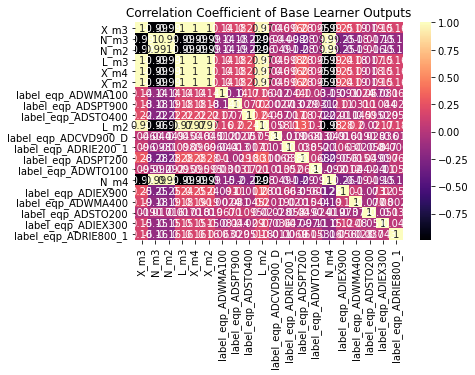

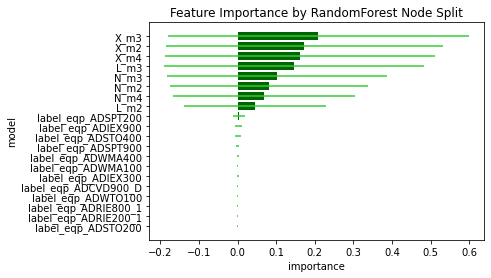

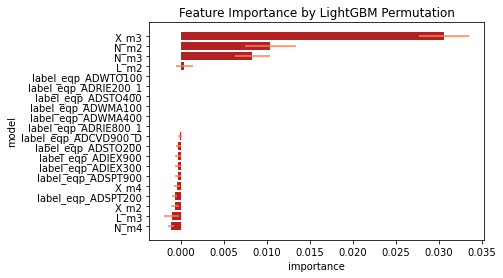

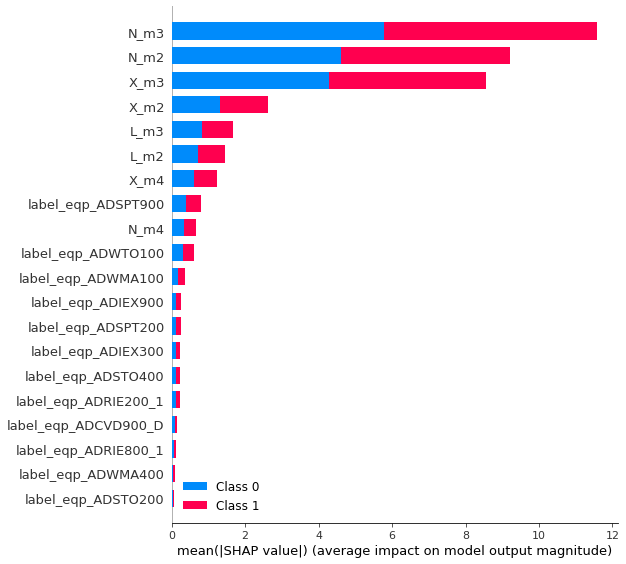

Dataset2:
                        L_m3    L_m4    X_m4   N_m3    X_m2   X_m3    L_m2  \
L_m3                     inf  155.71   78.68  -0.50   82.47  34.84   52.53   
L_m4                  155.71     inf   99.15  -0.50  115.34  33.28   68.45   
X_m4                   78.68   99.15     inf  -0.50  184.54  50.97   99.43   
N_m3                   -0.50   -0.50   -0.50    inf   -0.50  -0.49   -0.49   
X_m2                   82.47  115.34  184.54  -0.50     inf  42.83  115.58   
X_m3                   34.84   33.28   50.97  -0.49   42.83    inf   31.48   
L_m2                   52.53   68.45   99.43  -0.49  115.58  31.48     inf   
N_m2                   -0.50   -0.50   -0.50  94.91   -0.50  -0.49   -0.49   
N_m4                   -0.50   -0.49   -0.50  78.61   -0.50  -0.49   -0.49   
label_eqp_ADIEX600      0.25    0.25    0.25  -0.16    0.26   0.30    0.25   
label_eqp_ADIEXA00     -0.17   -0.17   -0.17   0.24   -0.17  -0.19   -0.16   
label_eqp_ADIEX900      0.17    0.17    0.18  -0.13   

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:00:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 2997, number of negative: 2997
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 5994, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


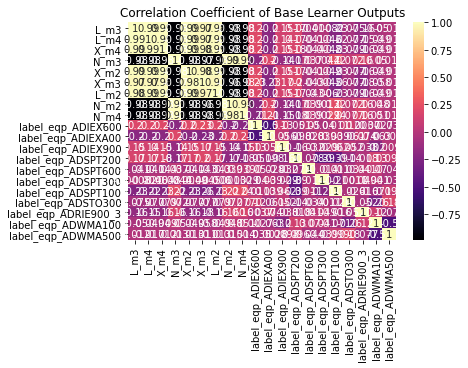

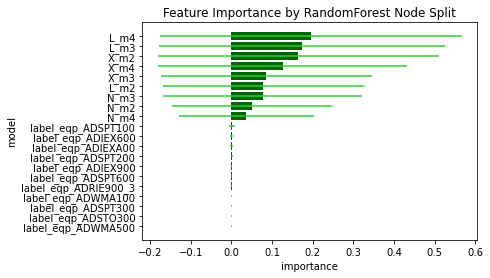

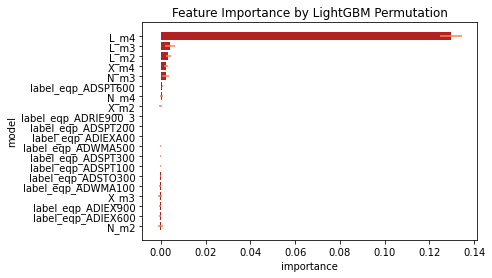

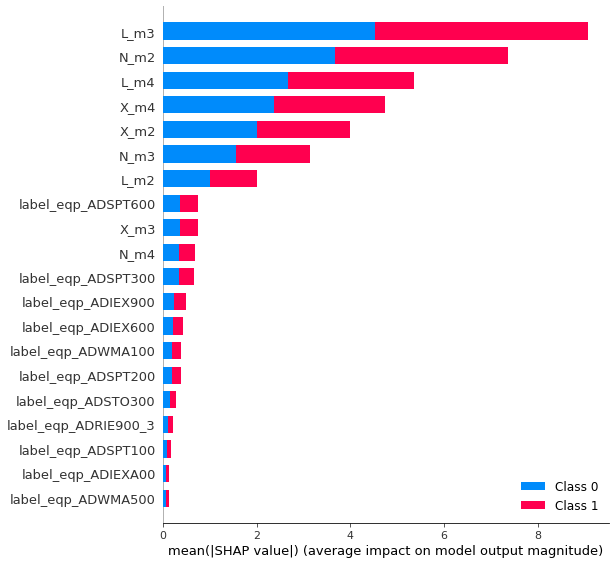

Dataset3:
                        L_m2   N_m2   N_m3   N_m4     X_m4    X_m3     X_m2  \
L_m2                     inf  -0.49  -0.49  -0.49   296.62  155.60   262.32   
N_m2                   -0.49    inf  73.94  65.15    -0.49   -0.49    -0.49   
N_m3                   -0.49  73.94    inf  58.30    -0.49   -0.49    -0.49   
N_m4                   -0.49  65.15  58.30    inf    -0.49   -0.49    -0.49   
X_m4                  296.62  -0.49  -0.49  -0.49      inf  433.37  1402.65   
X_m3                  155.60  -0.49  -0.49  -0.49   433.37     inf   354.90   
X_m2                  262.32  -0.49  -0.49  -0.49  1402.65  354.90      inf   
L_m3                  401.63  -0.49  -0.49  -0.49   381.64  240.61   320.51   
L_m4                  144.63  -0.49  -0.49  -0.49   193.64  178.37   180.67   
label_eqp_ADSTO100     -0.02   0.02   0.02   0.02    -0.02   -0.02    -0.02   
label_eqp_ADCVD900_C   -0.03   0.03   0.04   0.03    -0.03   -0.03    -0.03   
label_eqp_ADWMA200     -0.05   0.07   0.06

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:00:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3033, number of negative: 3033
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 6066, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


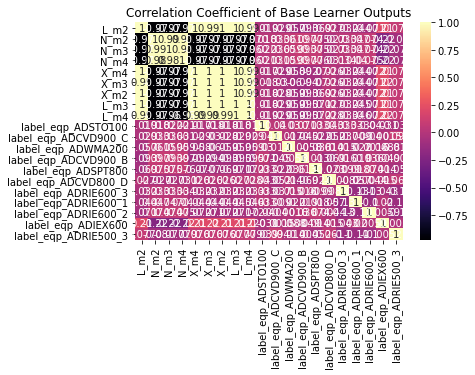

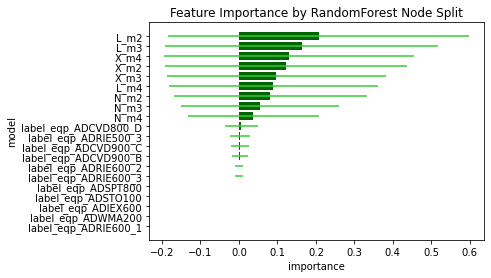

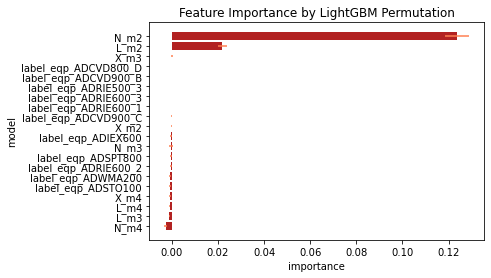

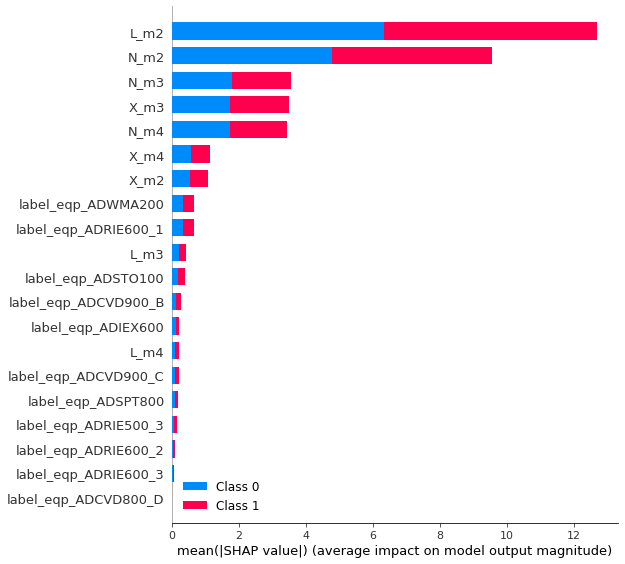

Dataset4:
                        X_m4    X_m2   N_m3    X_m3    L_m2    L_m3   N_m4  \
X_m4                     inf  572.74  -0.50  153.23  118.14  264.48  -0.50   
X_m2                  572.74     inf  -0.50  159.73  114.45  243.54  -0.50   
N_m3                   -0.50   -0.50    inf   -0.50   -0.50   -0.50  94.16   
X_m3                  153.23  159.73  -0.50     inf   74.72  120.52  -0.50   
L_m2                  118.14  114.45  -0.50   74.72     inf   94.94  -0.50   
L_m3                  264.48  243.54  -0.50  120.52   94.94     inf  -0.50   
N_m4                   -0.50   -0.50  94.16   -0.50   -0.50   -0.50    inf   
L_m4                  101.56  102.58  -0.50   64.89  186.37   85.57  -0.50   
N_m2                   -0.50   -0.50  57.43   -0.49   -0.50   -0.49  73.68   
label_eqp_ADRIE200_1    0.17    0.17  -0.13    0.17    0.18    0.17  -0.13   
label_eqp_ADRIE500_3    0.25    0.25  -0.17    0.24    0.26    0.24  -0.17   
label_eqp_ADSPT100     -0.23   -0.23   0.45   -0.23   

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:00:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3038, number of negative: 3038
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 6076, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


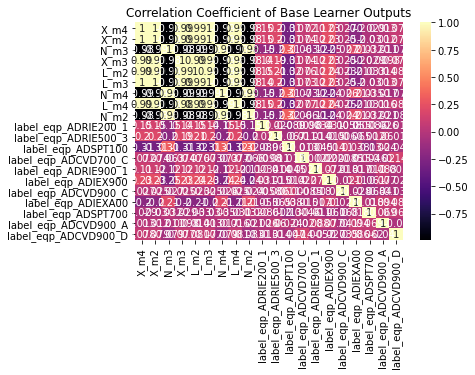

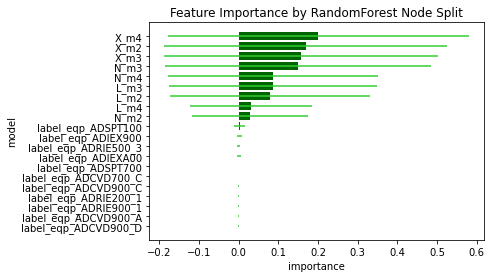

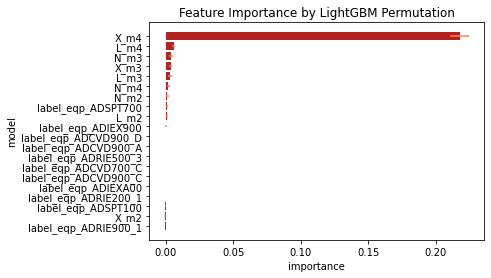

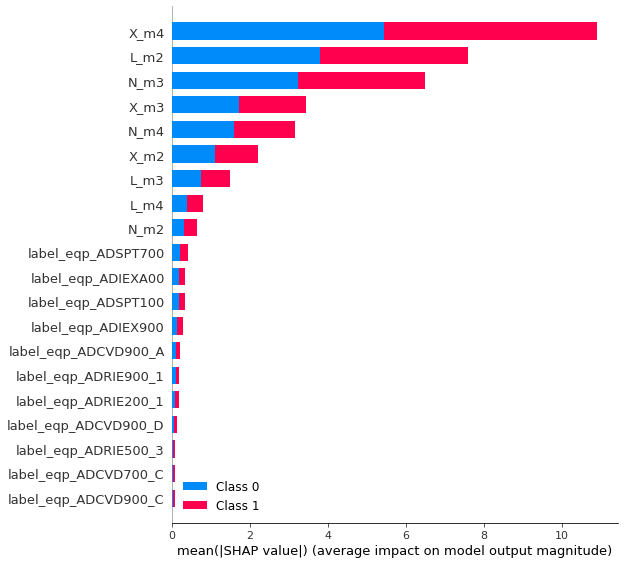

Dataset5:
                        L_m2    X_m3   N_m3    X_m4    N_m2    N_m4    X_m2  \
L_m2                     inf  170.29  -0.50  322.06   -0.50   -0.50  218.78   
X_m3                  170.29     inf  -0.50  359.77   -0.50   -0.50  276.19   
N_m3                   -0.50   -0.50    inf   -0.50   60.62   76.52   -0.50   
X_m4                  322.06  359.77  -0.50     inf   -0.50   -0.50  553.09   
N_m2                   -0.50   -0.50  60.62   -0.50     inf  134.54   -0.50   
N_m4                   -0.50   -0.50  76.52   -0.50  134.54     inf   -0.50   
X_m2                  218.78  276.19  -0.50  553.09   -0.50   -0.50     inf   
L_m3                  160.69  195.80  -0.50  303.53   -0.50   -0.50  205.06   
L_m4                   29.87   36.18  -0.49   37.74   -0.49   -0.50   38.57   
label_eqp_ADSPT200      0.34    0.35  -0.20    0.34   -0.21   -0.21    0.34   
label_eqp_ADCVD900_D    0.04    0.04  -0.04    0.04   -0.03   -0.03    0.04   
label_eqp_ADWMA400      0.28    0.28  -0.1

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:00:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3020, number of negative: 3040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 6060, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498350 -> initscore=-0.006601
[LightGBM] [Info] Start training from score -0.006601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


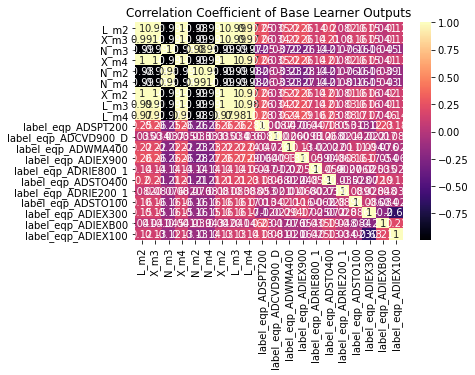

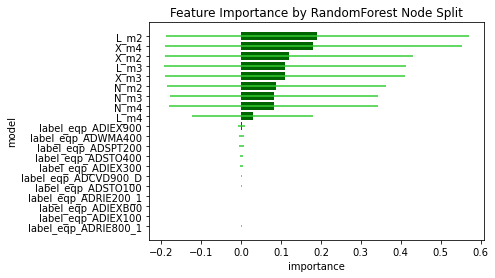

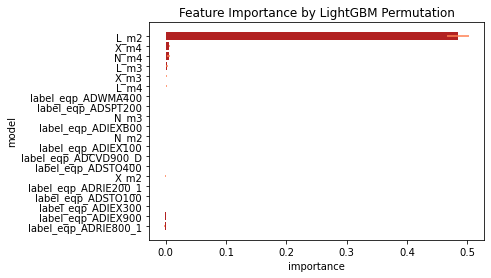

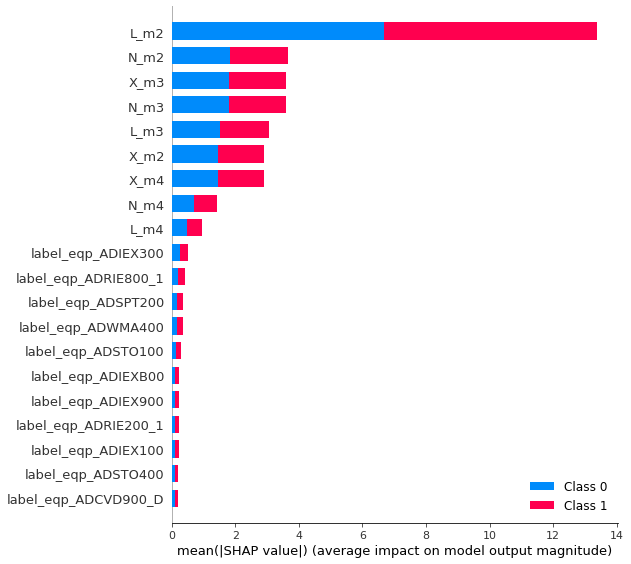

Dataset6:
                        X_m4   L_m2    N_m3   L_m3   L_m4    X_m3    X_m2  \
X_m4                     inf  49.21   -0.50  48.31  33.04  198.62  110.16   
L_m2                   49.21    inf   -0.50  37.03  87.89   55.31   38.10   
N_m3                   -0.50  -0.50     inf  -0.49  -0.50   -0.50   -0.49   
L_m3                   48.31  37.03   -0.49    inf  36.47   59.38   41.46   
L_m4                   33.04  87.89   -0.50  36.47    inf   39.46   28.76   
X_m3                  198.62  55.31   -0.50  59.38  39.46     inf  124.73   
X_m2                  110.16  38.10   -0.49  41.46  28.76  124.73     inf   
N_m4                   -0.50  -0.50  164.86  -0.49  -0.50   -0.50   -0.49   
label_eqp_ADSPT400     -0.02  -0.02    0.01  -0.01  -0.01   -0.02   -0.02   
label_eqp_ADSTO200     -0.11  -0.11    0.14  -0.11  -0.11   -0.11   -0.10   
label_eqp_ADIEX300      0.04   0.04   -0.04   0.04   0.04    0.04    0.04   
label_eqp_ADWMA200     -0.03  -0.03    0.04  -0.03  -0.03   -0.03 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:00:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 2990, number of negative: 3040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 6030, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495854 -> initscore=-0.016584
[LightGBM] [Info] Start training from score -0.016584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


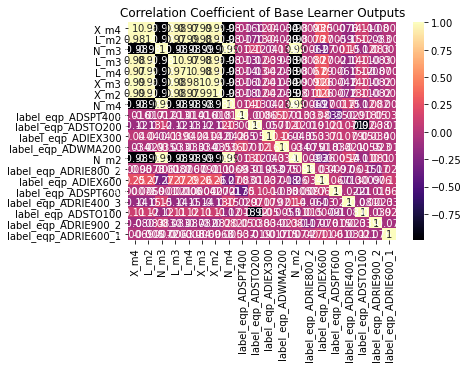

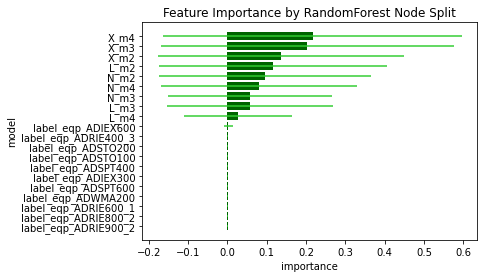

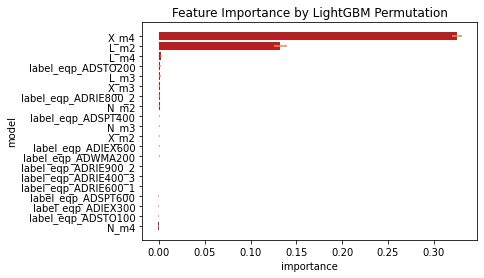

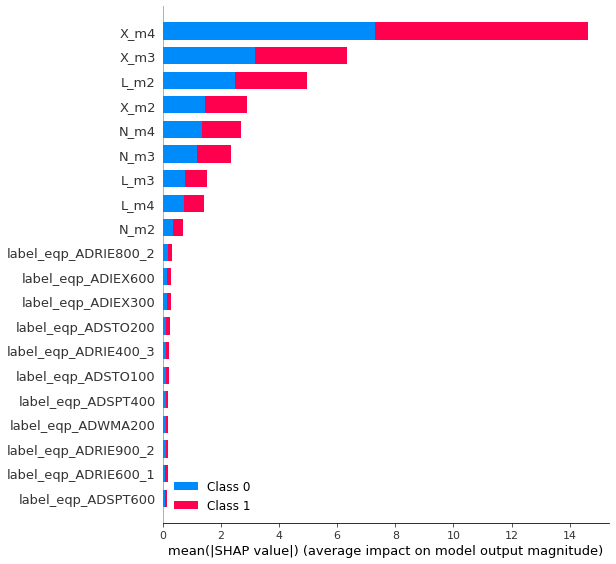

Dataset7:
                        L_m4   N_m3   N_m2   N_m4    X_m4    X_m2    L_m2  \
L_m4                     inf  -0.49  -0.49  -0.49  119.71  225.81  147.97   
N_m3                   -0.49    inf  46.86  62.27   -0.49   -0.49   -0.49   
N_m2                   -0.49  46.86    inf  51.99   -0.49   -0.49   -0.49   
N_m4                   -0.49  62.27  51.99    inf   -0.49   -0.49   -0.49   
X_m4                  119.71  -0.49  -0.49  -0.49     inf  313.92  224.06   
X_m2                  225.81  -0.49  -0.49  -0.49  313.92     inf  411.26   
L_m2                  147.97  -0.49  -0.49  -0.49  224.06  411.26     inf   
L_m3                  318.24  -0.49  -0.49  -0.49  218.56  345.93  315.26   
X_m3                   97.90  -0.49  -0.49  -0.49  793.22  214.37  178.52   
label_eqp_ADRIE500_1   -0.04   0.04   0.04   0.04   -0.04   -0.04   -0.04   
label_eqp_ADIEX700     -0.02   0.03   0.03   0.02   -0.02   -0.02   -0.02   
label_eqp_ADSPT100     -0.19   0.33   0.34   0.32   -0.19   -0.19 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:01:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 2765, number of negative: 3040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 5805, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476314 -> initscore=-0.094817
[LightGBM] [Info] Start training from score -0.094817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


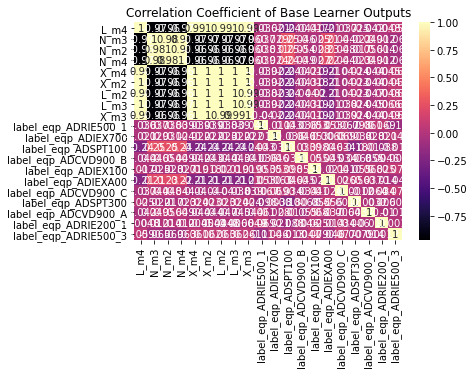

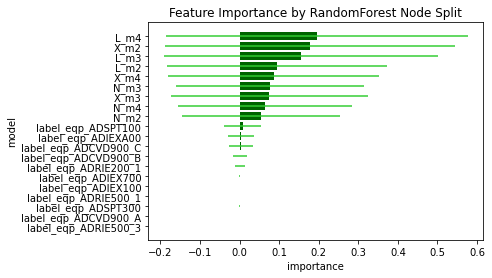

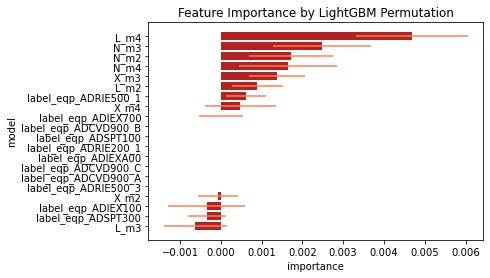

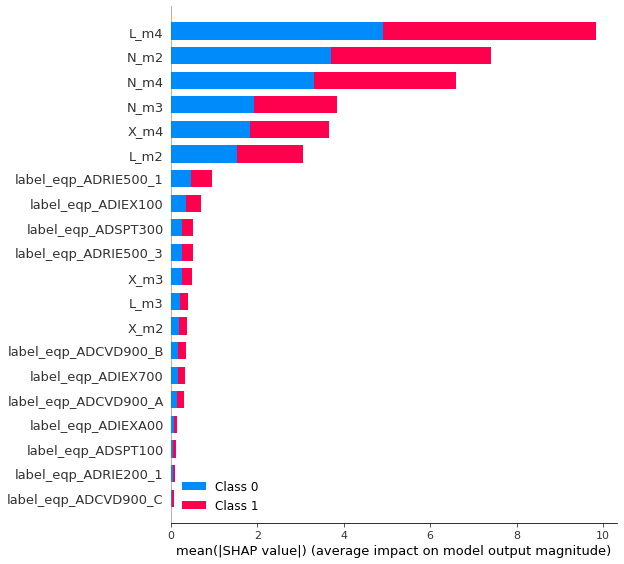

Dataset8:
                        X_m2    X_m3   N_m4    X_m4   L_m2    L_m4   N_m2  \
X_m2                     inf  361.00  -0.50  363.04  15.57  139.89  -0.50   
X_m3                  361.00     inf  -0.50  431.55  15.17  135.70  -0.50   
N_m4                   -0.50   -0.50    inf   -0.50  -0.48   -0.50  97.25   
X_m4                  363.04  431.55  -0.50     inf  16.56  193.28  -0.50   
L_m2                   15.57   15.17  -0.48   16.56    inf   22.88  -0.48   
L_m4                  139.89  135.70  -0.50  193.28  22.88     inf  -0.50   
N_m2                   -0.50   -0.50  97.25   -0.50  -0.48   -0.50    inf   
L_m3                  118.70  116.83  -0.50  147.21  18.14  138.58  -0.50   
N_m3                   -0.50   -0.50  85.30   -0.50  -0.48   -0.50  78.81   
label_eqp_ADSPT900      0.18    0.18  -0.13    0.18   0.21    0.19  -0.13   
label_eqp_ADIEX900      0.29    0.29  -0.19    0.30   0.38    0.31  -0.19   
label_eqp_ADRIE400_3   -0.07   -0.07   0.08   -0.07  -0.09   -0.07

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3040, number of negative: 3040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 6080, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


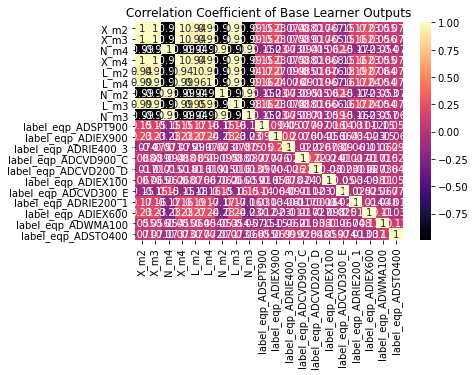

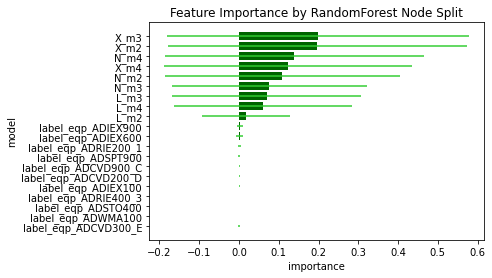

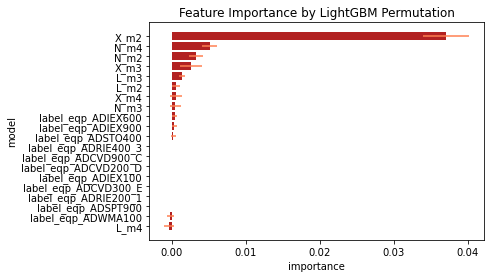

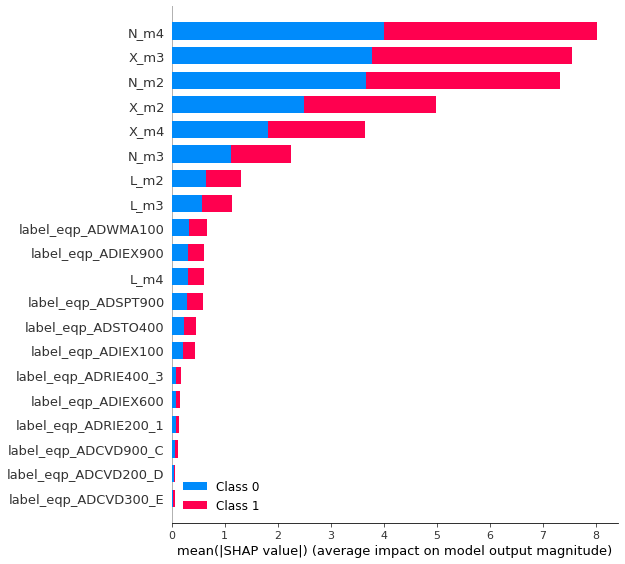

Dataset9:
                       X_m2   N_m3  L_m3   N_m4   L_m2   X_m3   X_m4   L_m4  \
X_m2                    inf  -0.47  7.11  -0.48  37.06  46.38  87.45  41.98   
N_m3                  -0.47    inf -0.47  24.35  -0.47  -0.47  -0.47  -0.47   
L_m3                   7.11  -0.47   inf  -0.46   6.08   8.82   6.65   7.04   
N_m4                  -0.48  24.35 -0.46    inf  -0.48  -0.48  -0.48  -0.47   
L_m2                  37.06  -0.47  6.08  -0.48    inf  21.94  50.15  25.58   
X_m3                  46.38  -0.47  8.82  -0.48  21.94    inf  44.90  45.84   
X_m4                  87.45  -0.47  6.65  -0.48  50.15  44.90    inf  54.29   
L_m4                  41.98  -0.47  7.04  -0.47  25.58  45.84  54.29    inf   
label_eqp_ADCVD900_A  -0.02   0.00 -0.04  -0.00  -0.02  -0.01  -0.02  -0.02   
N_m2                  -0.38   2.98 -0.43   2.29  -0.39  -0.39  -0.38  -0.38   
label_eqp_ADCVD900_D  -0.03   0.04 -0.05   0.03  -0.03  -0.03  -0.03  -0.03   
label_eqp_ADSTO100     0.06  -0.08  0.11  

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:01:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 304, number of negative: 3040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 3344, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


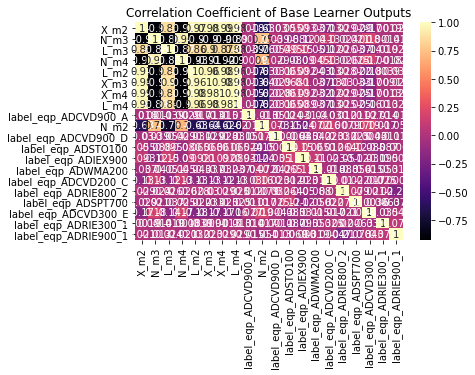

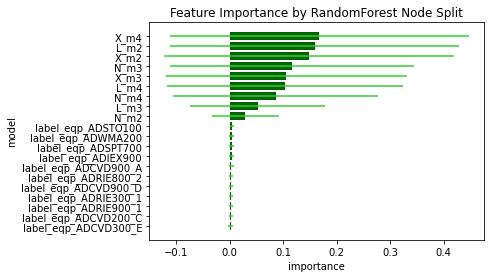

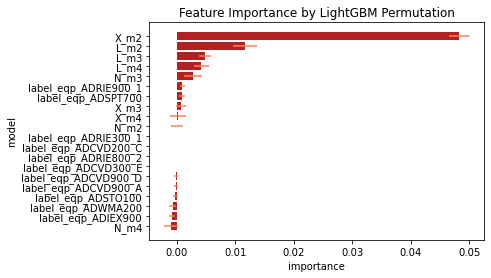

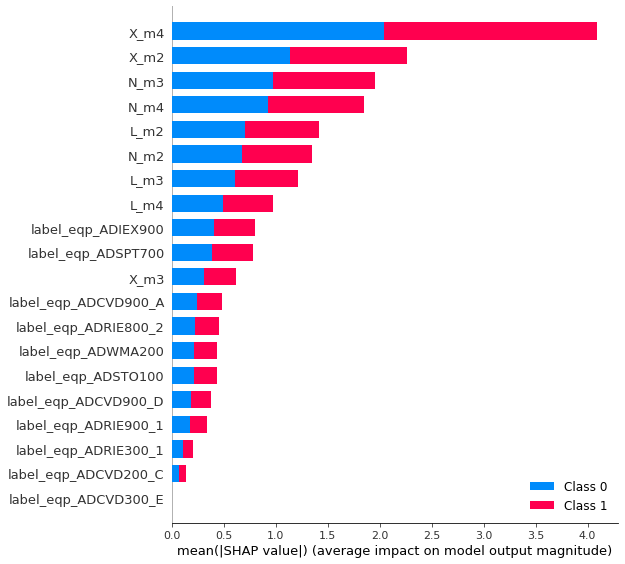

In [38]:
rank_dict = {}
for i in list(train_firstC.keys())[:-1]:
    print(f'Data{i}:')
    rank_dict[i] = rank_importance(train_firstC[i], mode = 'C')
    top_30 = rank_dict[i].index.values[:10]
    add_30 = np.append(top_30, 'GB')
    train_firstC[i] = train_firstC[i][add_30]
    test_firstC[i] = test_firstC[i][add_30]

### Search for The Best Hyperparameters

In [45]:
best_paramC, all_scoreC = all_optuna(all_data = train_firstC, 
                            mode = 'C', 
                            TPE_multi = False, 
                            n_iter = 10,
                            filename = f'runhist_array_m2m4_m5_3criteria_StackingCV2_XNL',
                            creator = stackingCV_creator
)

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-21 14:35:56,109] A new study created in memory with name: no-name-b1f7bfdb-f168-4433-b4c9-22506fd5552d


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9856396866840731 
Recall: 0.984354628422425 
Aging Rate: 0.49934810951760106


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9947780678851175 
Recall: 0.9934810951760105 
Aging Rate: 0.49934810951760106
[I 2022-03-21 14:35:57,809] Trial 0 finished with value: 0.9913013216064113 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.9913013216064113.


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9947848761408083 
Recall: 0.9947848761408083 
Aging Rate: 0.5


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9883570504527813 
Recall: 0.9960886571056062 
Aging Rate: 0.5039113428943938


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9960474308300395 
Recall: 0.9856584093872229 
Aging Rate: 0.49478487614080835
[I 2022-03-21 14:35:59,262] Trial 1 finished with value: 0.9926061188073317 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 1 with value: 0.9926061188073317.
Precision: 0.9934296977660972 
Recall: 0.9856584093872229 
Aging Rate: 0.49608865710560623
Precision: 0.9908496732026144 
Recall: 0.9882659713168188 
Aging Rate: 0.49869621903520206
Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
[I 2022-03-21 14:36:00,692] Trial 2 finished with value: 0.9904207485976553 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 1 with value: 0.9926061188073317.
Precision: 0.990909090909091 
Recall: 0.9947848761408083 
Aging Rate: 0.5019556714471969
Precision: 0.9895833333333334 
Recall: 0.9908735332464146 
Aging Rate: 0.500651890482399
Precision: 0.9908854166666666 
Recall: 0.9921773142112125

Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Aging Rate: 0.500651890482399


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.993455497382199 
Recall: 0.9895697522816167 
Aging Rate: 0.4980443285528031


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9921671018276762 
Recall: 0.9908735332464146 
Aging Rate: 0.49934810951760106
[I 2022-03-21 14:36:03,593] Trial 4 finished with value: 0.9923885070710802 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.9926061188073317.
Precision: 0.994750656167979 
Recall: 0.9882659713168188 
Aging Rate: 0.49674054758800523
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
Precision: 0.9934383202099738 
Recall: 0.9869621903520208 
Aging Rate: 0.49674054758800523
[I 2022-03-21 14:36:05,025] Trial 5 finished with value: 0.991503968147311 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 1 with value: 0.9926061188073317.
Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
Precision: 0.9960732984293194 
Recall: 0.9921773142112125 
Aging Rate: 0.4980443285528031
Precision: 0.9986859395532195 
Recall: 0.9908735332464146

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.994750656167979 
Recall: 0.9882659713168188 
Aging Rate: 0.49674054758800523
Precision: 0.9947712418300654 
Recall: 0.9921773142112125 
Aging Rate: 0.49869621903520206
[I 2022-03-21 14:36:06,254] Trial 7 finished with value: 0.9934680285776354 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 6 with value: 0.9936877337799007.
Precision: 0.9882198952879581 
Recall: 0.984354628422425 
Aging Rate: 0.4980443285528031
Precision: 0.9908854166666666 
Recall: 0.9921773142112125 
Aging Rate: 0.500651890482399
Precision: 0.9934810951760105 
Recall: 0.9934810951760105 
Aging Rate: 0.5
[I 2022-03-21 14:36:06,419] Trial 8 finished with value: 0.9904318382181515 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 6 with value: 0.9936877337799007.
Precision: 0.9947780678851175 
Recall: 0.9934810951760105 
Aging Rate: 0.49934810951760106
Precision: 0.9947437582128777 
Recall: 0.9869621903520208 


[I 2022-03-21 14:36:06,724] A new study created in memory with name: no-name-3e65d155-71b6-4d42-bc72-eb17a308169c


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9841059602649007 
Recall: 0.9906666666666667 
Aging Rate: 0.5033333333333333
Precision: 0.9892183288409704 
Recall: 0.9786666666666667 
Aging Rate: 0.49466666666666664
Precision: 0.9760319573901465 
Recall: 0.9773333333333334 
Aging Rate: 0.5006666666666667
[I 2022-03-21 14:36:06,786] Trial 0 finished with value: 0.9826572787521449 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 0 with value: 0.9826572787521449.
Precision: 0.9892761394101877 
Recall: 0.984 
Aging Rate: 0.49733333333333335


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.986737400530504 
Recall: 0.992 
Aging Rate: 0.5026666666666667
Precision: 0.9814323607427056 
Recall: 0.9866666666666667 
Aging Rate: 0.5026666666666667
[I 2022-03-21 14:36:06,998] Trial 1 finished with value: 0.98667842378731 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.98667842378731.
Precision: 0.9867197875166003 
Recall: 0.9906666666666667 
Aging Rate: 0.502


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9906542056074766 
Recall: 0.9893333333333333 
Aging Rate: 0.49933333333333335
Precision: 0.9906417112299465 
Recall: 0.988 
Aging Rate: 0.49866666666666665
[I 2022-03-21 14:36:07,199] Trial 2 finished with value: 0.98933390303308 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 2 with value: 0.98933390303308.
Precision: 0.9919354838709677 
Recall: 0.984 
Aging Rate: 0.496
Precision: 0.9813829787234043 
Recall: 0.984 
Aging Rate: 0.5013333333333333
Precision: 0.9776609724047306 
Recall: 0.992 
Aging Rate: 0.5073333333333333
[I 2022-03-21 14:36:07,389] Trial 3 finished with value: 0.9851399489181397 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 2 with value: 0.98933390303308.
Precision: 0.9919463087248322 
Recall: 0.9853333333333333 
Aging Rate: 0.49666666666666665


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.986648865153538 
Recall: 0.9853333333333333 
Aging Rate: 0.49933333333333335
Precision: 0.9827814569536424 
Recall: 0.9893333333333333 
Aging Rate: 0.5033333333333333
[I 2022-03-21 14:36:07,582] Trial 4 finished with value: 0.9868886448700022 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 2 with value: 0.98933390303308.
Precision: 0.9802371541501976 
Recall: 0.992 
Aging Rate: 0.506
Precision: 0.9866844207723036 
Recall: 0.988 
Aging Rate: 0.5006666666666667


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9906040268456375 
Recall: 0.984 
Aging Rate: 0.49666666666666665
[I 2022-03-21 14:36:07,779] Trial 5 finished with value: 0.986905413685843 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 2 with value: 0.98933390303308.
Precision: 0.9840848806366048 
Recall: 0.9893333333333333 
Aging Rate: 0.5026666666666667
Precision: 0.9774236387782205 
Recall: 0.9813333333333333 
Aging Rate: 0.502
Precision: 0.9891891891891892 
Recall: 0.976 
Aging Rate: 0.49333333333333335
[I 2022-03-21 14:36:07,970] Trial 6 finished with value: 0.9828756824650159 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 2 with value: 0.98933390303308.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9880478087649402 
Recall: 0.992 
Aging Rate: 0.502
Precision: 0.9906166219839142 
Recall: 0.9853333333333333 
Aging Rate: 0.49733333333333335
Precision: 0.9879839786381842 
Recall: 0.9866666666666667 
Aging Rate: 0.49933333333333335
[I 2022-03-21 14:36:08,171] Trial 7 finished with value: 0.9884375859246156 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 2 with value: 0.98933390303308.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9866131191432396 
Recall: 0.9826666666666667 
Aging Rate: 0.498
Precision: 0.9880636604774535 
Recall: 0.9933333333333333 
Aging Rate: 0.5026666666666667
Precision: 0.9906291834002677 
Recall: 0.9866666666666667 
Aging Rate: 0.498
[I 2022-03-21 14:36:08,382] Trial 8 finished with value: 0.9879904608270914 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 2 with value: 0.98933390303308.
Precision: 0.9827814569536424 
Recall: 0.9893333333333333 
Aging Rate: 0.5033333333333333


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
[I 2022-03-21 14:36:08,705] A new study created in memory with name: no-name-13e43425-00d9-4460-ab3d-45ea61104c07


Precision: 0.9764089121887287 
Recall: 0.9933333333333333 
Aging Rate: 0.5086666666666667
Precision: 0.9892904953145917 
Recall: 0.9853333333333333 
Aging Rate: 0.498
[I 2022-03-21 14:36:08,588] Trial 9 finished with value: 0.9860509582024083 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 2 with value: 0.98933390303308.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9947089947089947 
Recall: 0.9907773386034255 
Aging Rate: 0.4980237154150198
Precision: 0.9947089947089947 
Recall: 0.9907773386034255 
Aging Rate: 0.4980237154150198
Precision: 0.9973509933774835 
Recall: 0.9920948616600791 
Aging Rate: 0.497364953886693
[I 2022-03-21 14:36:08,821] Trial 0 finished with value: 0.993398177334246 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.993398177334246.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9934123847167325 
Recall: 0.9934123847167325 
Aging Rate: 0.5
Precision: 0.9933862433862434 
Recall: 0.9894598155467721 
Aging Rate: 0.4980237154150198
Precision: 0.9882044560943644 
Recall: 0.9934123847167325 
Aging Rate: 0.502635046113307
[I 2022-03-21 14:36:09,030] Trial 1 finished with value: 0.99187770116782 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.993398177334246.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9960106382978723 
Recall: 0.9868247694334651 
Aging Rate: 0.49538866930171277
Precision: 0.996042216358839 
Recall: 0.994729907773386 
Aging Rate: 0.4993412384716733
Precision: 0.9947089947089947 
Recall: 0.9907773386034255 
Aging Rate: 0.4980237154150198
[I 2022-03-21 14:36:09,231] Trial 2 finished with value: 0.9931737765557243 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 0.993398177334246.
Precision: 0.993421052631579 
Recall: 0.994729907773386 
Aging Rate: 0.5006587615283268
Precision: 0.9894875164257556 
Recall: 0.9920948616600791 
Aging Rate: 0.5013175230566534
Precision: 0.9947368421052631 
Recall: 0.9960474308300395 
Aging Rate: 0.5006587615283268
[I 2022-03-21 14:36:09,409] Trial 3 finished with value: 0.993418742709308 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 3 with value: 0.993418742709308.
Precision: 0.996031746031746 
Recall: 0.992094861

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9894875164257556 
Recall: 0.9920948616600791 
Aging Rate: 0.5013175230566534
Precision: 0.9973509933774835 
Recall: 0.9920948616600791 
Aging Rate: 0.497364953886693
[I 2022-03-21 14:36:09,608] Trial 4 finished with value: 0.9931882879242524 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 3 with value: 0.993418742709308.
Precision: 0.996005326231691 
Recall: 0.9855072463768116 
Aging Rate: 0.49472990777338605
Precision: 0.9907407407407407 
Recall: 0.9868247694334651 
Aging Rate: 0.4980237154150198
Precision: 0.9920634920634921 
Recall: 0.9881422924901185 
Aging Rate: 0.4980237154150198
[I 2022-03-21 14:36:09,790] Trial 5 finished with value: 0.9898687882033236 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 3 with value: 0.993418742709308.
Precision: 0.9908136482939632 
Recall: 0.994729907773386 
Aging Rate: 0.5019762845849802


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9934036939313984 
Recall: 0.9920948616600791 
Aging Rate: 0.4993412384716733
Precision: 0.9921156373193167 
Recall: 0.994729907773386 
Aging Rate: 0.5013175230566534
[I 2022-03-21 14:36:09,983] Trial 6 finished with value: 0.9929792716279335 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 3 with value: 0.993418742709308.
Precision: 0.9960106382978723 
Recall: 0.9868247694334651 
Aging Rate: 0.49538866930171277


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9934296977660972 
Recall: 0.9960474308300395 
Aging Rate: 0.5013175230566534
Precision: 0.9894875164257556 
Recall: 0.9920948616600791 
Aging Rate: 0.5013175230566534
[I 2022-03-21 14:36:10,184] Trial 7 finished with value: 0.9923075806657611 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 3 with value: 0.993418742709308.
Precision: 0.9895150720838795 
Recall: 0.994729907773386 
Aging Rate: 0.502635046113307
Precision: 0.9933862433862434 
Recall: 0.9894598155467721 
Aging Rate: 0.4980237154150198
Precision: 0.9960264900662251 
Recall: 0.9907773386034255 
Aging Rate: 0.497364953886693
[I 2022-03-21 14:36:10,394] Trial 8 finished with value: 0.9923099198061495 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 3 with value: 0.993418742709308.
Precision: 0.9895424836601308 
Recall: 0.997364953886693 
Aging Rate: 0.5039525691699605


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
[I 2022-03-21 14:36:10,731] A new study created in memory with name: no-name-5f03dad5-49aa-4d5e-9a17-a99b6065ff36


Precision: 0.9947089947089947 
Recall: 0.9907773386034255 
Aging Rate: 0.4980237154150198
Precision: 0.988173455978975 
Recall: 0.9907773386034255 
Aging Rate: 0.5013175230566534
[I 2022-03-21 14:36:10,616] Trial 9 finished with value: 0.9918837594492976 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 3 with value: 0.993418742709308.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9868766404199475 
Recall: 0.9894736842105263 
Aging Rate: 0.5013157894736842
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
Precision: 0.9868247694334651 
Recall: 0.9855263157894737 
Aging Rate: 0.4993421052631579
[I 2022-03-21 14:36:10,813] Trial 0 finished with value: 0.9870403526529451 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9870403526529451.
Precision: 0.9880794701986755 
Recall: 0.9815789473684211 
Aging Rate: 0.4967105263157895
Precision: 0.9907038512616202 
Recall: 0.9815789473684211 
Aging Rate: 0.4953947368421053
Precision: 0.9803664921465969 
Recall: 0.9855263157894737 
Aging Rate: 0.5026315789473684
[I 2022-03-21 14:36:10,987] Trial 1 finished with value: 0.9846261350690236 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 0 with value: 0.9870403526529451.
Precision: 0.996005326231691 
Recall: 0.984210

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
[I 2022-03-21 14:36:11,192] Trial 2 finished with value: 0.9900765817464666 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 2 with value: 0.9900765817464666.
Precision: 0.9816993464052287 
Recall: 0.9881578947368421 
Aging Rate: 0.5032894736842105
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
[I 2022-03-21 14:36:11,412] Trial 3 finished with value: 0.9868181881677307 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 2 with value: 0.9900765817464666.
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9893758300132802 
Recall: 0.9802631578947368 
Aging Rate: 0.4953947368421053
Precision: 0.985545335085414 
Recall: 0.9868421052631579 
Aging Rate: 0.5006578947368421
[I 2022-03-21 14:36:11,630] Trial 4 finished with value: 0.9863570592772662 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 2 with value: 0.9900765817464666.
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9880794701986755 
Recall: 0.9815789473684211 
Aging Rate: 0.4967105263157895
Precision: 0.9920212765957447 
Recall: 0.981

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
[I 2022-03-21 14:36:12,064] Trial 6 finished with value: 0.9857516080071047 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 2 with value: 0.9900765817464666.
Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
Precision: 0.9894319682959049 
Recall: 0.9855263157894737 
Aging Rate: 0.4980263157894737


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9881266490765171 
Recall: 0.9855263157894737 
Aging Rate: 0.4986842105263158
[I 2022-03-21 14:36:12,270] Trial 7 finished with value: 0.9876929758264871 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 2 with value: 0.9900765817464666.
Precision: 0.9854881266490765 
Recall: 0.9828947368421053 
Aging Rate: 0.4986842105263158
Precision: 0.9894179894179894 
Recall: 0.9842105263157894 
Aging Rate: 0.49736842105263157
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
[I 2022-03-21 14:36:12,446] Trial 8 finished with value: 0.9865771240943403 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 2 with value: 0.9900765817464666.
Precision: 0.9920739762219286 
Recall: 0.9881578947368421 
Aging Rate: 0.4980263157894737
Precision: 0.9908136482939632 
Recall: 0.993421052631579 
Aging Rate: 0.5013157894736842


[I 2022-03-21 14:36:12,777] A new study created in memory with name: no-name-da595c8a-0468-47b1-b693-a0619df1977e


Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
[I 2022-03-21 14:36:12,652] Trial 9 finished with value: 0.9907668333575536 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 9 with value: 0.9907668333575536.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9907161803713528 
Recall: 0.9894039735099338 
Aging Rate: 0.4976897689768977


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.993368700265252 
Recall: 0.9920529801324504 
Aging Rate: 0.4976897689768977
Precision: 0.9869109947643979 
Recall: 0.9986754966887417 
Aging Rate: 0.5042904290429043
[I 2022-03-21 14:36:12,889] Trial 0 finished with value: 0.9918428133561298 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 0.9918428133561298.
Precision: 0.9947229551451188 
Recall: 0.9986754966887417 
Aging Rate: 0.5003300330033004
Precision: 0.9868073878627969 
Recall: 0.990728476821192 
Aging Rate: 0.5003300330033004
Precision: 0.9933862433862434 
Recall: 0.9947019867549669 
Aging Rate: 0.499009900990099
[I 2022-03-21 14:36:13,072] Trial 1 finished with value: 0.9931676773208559 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 1 with value: 0.9931676773208559.
Precision: 0.9894459102902374 
Recall: 0.9933774834437086 
Aging Rate: 

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


0.5003300330033004
Precision: 0.9920948616600791 
Recall: 0.9973509933774835 
Aging Rate: 0.500990099009901
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
[I 2022-03-21 14:36:13,282] Trial 2 finished with value: 0.9936085899925352 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 2 with value: 0.9936085899925352.
Precision: 0.9920844327176781 
Recall: 0.9960264900662251 
Aging Rate: 0.5003300330033004


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933949801849405 
Recall: 0.9960264900662251 
Aging Rate: 0.4996699669966997
Precision: 0.9882044560943644 
Recall: 0.9986754966887417 
Aging Rate: 0.5036303630363036
[I 2022-03-21 14:36:13,481] Trial 3 finished with value: 0.9940576442104264 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 3 with value: 0.9940576442104264.
Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9920739762219286 
Recall: 0.9947019867549669 
Aging Rate: 0.4996699669966997
Precision: 0.9894179894179894 
Recall: 0.990728476821192 
Aging Rate: 0.499009900990099
[I 2022-03-21 14:36:13,686] Trial 4 finished with value: 0.9918408449734283 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 3 with value: 0.9940576442104264.
Precision: 0.9933949801849405 
Recall: 0.9960264900662251 
Aging Rate: 0.4996699669966997
Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
Precision: 0.9920844327176781 
Recall: 0.9960264900662251 
Aging Rate: 0.5003300330033004
[I 2022-03-21 14:36:13,868] Trial 5 finished with value: 0.9933856580407854 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 3 with value: 0.9940576442104264.
Precision: 0.9934036939313984 
Recall: 0.9973509933774835 
Aging Rate: 0.5003300330033004
Precision: 0.9973474801061007 
Recall: 0.996026

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


 0.4957095709570957
Precision: 0.9894736842105263 
Recall: 0.9960264900662251 
Aging Rate: 0.5016501650165016
Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
[I 2022-03-21 14:36:14,286] Trial 7 finished with value: 0.9925002741924907 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 3 with value: 0.9940576442104264.
Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
Precision: 0.9894598155467721 
Recall: 0.9947019867549669 
Aging Rate: 0.500990099009901
Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
[I 2022-03-21 14:36:14,493] Trial 8 finished with value: 0.9920666928566191 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 3 with value: 0.9940576442104264.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
[I 2022-03-21 14:36:14,828] A new study created in memory with name: no-name-1c054b85-1b10-42f5-9c57-e0d1f1537ffd


Precision: 0.993368700265252 
Recall: 0.9920529801324504 
Aging Rate: 0.4976897689768977
Precision: 0.9920739762219286 
Recall: 0.9947019867549669 
Aging Rate: 0.4996699669966997
Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
[I 2022-03-21 14:36:14,700] Trial 9 finished with value: 0.9929389001908441 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 3 with value: 0.9940576442104264.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9802371541501976 
Recall: 0.9946524064171123 
Aging Rate: 0.503315649867374
Precision: 0.988031914893617 
Recall: 0.9933155080213903 
Aging Rate: 0.4986737400530504
Precision: 0.9893333333333333 
Recall: 0.9919786096256684 
Aging Rate: 0.4973474801061008
[I 2022-03-21 14:36:14,930] Trial 0 finished with value: 0.9895710140493549 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 0 with value: 0.9895710140493549.
Precision: 0.9893190921228304 
Recall: 0.9906417112299465 
Aging Rate: 0.496684350132626


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9867197875166003 
Recall: 0.9933155080213903 
Aging Rate: 0.4993368700265252
Precision: 0.9866310160427807 
Recall: 0.9866310160427807 
Aging Rate: 0.4960212201591512
[I 2022-03-21 14:36:15,136] Trial 1 finished with value: 0.9888725460626011 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.9895710140493549.
Precision: 0.9893617021276596 
Recall: 0.9946524064171123 
Aging Rate: 0.4986737400530504
Precision: 0.9919463087248322 
Recall: 0.9879679144385026 
Aging Rate: 0.49403183023872677
Precision: 0.9893190921228304 
Recall: 0.9906417112299465 
Aging Rate: 0.496684350132626
[I 2022-03-21 14:36:15,326] Trial 2 finished with value: 0.9906443581514446 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 2 with value: 0.9906443581514446.
Precision: 0.9892761394101877 
Recall: 0.9866310160427807 
Aging Rate: 0.4946949602122016
Precision: 0.9814077025232404 
Recall: 0.9879

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.983957219251337 
Recall: 0.983957219251337 
Aging Rate: 0.4960212201591512
Precision: 0.9788079470198675 
Recall: 0.9879679144385026 
Aging Rate: 0.5006631299734748
Precision: 0.9919354838709677 
Recall: 0.9866310160427807 
Aging Rate: 0.493368700265252
[I 2022-03-21 14:36:16,134] Trial 6 finished with value: 0.9855333195981973 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 2 with value: 0.9906443581514446.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9827127659574468 
Recall: 0.9879679144385026 
Aging Rate: 0.4986737400530504
Precision: 0.9866844207723036 
Recall: 0.9906417112299465 
Aging Rate: 0.4980106100795756
Precision: 0.9853528628495339 
Recall: 0.9893048128342246 
Aging Rate: 0.4980106100795756
[I 2022-03-21 14:36:16,348] Trial 7 finished with value: 0.9871057742198502 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 2 with value: 0.9906443581514446.
Precision: 0.9879518072289156 
Recall: 0.9866310160427807 
Aging Rate: 0.4953580901856764
Precision: 0.9853333333333333 
Recall: 0.9879679144385026 
Aging Rate: 0.4973474801061008
Precision: 0.9892617449664429 
Recall: 0.9852941176470589 
Aging Rate: 0.49403183023872677
[I 2022-03-21 14:36:16,553] Trial 8 finished with value: 0.9870712600434098 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 2 with value: 0.9906443581514446.
Precision: 0.9893048128342246 
Recall: 0.98

[I 2022-03-21 14:36:16,900] A new study created in memory with name: no-name-99902bb0-d1dc-4a60-b382-4f7dbd5cf5bc


Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9899280575539569 
Recall: 0.9942196531791907 
Aging Rate: 0.4786501377410468
Precision: 0.9971098265895953 
Recall: 0.9971098265895953 
Aging Rate: 0.4765840220385675
Precision: 0.9956395348837209 
Recall: 0.9898843930635838 
Aging Rate: 0.4738292011019284
[I 2022-03-21 14:36:16,986] Trial 0 finished with value: 0.9939775546364066 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 0 with value: 0.9939775546364066.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9927536231884058 
Recall: 0.9898843930635838 
Aging Rate: 0.47520661157024796
Precision: 0.9970972423802612 
Recall: 0.9927745664739884 
Aging Rate: 0.47451790633608815
Precision: 0.9913419913419913 
Recall: 0.9927745664739884 
Aging Rate: 0.4772727272727273
[I 2022-03-21 14:36:17,194] Trial 1 finished with value: 0.9927686343280439 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.9939775546364066.
Precision: 0.9956584659913169 
Recall: 0.9942196531791907 
Aging Rate: 0.4758953168044077
Precision: 0.9927536231884058 
Recall: 0.9898843930635838 
Aging Rate: 0.47520661157024796
Precision: 0.9971056439942113 
Recall: 0.9956647398843931 
Aging Rate: 0.4758953168044077
[I 2022-03-21 14:36:17,403] Trial 2 finished with value: 0.9942133807982604 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 2 with value: 0.9942133807982604.
Precision: 0.9971014492753624 
Recall: 0.

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9956647398843931 
Recall: 0.9956647398843931 
Aging Rate: 0.4765840220385675
[I 2022-03-21 14:36:17,989] Trial 5 finished with value: 0.9942133770129685 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 3 with value: 0.994689479849079.
Precision: 0.9971014492753624 
Recall: 0.9942196531791907 
Aging Rate: 0.47520661157024796
Precision: 0.9985443959243085 
Recall: 0.9913294797687862 
Aging Rate: 0.4731404958677686
Precision: 0.9985422740524781 
Recall: 0.9898843930635838 
Aging Rate: 0.4724517906336088
[I 2022-03-21 14:36:18,150] Trial 6 finished with value: 0.9949256028732866 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 6 with value: 0.9949256028732866.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9970887918486172 
Recall: 0.9898843930635838 
Aging Rate: 0.4731404958677686
Precision: 0.9927745664739884 
Recall: 0.9927745664739884 
Aging Rate: 0.4765840220385675
Precision: 0.9913544668587896 
Recall: 0.9942196531791907 
Aging Rate: 0.47796143250688705
[I 2022-03-21 14:36:18,360] Trial 7 finished with value: 0.9930110302678595 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 6 with value: 0.9949256028732866.
Precision: 0.9927953890489913 
Recall: 0.9956647398843931 
Aging Rate: 0.47796143250688705
Precision: 0.9884559884559885 
Recall: 0.9898843930635838 
Aging Rate: 0.4772727272727273
Precision: 0.9985443959243085 
Recall: 0.9913294797687862 
Aging Rate: 0.4731404958677686
[I 2022-03-21 14:36:18,557] Trial 8 finished with value: 0.9927738423954224 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 6 with value: 0.9949256028732866.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
[I 2022-03-21 14:36:18,889] A new study created in memory with name: no-name-41894281-6151-4868-bc0f-6c99c32042a2


Precision: 0.9956647398843931 
Recall: 0.9956647398843931 
Aging Rate: 0.4765840220385675
Precision: 0.9942196531791907 
Recall: 0.9942196531791907 
Aging Rate: 0.4765840220385675
Precision: 0.9956584659913169 
Recall: 0.9942196531791907 
Aging Rate: 0.4758953168044077
[I 2022-03-21 14:36:18,764] Trial 9 finished with value: 0.9949409774902233 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 9 with value: 0.9949409774902233.
Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9920739762219286 
Recall: 0.9881578947368421 
Aging Rate: 0.4980263157894737
Precision: 0.9907773386034255 
Recall: 0.9894736842105263 
Aging Rate: 0.4993421052631579
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
[I 2022-03-21 14:36:18,984] Trial 0 finished with value: 0.9898803730279032 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.9898803730279032.
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.9920948616600791 
Recall: 0.9907894736842106 
Aging Rate: 0.4993421052631579


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9907529722589168 
Recall: 0.9868421052631579 
Aging Rate: 0.4980263157894737
[I 2022-03-21 14:36:19,143] Trial 1 finished with value: 0.9898797944053171 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 0 with value: 0.9898803730279032.
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
Precision: 0.9933862433862434 
Recall: 0.9881578947368421 
Aging Rate: 0.49736842105263157
Precision: 0.9934123847167325 
Recall: 0.9921052631578947 
Aging Rate: 0.4993421052631579
[I 2022-03-21 14:36:19,346] Trial 2 finished with value: 0.9914255124809758 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 2 with value: 0.9914255124809758.
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9959785522788204 
Recall: 0.

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933065595716198 
Recall: 0.9763157894736842 
Aging Rate: 0.49144736842105263
[I 2022-03-21 14:36:20,128] Trial 6 finished with value: 0.9878607606751842 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 2 with value: 0.9914255124809758.
Precision: 0.9947229551451188 
Recall: 0.9921052631578947 
Aging Rate: 0.4986842105263158
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
[I 2022-03-21 14:36:20,298] Trial 7 finished with value: 0.9911897768285277 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 2 with value: 0.9914255124809758.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9960474308300395 
Recall: 0.9947368421052631 
Aging Rate: 0.4993421052631579
Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
Precision: 0.9894875164257556 
Recall: 0.9907894736842106 
Aging Rate: 0.5006578947368421
[I 2022-03-21 14:36:20,500] Trial 8 finished with value: 0.9909851060420992 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 2 with value: 0.9914255124809758.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
[I 2022-03-21 14:36:20,819] A new study created in memory with name: no-name-4f06fb5b-d496-4f21-9958-ca4b8375a2f7


Precision: 0.9894039735099338 
Recall: 0.9828947368421053 
Aging Rate: 0.4967105263157895
Precision: 0.9894736842105263 
Recall: 0.9894736842105263 
Aging Rate: 0.5
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
[I 2022-03-21 14:36:20,691] Trial 9 finished with value: 0.9885704359909675 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 2 with value: 0.9914255124809758.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 

Setting penalty='none' will ignore the C and l1_ratio parameters


0.9166666666666666 
Recall: 0.868421052631579 
Aging Rate: 0.0861244019138756
Precision: 0.9130434782608695 
Recall: 0.8289473684210527 
Aging Rate: 0.08253588516746412
Precision: 0.9682539682539683 
Recall: 0.8026315789473685 
Aging Rate: 0.07535885167464115
[I 2022-03-21 14:36:20,893] Trial 0 finished with value: 0.8795184169532965 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.8795184169532965.
Precision: 0.9571428571428572 
Recall: 0.881578947368421 
Aging Rate: 0.08373205741626795


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9402985074626866 
Recall: 0.8289473684210527 
Aging Rate: 0.08014354066985646
Precision: 0.9295774647887324 
Recall: 0.868421052631579 
Aging Rate: 0.08492822966507177
[I 2022-03-21 14:36:21,090] Trial 1 finished with value: 0.8989620946568109 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 1 with value: 0.8989620946568109.
Precision: 0.9846153846153847 
Recall: 0.8421052631578947 
Aging Rate: 0.07775119617224881
Precision: 0.953125 
Recall: 0.8026315789473685 
Aging Rate: 0.07655502392344497
Precision: 0.922077922077922 
Recall: 0.9342105263157895 
Aging Rate: 0.09210526315789473
[I 2022-03-21 14:36:21,277] Trial 2 finished with value: 0.902444855010562 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 2 with value: 0.902444855010562.
Precision: 1.0 
Recall: 0.7105263157894737 
Aging Rate: 0.0645933014354067
Precision: 1.0 
Recall: 0.75 
Aging Rate: 0.06818181818181818
Precis

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9692307692307692 
Recall: 0.8289473684210527 
Aging Rate: 0.07775119617224881
Precision: 0.8933333333333333 
Recall: 0.881578947368421 
Aging Rate: 0.08971291866028708
Precision: 0.9384615384615385 
Recall: 0.8026315789473685 
Aging Rate: 0.07775119617224881
[I 2022-03-21 14:36:21,630] Trial 4 finished with value: 0.8820941555899989 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 2 with value: 0.902444855010562.
Precision: 1.0 
Recall: 0.6973684210526315 
Aging Rate: 0.06339712918660287
Precision: 0.9811320754716981 
Recall: 0.6842105263157895 
Aging Rate: 0.06339712918660287
Precision: 1.0 
Recall: 0.7105263157894737 
Aging Rate: 0.0645933014354067
[I 2022-03-21 14:36:21,789] Trial 5 finished with value: 0.8195587358378056 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 2 with value: 0.902444855010562.
Precision: 0.9824561403508771 
Recall: 0.7368421052631579 
Aging Rate: 0

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9154929577464789 
Recall: 0.8552631578947368 
Aging Rate: 0.08492822966507177
Precision: 0.9558823529411765 
Recall: 0.8552631578947368 
Aging Rate: 0.08133971291866028
Precision: 0.9466666666666667 
Recall: 0.9342105263157895 
Aging Rate: 0.08971291866028708
[I 2022-03-21 14:36:22,181] Trial 7 finished with value: 0.9091762900892513 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 7 with value: 0.9091762900892513.
Precision: 0.8857142857142857 
Recall: 0.8157894736842105 
Aging Rate: 0.08373205741626795


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9393939393939394 
Recall: 0.8157894736842105 
Aging Rate: 0.07894736842105263
Precision: 0.9295774647887324 
Recall: 0.868421052631579 
Aging Rate: 0.08492822966507177
[I 2022-03-21 14:36:22,378] Trial 8 finished with value: 0.8735045629287793 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 7 with value: 0.9091762900892513.
Precision: 0.92 
Recall: 0.9078947368421053 
Aging Rate: 0.08971291866028708
Precision: 0.9452054794520548 
Recall: 0.9078947368421053 
Aging Rate: 0.08732057416267942
Precision: 0.9444444444444444 
Recall: 0.8947368421052632 
Aging Rate: 0.0861244019138756
[I 2022-03-21 14:36:22,566] Trial 9 finished with value: 0.9196669001104754 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 9 with value: 0.9196669001104754.
Sampler is TPESampler


meta_learner     C penalty
set1  LogisticRegression   0.1      l2
set2  LogisticRegression  0.01    none
set3  LogisticRegression   0.1      l2
set4  LogisticRegression     1      l2
set5  LogisticRegression   100    none
set6  LogisticRegression    10      l2
set7  LogisticRegression   0.1    none
set8  LogisticRegression   0.1    none
set9  LogisticRegression   100      l2

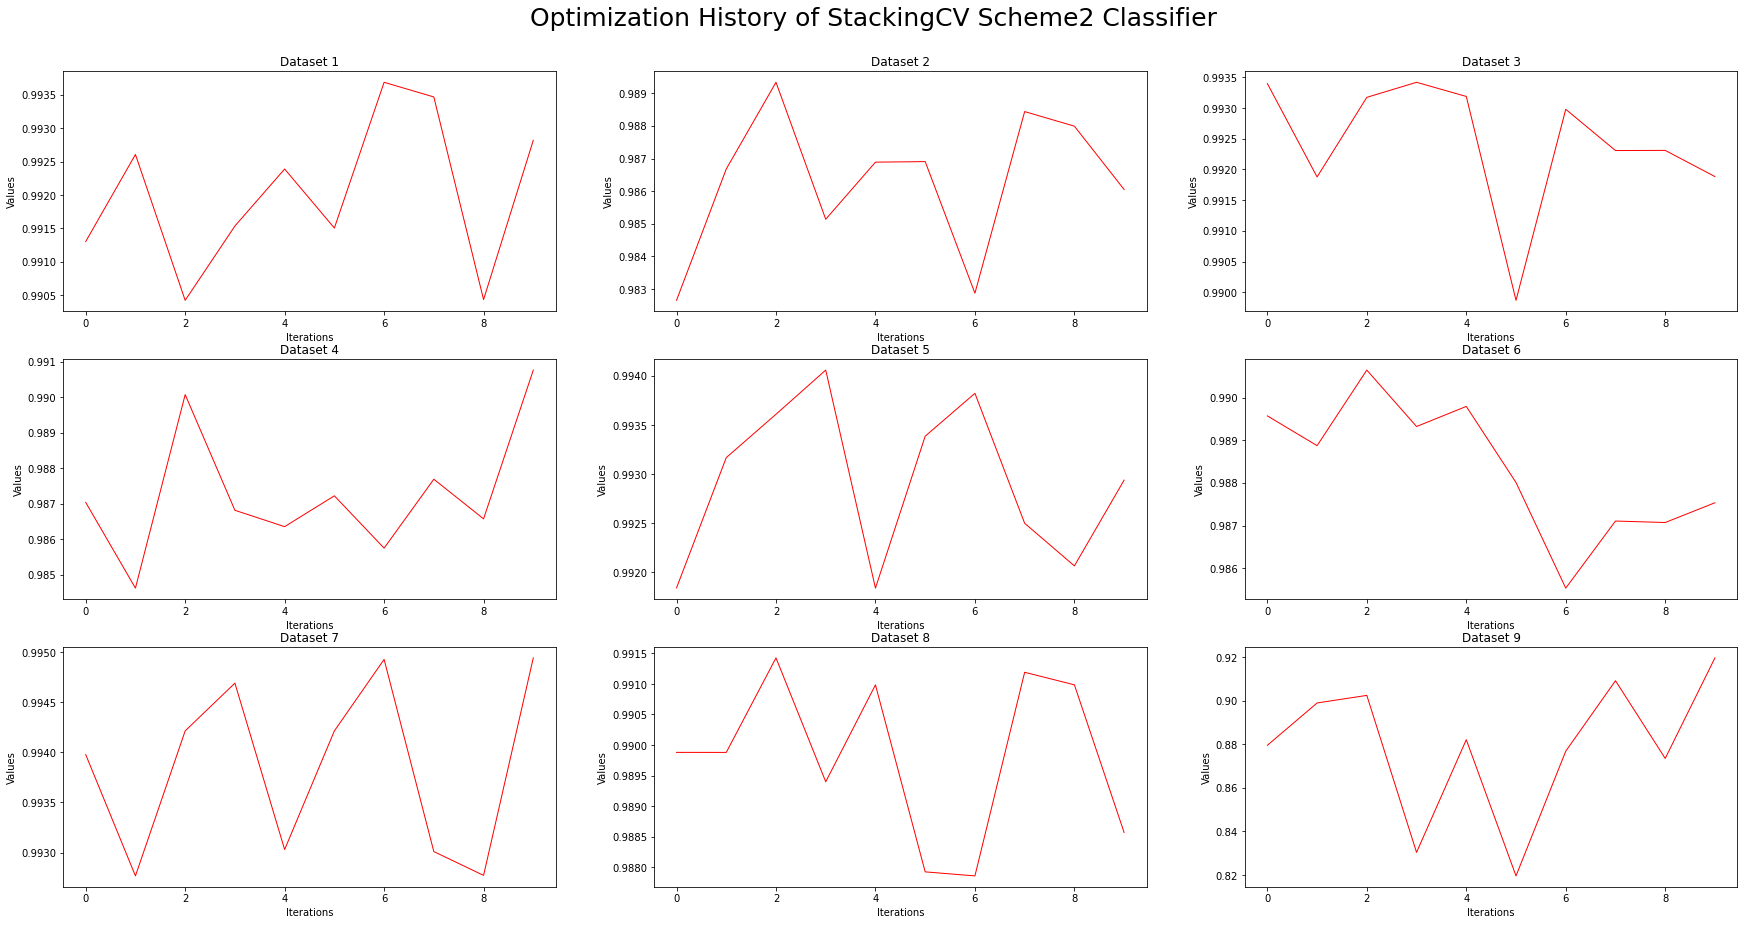

In [46]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'StackingCV Scheme2 Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

### Feature Importance of Meta Learner

        X_m2    C_m2    X_m3    C_m3    X_m4    C_m4   GB
X_m2     inf  176.31  741.04  201.79  646.70  180.58 -0.5
C_m2  176.31     inf  192.64  364.28  180.97  390.68 -0.5
X_m3  741.04  192.64     inf  187.89  391.83  216.35 -0.5
C_m3  201.79  364.28  187.89     inf  237.69  289.26 -0.5
X_m4  646.70  180.97  391.83  237.69     inf  179.65 -0.5
C_m4  180.58  390.68  216.35  289.26  179.65     inf -0.5
GB     -0.50   -0.50   -0.50   -0.50   -0.50   -0.50  inf


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3020, number of negative: 3040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 6060, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498350 -> initscore=-0.006601
[LightGBM] [Info] Start training from score -0.006601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


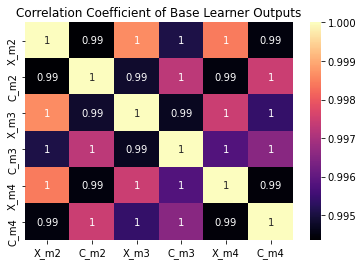

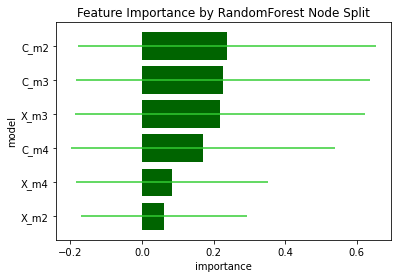

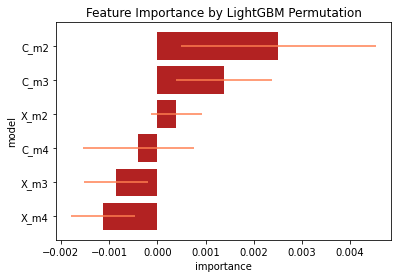

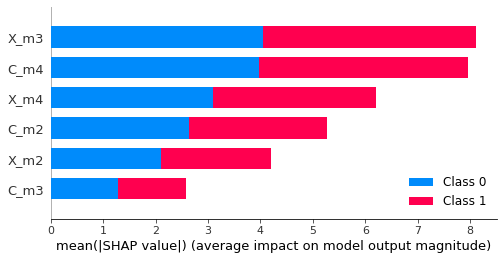

GLM  forest  permutation  SHAP  total_rank
C_m2  3.0     1.0          1.0   4.0         1.0
X_m3  1.0     3.0          5.0   1.0         2.0
C_m3  2.0     2.0          2.0   6.0         3.0
C_m4  6.0     4.0          4.0   2.0         4.0
X_m4  4.0     5.0          6.0   3.0         5.0
X_m2  5.0     6.0          3.0   5.0         6.0

In [24]:
target_set = 5
rank_importance(train_firstC[f'set{target_set}'], mode = 'C')

### Classifier

0it [00:00, ?it/s]


 Dataset1:
Precision: 0.0014548477605736258 
Recall: 0.5490196078431373 
Aging Rate: 0.39560936504347466

 Dataset2:
Precision: 0.0009139027455161646 
Recall: 0.47058823529411764 
Aging Rate: 0.5398055458488356

 Dataset3:
Precision: 0.0010198685502757422 
Recall: 0.5294117647058824 
Aging Rate: 0.5441838475611009

 Dataset4:
Precision: 0.0014090886216093805 
Recall: 0.5490196078431373 
Aging Rate: 0.4084564944808732

 Dataset5:
Precision: 0.0012374100719424461 
Recall: 0.8431372549019608 
Aging Rate: 0.7143003967193571

 Dataset6:
Precision: 0.0011493592322280328 
Recall: 0.7843137254901961 
Aging Rate: 0.7153692778885485

 Dataset7:
Precision: 0.0011276136473468861 
Recall: 0.6862745098039216 
Aging Rate: 0.6380192809718597

 Dataset8:
Precision: 0.0013789795551292043 
Recall: 0.45098039215686275 
Aging Rate: 0.34284363501819154



Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


 Dataset9:
Precision: 0.0010187950114175304 
Recall: 0.5686274509803921 
Aging Rate: 0.5851096630968776


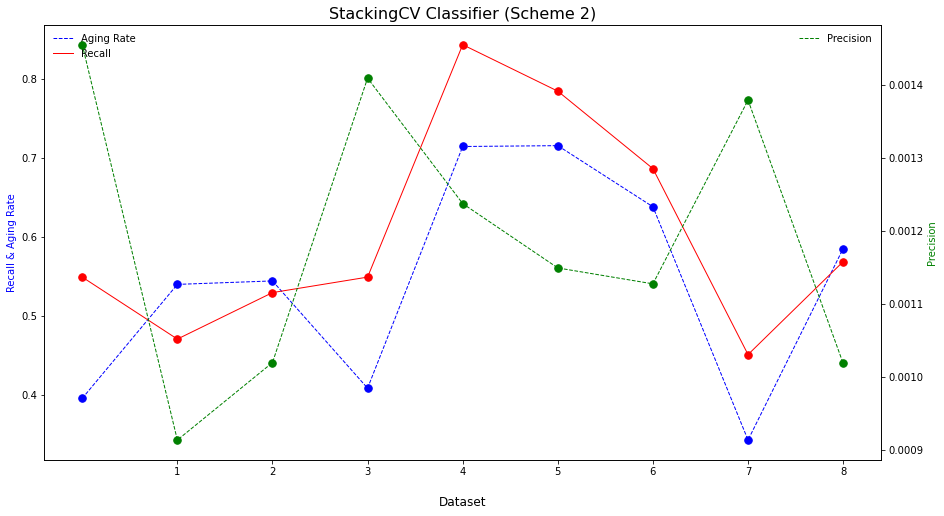

In [47]:
table_setC, coefC = runall_LR(train_firstC_x, test_firstC_x, train_firstC_y, test_firstC_y, best_paramC)
line_chart(table_setC, title = 'StackingCV Classifier (Scheme 2)')

In [48]:
table_setC

Balance Ratio  Train_OK  Train_NG    TP       FP    FN       TN  \
dataset1       1.000000    3067.0    3067.0  28.0  19218.0  23.0  29380.0   
dataset2       1.000000    2997.0    2997.0  24.0  26237.0  27.0  22361.0   
dataset3       1.000000    3033.0    3033.0  27.0  26447.0  24.0  22151.0   
dataset4       1.000000    3038.0    3038.0  28.0  19843.0  23.0  28755.0   
dataset5       1.006623    3040.0    3020.0  43.0  34707.0   8.0  13891.0   
dataset6       1.016722    3040.0    2990.0  40.0  34762.0  11.0  13836.0   
dataset7       1.099458    3040.0    2765.0  35.0  31004.0  16.0  17594.0   
dataset8       1.000000    3040.0    3040.0  23.0  16656.0  28.0  31942.0   
dataset9      10.000000    3040.0     304.0  29.0  28436.0  22.0  20162.0   

          Precision    Recall  Aging Rate  Efficiency  F1 Score     Score  
dataset1   0.001455  0.549020    0.395609    1.387782  0.001451  0.477847  
dataset2   0.000914  0.470588    0.539806    0.871774  0.000912  0.000000  
dataset3   0.001020  0.529412    0.544184    0.972855  0.001018  0.000000  
dataset4   0.001409  0.549020    0.408456    1.344132  0.001405  0.467718  
dataset5   0.001237  0.843137    0.714300    1.180368  0.001236  0.657220  
dataset6   0.001149  0.784314    0.715369    1.096376  0.001148  0.580557  
dataset7   0.001128  0.686275    0.638019    1.075633  0.001126  0.501163  
dataset8   0.001379  0.450980    0.342844    1.315411  0.001375  0.378637  
dataset9   0.001019  0.568627    0.585110    0.971831  0.001017  0.000000

### Export

In [49]:
savedate = '20220315'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'StackingCV2_XNL'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'StackingCV2_XNL')